## Mathematical Optimization Series

# Part 2: The gradient descent algorithm

In this post we describe our first major mathematical optimization algorithm: *gradient descent*.  Many of the core ideas we have seen with regards random local search - including e.g., steplengths and steplength rules, convergence issues, etc., - we will see carry over almost entirely to the gradient descent scheme.  In fact the only difference - at least at the outset - between gradient descent and the highly ineffective random local search (described in the previous post) is that with gradient descent we employ a closed form mathematically guaranteed descent direction at each step.  This means that unlike random search, gradient descent scales very nicely with the input dimension of a function, and so can be (and is) used with modern machine learning / deep learning problems.  This post builds our previous discussion of random local search in the previous post, so it is highly recommended that one read the previous post before proceeding.

In [1]:
# imports from custom library
import sys
sys.path.append('../../')
import matplotlib.pyplot as plt
from mlrefined_libraries import basics_library as baslib
from mlrefined_libraries import calculus_library as callib
from mlrefined_libraries import math_optimization_library as optlib
from mlrefined_libraries import linear_algebra_library as linlib
import autograd.numpy as np
import time

# this is needed to compensate for %matplotlib notebook's tendancy to blow up images when plotted inline
%matplotlib notebook
from matplotlib import rcParams
rcParams['figure.autolayout'] = True

%load_ext autoreload
%autoreload 2

# 1. The fundamental gradient descent algorithms

In this Section we describe the basic *gradient descent* algorithm, in fact we describe its two fundamental forms.  Both forms follow the overall structure of a *local search algorithm* as we detailed when discussing random local search in the previous post.  By that we mean, that as a local search algorithm gradient descent consists of an initialization $\mathbf{w}^0$ followed by taking number of steps $\mathbf{w}^1, \mathbf{w}^2, \mathbf{w}^3,...,\mathbf{w}^{K}$ of the general form 

$$
\mathbf{w}^{\,k} = \mathbf{w}^{\,k-1} + \alpha \mathbf{d}^{\,k}
$$

where $\mathbf{d}^{\,k}$ is a unit-length direction (preferrably one that provides descent in the function), and $\alpha$ is called a steplength that controls the length of each step, i.e.,

$$
\Vert \mathbf{w}^{\,k} - \mathbf{w}^{\,k-1} \Vert_2 = \alpha 
$$

As we saw in the previous post, these steplengths can be fixed for all steps of the run or can change at each step e.g., a diminishing steplength at step $k$ like $\alpha = \frac{1}{k}$.

With gradient descent we do not randomly seek out a direction at each step, but use a fundamental fact from calculus: the tangent hyperplane (or first order Taylor Series approximation) of function $g$ at a point $\mathbf{w}^k$ has a natural direction of steepest descent defined by the negative gradient $-\nabla g\left(\mathbf{w}^0\right)$, and since the hyperplane closely resembles $g$ near $\mathbf{w}^0$ we this direction provides descent in the function (at least locally) as well.

#  1.2    The gradient generated descent direction

In our series on the *Vital Elements of Calculus* we saw an important interpretation of the derivative, or more generally the gradient, that we briefly review here in the context of local search algorithms.  

The gradient of a function $g(\mathbf{w})$: at a given point $\mathbf{w}^0$ - denoted $\nabla g\left(\mathbf{w}^0\right)$ - provides the direction of steepest *ascent* of the tangent hyperplane of $g$ at this point.  This is the direction in which the hyperplane increases the fastest and - because it so closely mimics the function $g$ near the input point $\mathbf{w}^0$ - the direction in which $g$ increases rapidly near $\mathbf{w}^0$ as well.  Likewise the negative gradient $-\nabla g\left(\mathbf{w}^0\right)$ defines the steepest *descent* direction here, that is the direction in which the hyperplane *decreases* the fastest and -  because it so closely mimics the function $g$ near the input point $\mathbf{w}^0$ - the direction in which $g$ *decreases* rapidly near $\mathbf{w}^0$ as well.  Lets look at a few specific examples to build our intuition on this topic.

#### <span style="color:#a50e3e;">Example 1. </span> The negative derivative as descent direction with single-input functions

We illustrated this fact by plotting several examples, like the one we repeat below of the simple quadratic $g(w) = 0.4w^2 + 1.5$.  The next Python cell plots this function in black along with an point of tangency $(w^0,g\left(w^0\right))$ and the tangent line there in green.  The slope of this line - i.e., the derivative $\frac{\mathrm{d}}{\mathrm{d}w}g\left(w^0\right)$ a.k.a. the *ascent direction* - is shown as a black arrow along the horizontal axis with direction and magnitude given by $\frac{\mathrm{d}}{\mathrm{d}w}g\left(w^0\right)$.  The *descent* direction given by $-\frac{\mathrm{d}}{\mathrm{d}w}g\left(w^0\right)$ is likewise shown as a red arrow along the horizontal axis.  Using the slider widget below the image you can move the point $w^0$ back and forth across a short range of the input domain for this function and the ascent / descent directions provided by the derivative there.  Notice how at each input point the *descent direction* directs us towards the global minimum of the function at $w = 0$.  

<IPython.core.display.Javascript object>


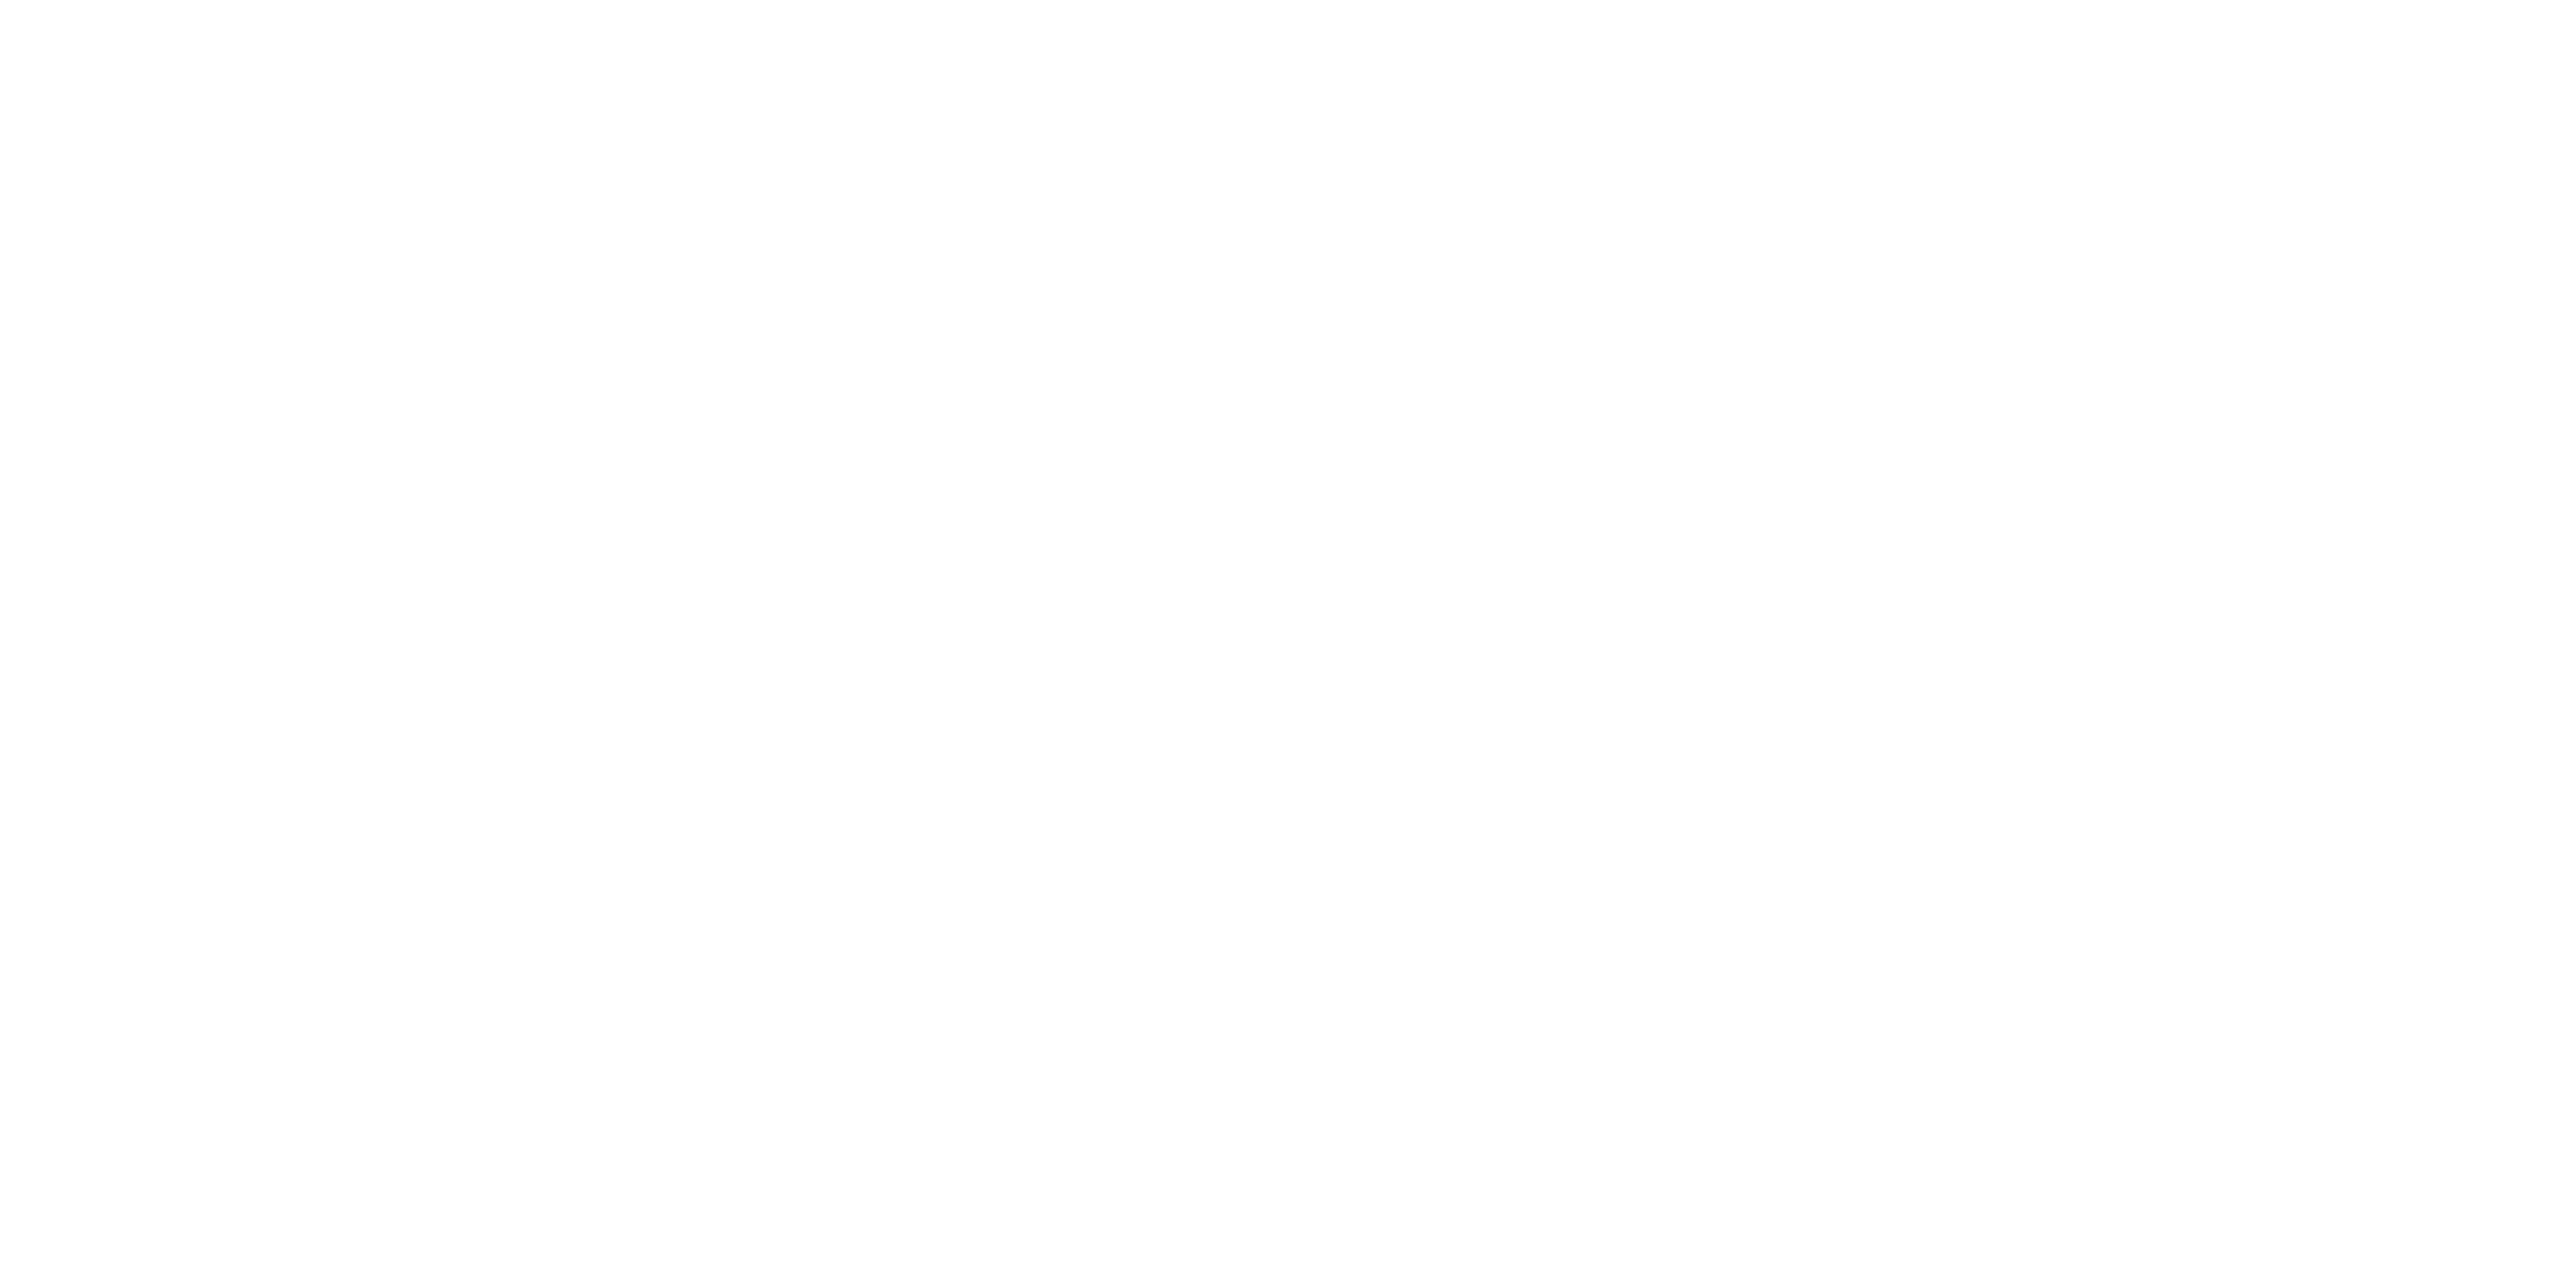

starting animation rendering...
rendering animation frame 25 of 150
rendering animation frame 50 of 150
rendering animation frame 75 of 150


In [ ]:
# what function should we play with?  Defined in the next line.
g = lambda w: 0.4*w**2 + 1.5

# run the visualizer for our chosen input function
callib.derivative_ascent_visualizer.animate_visualize2d(g=g,num_frames = 150,plot_descent = True)

Note it is the *direction and not the magnitude of the derivative* that provides ascent / descent direction for the underlying function.  Because of this we can normalize the derivative to have unit length by dividing off its norm as $\frac{\frac{\mathrm{d}}{\mathrm{d}w}g(w)}{\left\Vert \frac{\mathrm{d}}{\mathrm{d}w}g(w) \right\Vert_2 }$.  The value of this unit-length derivative is either +1 or -1, which makes sense since there are only two directions to move in when our input is one dimensional - left or right - and only one way to move in either direction one *unit* (i.e., $\pm 1$).  So it is in fact the case that $\frac{\frac{\mathrm{d}}{\mathrm{d}w}g(w)}{\left\Vert \frac{\mathrm{d}}{\mathrm{d}w}g(w) \right\Vert_2 } = \text{sign}(\frac{\mathrm{d}}{\mathrm{d}w}g(w))$ where $\text{sign}(\cdot)$ takes the function taking the arithmetic sign of an input.

#### <span style="color:#a50e3e;">Example 2. </span> The negative gradient as descent direction for multi-input functions

Back in our Calculus series we also illustrated the notion of a descent direction in three dimensions in the following static image of a three dimensional quadratic.  Here we repeat a plot of the simple quadratic function
$g(\mathbf{w}) = \mathbf{w}^T \mathbf{w}^{\,} + 6$, where $\mathbf{w}^0 = \begin{bmatrix} -1 \\ 1 \end{bmatrix}$,  with the point of tangency and tangent hyperplane in green, along with (in the input plane) the gradient here $\nabla g\left(\mathbf{w}^0 \right) = \left((\frac{\partial}{\partial w_1}g\left(\mathbf{w}^0 \right),\frac{\partial}{\partial w_2}g\left(\mathbf{w}^0 \right)\right)$ in black (along with each of its partial derivatives in blue), and the negative gradient  $-\nabla g\left(\mathbf{w}^0 \right)$ in red.  As in the single-input case the negative derivative (gradient) points in a descent direction for the underlying function.

<IPython.core.display.Javascript object>


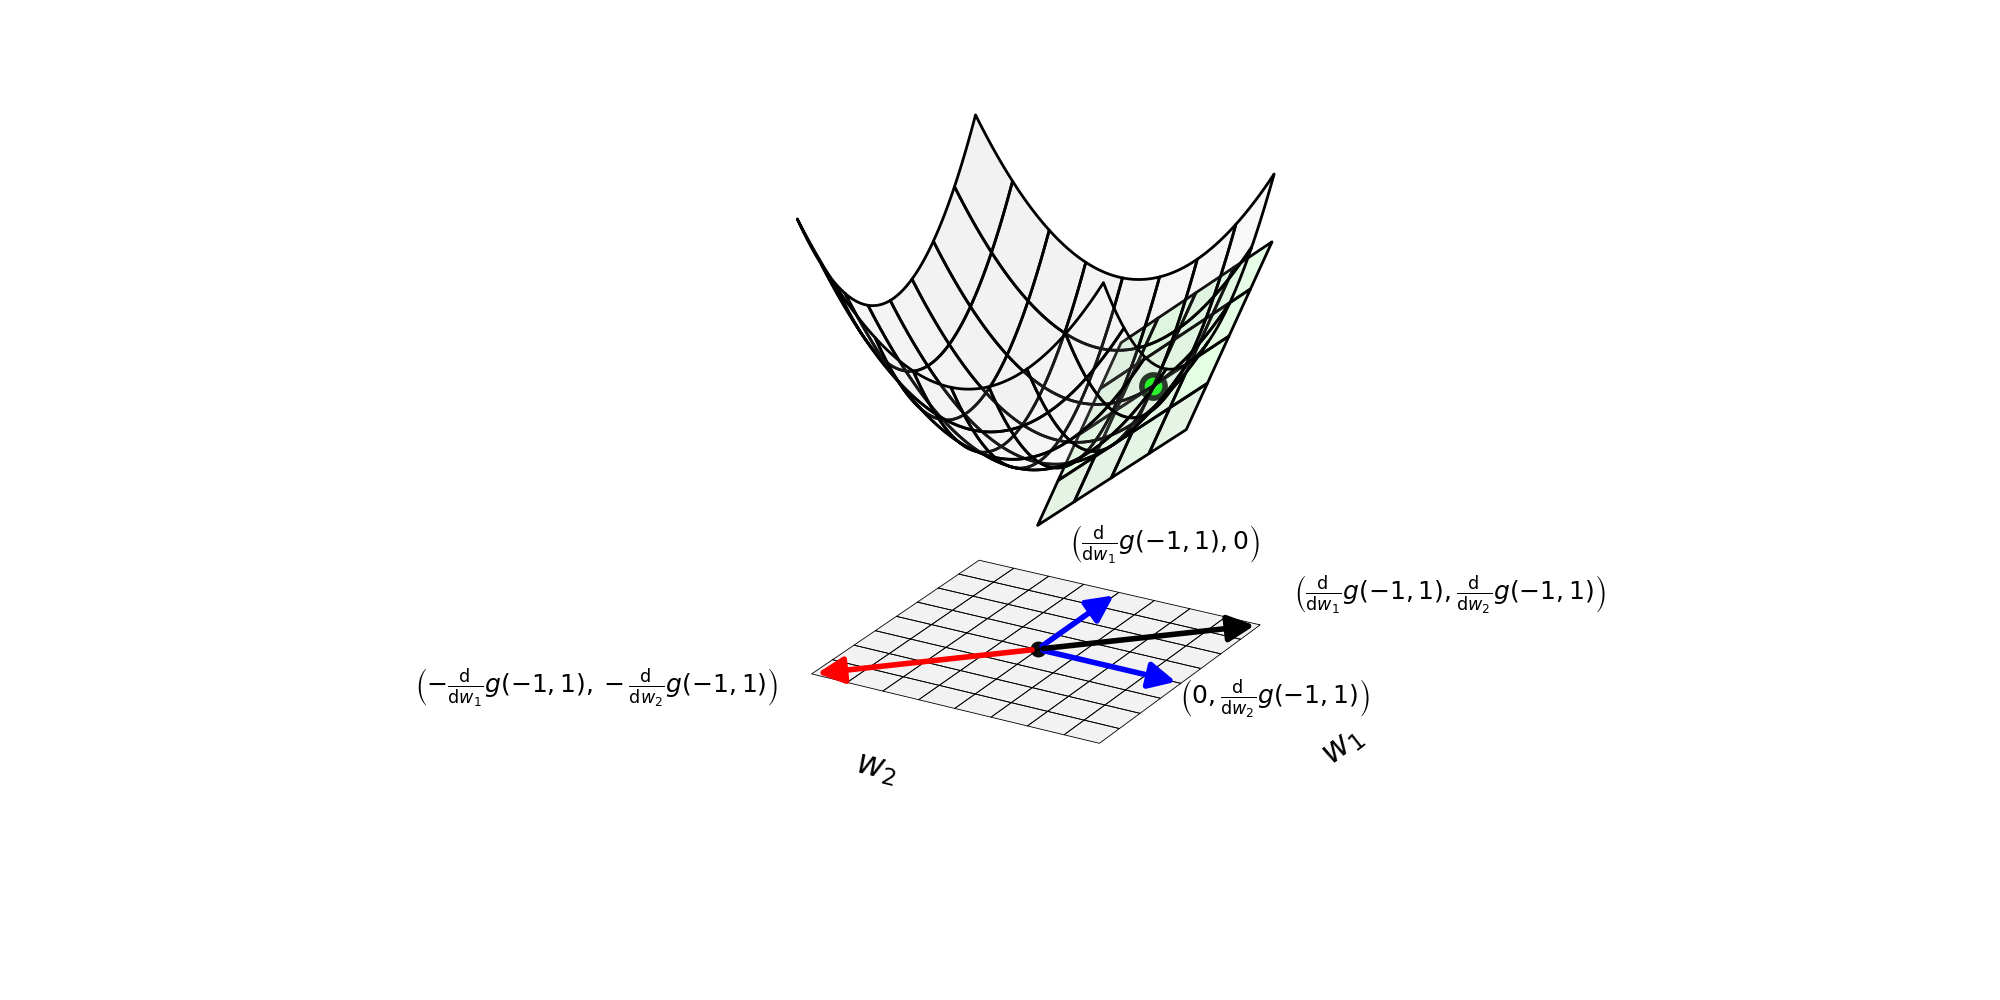

In [3]:
# define function, and points at which to take derivative
func = lambda w:  (w[0])**2 + (w[1])**2 + 6
pt1 = [-1,1];

# animate 2d slope visualizer
view = [33,30]
callib.derivative_ascent_visualizer.visualize3d(func=func,view = view,pt1 = pt1,plot_descent = True)

As with the single-input case we only care about the descent *direction* here and not its magnitude, so we can unit-normalize the negative gradient by dividing off its length as $- \frac{\nabla g(\mathbf{w})}{\left\Vert \nabla g(\mathbf{w}) \right\Vert_2 }$.  Note this is not a unit length vector of dimension $N$, i.e.,

$$
-\frac{\nabla g(\mathbf{w})}{\left\Vert \nabla g(\mathbf{w}) \right\Vert_2 } = 
\begin{bmatrix}
\frac{-\frac{\partial}{\partial w_1}g\left(\mathbf{w}\right)}{\left\Vert \nabla g(\mathbf{w}) \right\Vert_2} \\
\frac{-\frac{\partial}{\partial w_2}g\left(\mathbf{w}\right)}{\left\Vert \nabla g(\mathbf{w}) \right\Vert_2} \\
\vdots \\
\frac{-\frac{\partial}{\partial w_N}g\left(\mathbf{w}\right)}{\left\Vert \nabla g(\mathbf{w}) \right\Vert_2}
\end{bmatrix}
$$

## 1.3  Gradient descent

Since the (negative) derivative(s) define a descent direction for an underlying function, what would it look like if we repeatedly used this direction to move downward on a function via a local method?   It seems apparent that such a method could - if we choose the steplength correctly at least - lead us to a point near the a local minimum of the function.  This approach - for a general single-input function - would look something like the picture below.  

<img src="../../mlrefined_images/math_optimization_images/Fig_2_7.png" width=700 height=250/>

Here we begin at some point $w^0$ chosen at random - with an evaluation of $g\left(w^0\right)$ shown as a red dot on the function itself -  and compute the derivative there.  We can think of this derivative as generating the tangent line to $g$ at $w^0$, and know that  $\frac{-\frac{\mathrm{d}}{\mathrm{d}w}g(w^0)}{\left\Vert \frac{\mathrm{d}}{\mathrm{d}w}g(w^0) \right\Vert_2 }$ is the unit-length descent direction for the tangent line and - by extension - for the function itself (at least locally). 

Since we have unit-normalized the descent direction we know can see that the length of our step explicitly by our steplength parameter $\alpha$ - as was the case with random local search, where our (descnt) direction was always constrained to have length one -  that is we move precisely a distance of $\alpha$ to our new point $w^1 = w^0 - \alpha \frac{\frac{\mathrm{d}}{\mathrm{d}w}g(w^0)}{\left\Vert \frac{\mathrm{d}}{\mathrm{d}w}g(w^0) \right\Vert_2 }$.  The evaluation of this point is marked as a red circle on the function, and a red 'x' on the tangent line itself.  We then repeat the same process again starting at $w_1$ - computing the derivative at $w^1$, imagining it generating the tangent line to $g$ there, and moving in the unit-length descent direction defined by the (negative derivative) to $w^2 = w^1 - \alpha \frac{\frac{\mathrm{d}}{\mathrm{d}w}g(w^1)}{\left\Vert \frac{\mathrm{d}}{\mathrm{d}w}g(w^1) \right\Vert_2 }$.  Following this routine at the $k^{th}$ step we
$w^{\,k} = w^{\,k-1} - \alpha \frac{\frac{\mathrm{d}}{\mathrm{d}w}g(w^{\,k-1})}{\left\Vert \frac{\mathrm{d}}{\mathrm{d}w}g(w^{\,k-1}) \right\Vert_2 }$.

This local search method, described as an intuitive way to leverage the derivative of a function in order to extract descent directions, is in fact a hugely popular algorithm known as *gradient descent*.  Why call it gradient descent?  Because the (negative) gradient provides a provable descent direction, and we use it to iteratively to find low points of a function: hence *gradient descent*.

In our derivative we normalized the derivative at each step to have unit length - this flavor of gradient descent is often called *normalized gradient descent*.  For a general multi-input function this is a local method - which takes the form $\mathbf{w}^{\,k} = \mathbf{w}^{\,k-1} + \alpha \mathbf{d}^{\,k}$ -   employing the unit-length negative gradient direction $\mathbf{d}^{\,k} = -\frac{\nabla g(\mathbf{w})}{\left\Vert \nabla g(\mathbf{w}) \right\Vert_2 }$ at each step as a descent direction, and thus consists of the sequence of steps

$$
\mathbf{w}^{\,k} = \mathbf{w}^{\,k-1} - \alpha \frac{\nabla g(\mathbf{w}^{\,k-1})}{\left\Vert \nabla g(\mathbf{w}^{\,k-1}) \right\Vert_2 }
$$

Note that as mentioned we can easily check that indeed the length of each step here is controlled explicitly by the steplength parameter $\alpha$ (i.e., each step has length $\alpha$ here), since $\left\Vert  \frac{\nabla g(\mathbf{w}^{\,k-1})}{\left\Vert \nabla g(\mathbf{w}^{\,k-1}) \right\Vert_2 }\right\Vert_2 = 1$, so we can compute the general length of the $k^{th}$ step as 

$$
\left\Vert \mathbf{w}^{\,k} - \mathbf{w}^{\,k-1} \right\Vert_2 = \left\Vert -\alpha \frac{\nabla g(\mathbf{w}^{\,k-1})}{\left\Vert \nabla g(\mathbf{w}^{\,k-1}) \right\Vert_2 }\right\Vert_2 = \alpha \left\Vert \frac{\nabla g(\mathbf{w}^{\,k-1})}{\left\Vert \nabla g(\mathbf{w}^{\,k-1}) \right\Vert_2 }\right\Vert_2 = \alpha.
$$

> The *normalized gradient descent algorithm* is a local method whose $k^{th}$ step takes the form: $\mathbf{w}^{\,k} = \mathbf{w}^{\,k-1} - \alpha \frac{\nabla g(\mathbf{w}^{\,k-1})}{\left\Vert \nabla g(\mathbf{w}^{\,k-1}) \right\Vert_2 }$  Here the length of each step is precisely $\alpha$, the steplength.

Of course we do not necessarily need to unit-normalize the descent direction - it is still the same descent direction after all regardless of its length.  Thus another common flavor of gradient descent 
is *unnormalized gradient descent* takes similar looking steps


$$
\mathbf{w}^{\,k} = \mathbf{w}^{\,k-1} - \alpha \nabla g(\mathbf{w}^{\,k-1})
$$


where we leave each gradient unnormalized.  Unnormalized gradient descent is often called just *gradient descent* for historical reasons, but when we use it in the phrase *gradient descent* alone in the future we will be referring to both the normalized or unnormalized version unless otherwise specified.  Notice here that the length of each step is no longer defined strictly by the steplength parameter $\alpha$ itself, but by the steplength times the magnitude of the gradient.  In particular we have that the length of the $k^{th}$ step is given as

$$
\left\Vert \mathbf{w}^{\,k} - \mathbf{w}^{\,k-1} \right\Vert_2  = \left\Vert -\alpha \nabla g\left(\mathbf{w}^{\,k-1}\right)\right\Vert_2 = \alpha\left\Vert \nabla g\left(\mathbf{w}^{\,k-1}\right) \right\Vert_2
$$

> The *(unnormalized) gradient descent algorithm* is a local method whose $k^{th}$ step takes the form: $\mathbf{w}^{\,k} = \mathbf{w}^{\,k-1} - \alpha \nabla g\left(\mathbf{w}^{\,k-1}\right)$  Here the length of each step is precisely $\alpha\left\Vert \nabla g\left(\mathbf{w}^{\,k-1}\right) \right\Vert_2$, not just the steplength parameter itself.

From a mathematical point of view there is no difference between these two approaches descent -  for example, setting $\alpha \longleftarrow \frac{\alpha}{{\left\Vert \nabla g(\mathbf{w}^{\,k-1}) \right\Vert_2 }}$ makes the unnormalized step $\mathbf{w}^{\,k} = \mathbf{w}^{\,k-1} - \alpha \nabla g\left(\mathbf{w}^{\,k-1}\right)$ a normalized one.  However from a strictly practically perspective - particularly in the context of machine learning / deep learning - each form has its pragmatic advantages.  

However before tackling this issue let us look at a few examples that highlight some the important common behavior shared by both versions of gradient descent.  This includes (in no particular order):


> **1. Minimum finding behavior:** as a local method gradient descent can find minima that we could never compute by hand using the unconstrained first order optimality condition 
 
> **2.  Robustness to the size of input dimension:** gradient descent is very robust to the size of input dimension, and is able to scale to functions that have hundreds of thousands or even hundreds of millions of inputs

> **3.  Application to functions with many local minima:** when applied to non-convex functions with many local minima gradient descent - like any local method - can be run multiple times with different initializations in order to seek out global minima

> **4.  Stepsize parameter selection and descending / ascending:** while at every step gradient descent provides a descent direction, whether or not we descend in the function itself depends on our choice of steplength parameter. 

#### <span style="color:#a50e3e;">Example 3. </span>  Gradient descent finds minima that we cannot compute by hand

Here we use (unnormalized) gradient descent to minimize the polynomial function

$$
g(w) = \frac{1}{50}\left(w^4 + w^2 + 10w\right)
$$

In our post on *unconstrained optimality conditions*  we saw that the global minimum of this problem - which we could not compute by hand easily - was given explicitly as  

$$
w = \frac{\sqrt[\leftroot{-2}\uproot{2}3]{\sqrt[\leftroot{-2}\uproot{2}3]{2031} - 45}}{6^{\frac{2}{3}}} - \frac{1}{\sqrt[\leftroot{-2}\uproot{2}3]6\left(\sqrt{2031}-45\right)}
$$

With gradient descent we can easily determine a point that is arbitrarily close to this one.  This illustrates the general principle that gradient descent - and local search in general - can compute minima of functions that we cannot compute by hand using calculus alone.

In the next Python cell we animate the process of (unnormalized) gradient descent applied to minimize this function (we could use either gradient descent version).  We initialize the algorithm at $w^0 = 2.5$, set the steplength constant for all steps as $\alpha = 0.5$, and run for 45 iterations.  As you move the slider left to right the descent process as described above is shown visually - including the illustration of the tangent line.  We mark the evaluation of each step of the process on both the function and the tangent line for visualization purposes.  Moving the slider all the way to the right we can see that the algorithm begins bouncing around near the global minimum of the function.  


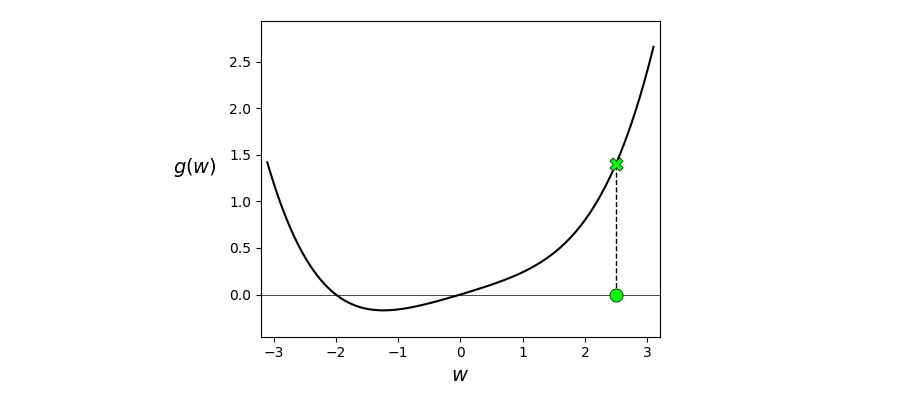
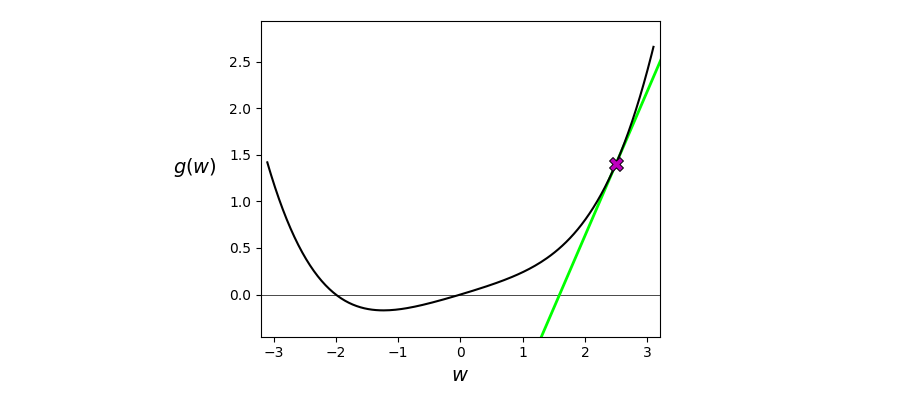
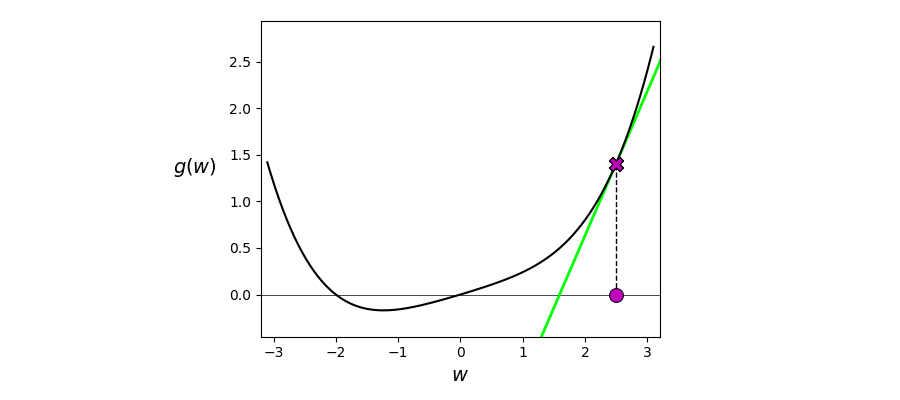
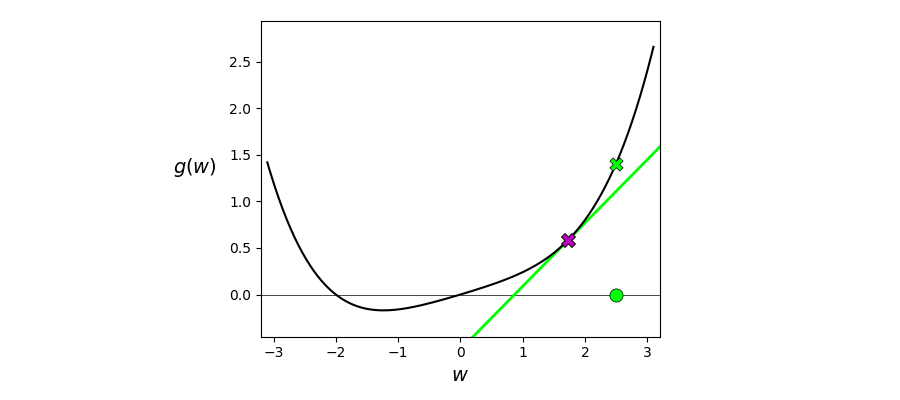
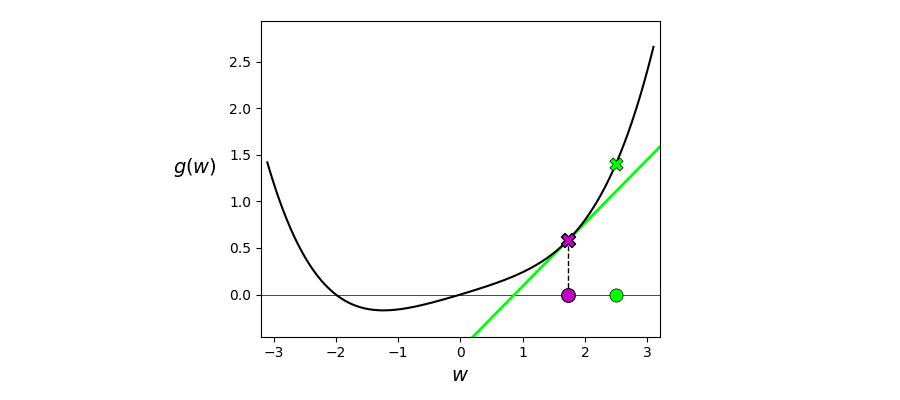
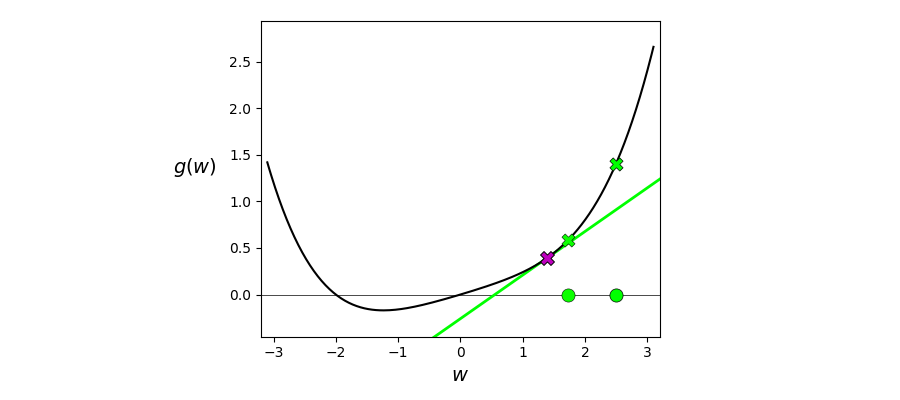
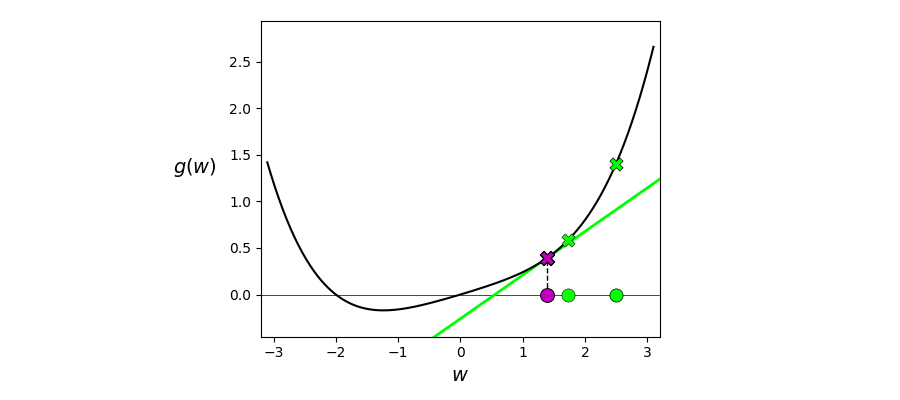
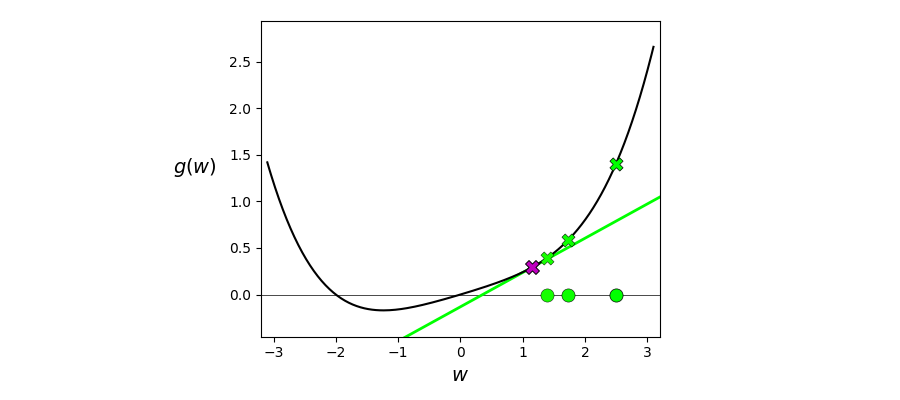
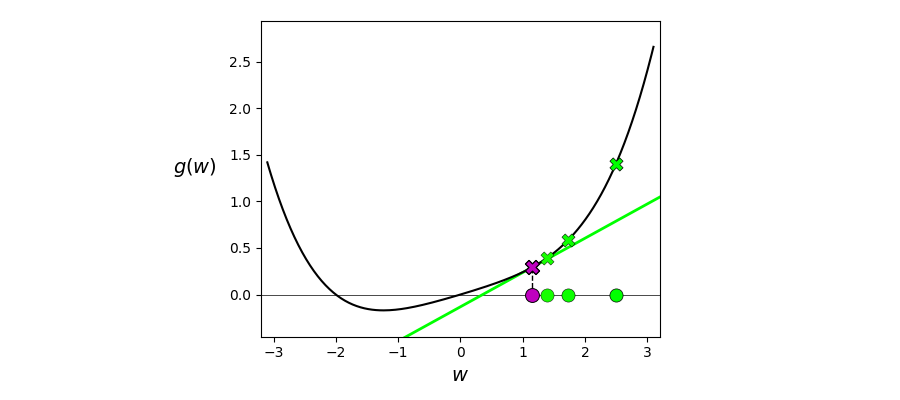
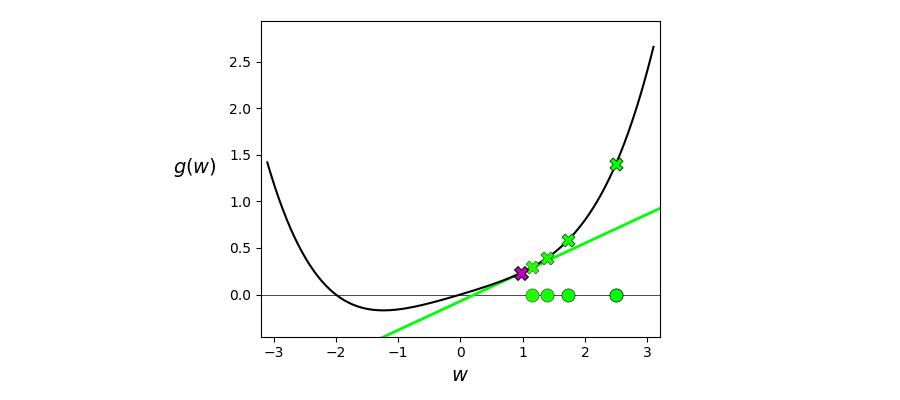
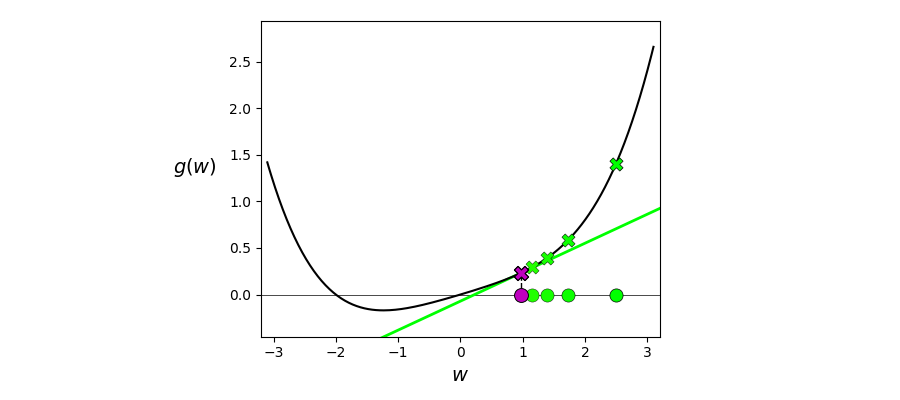
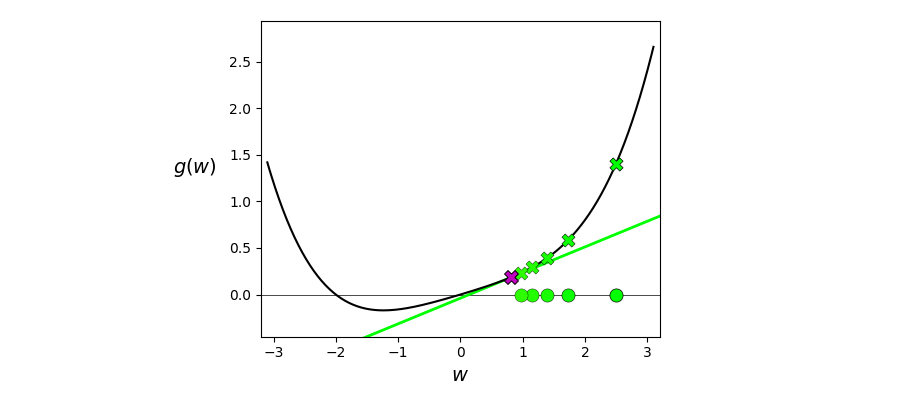
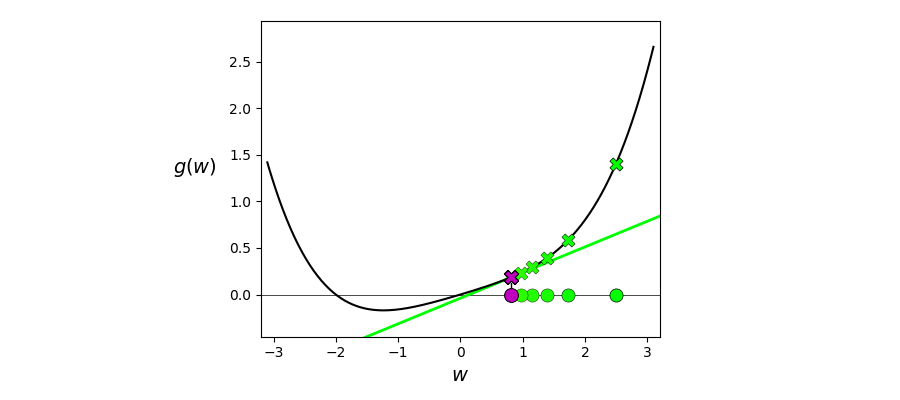
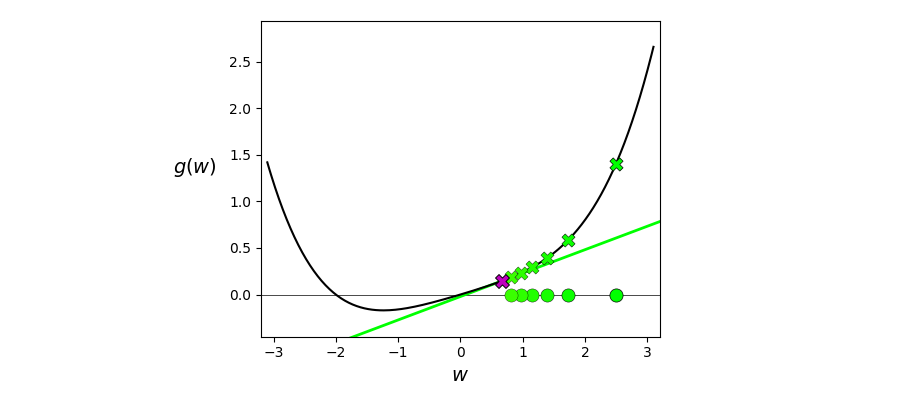
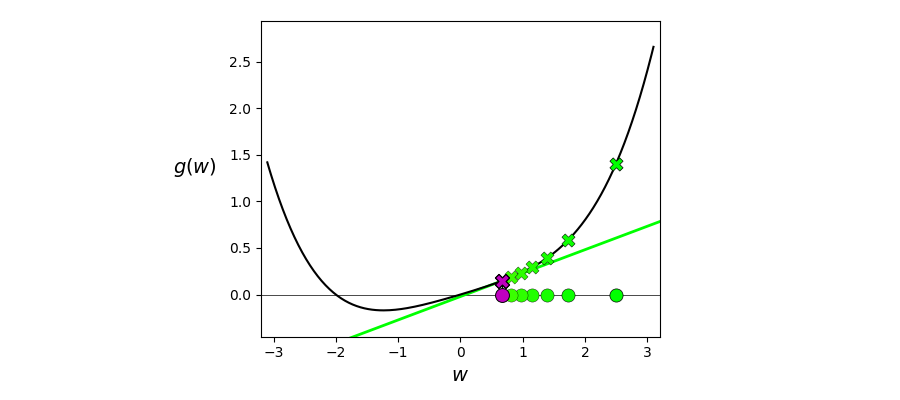
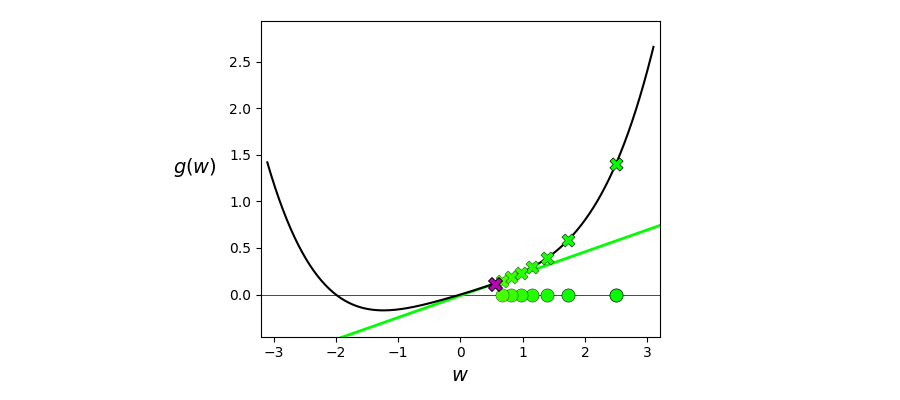
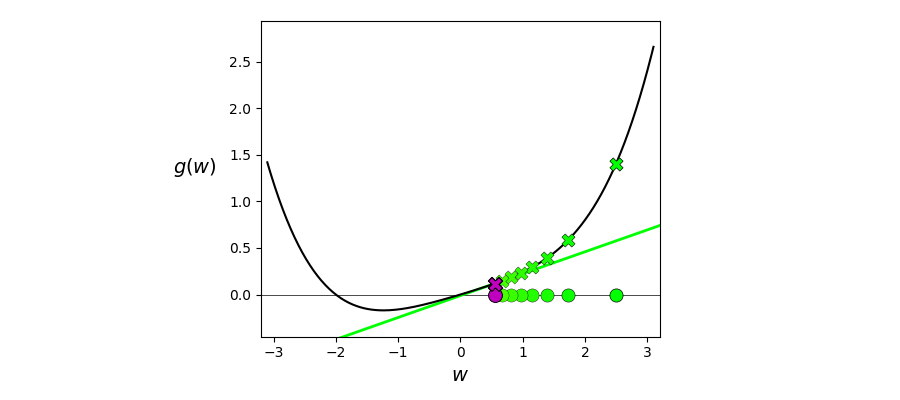
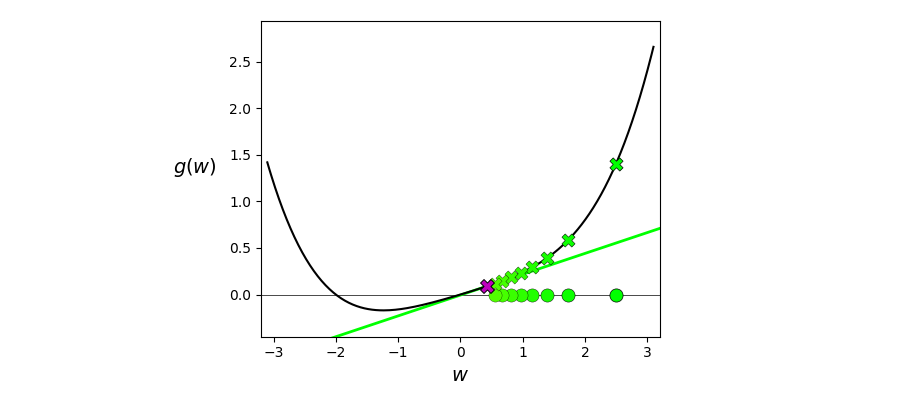
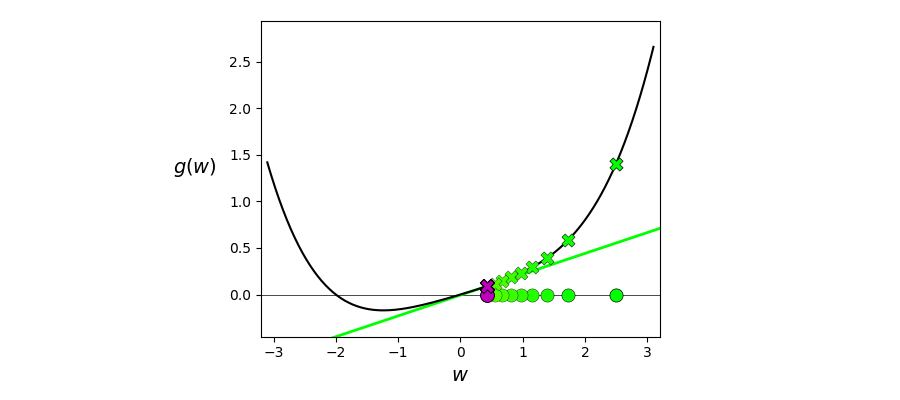
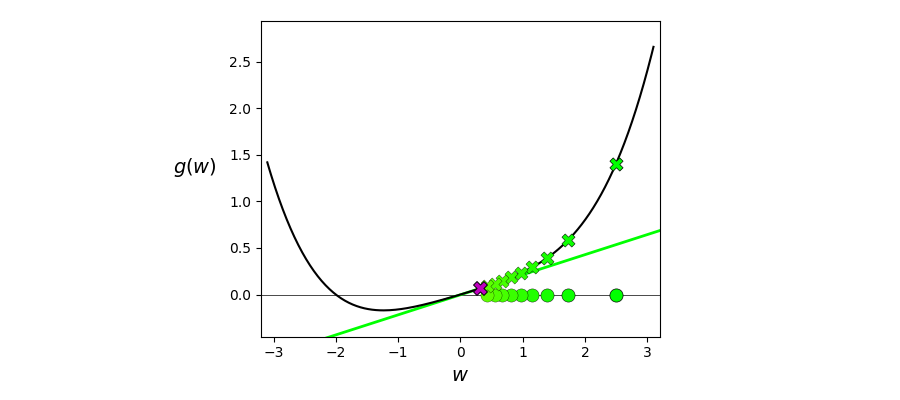
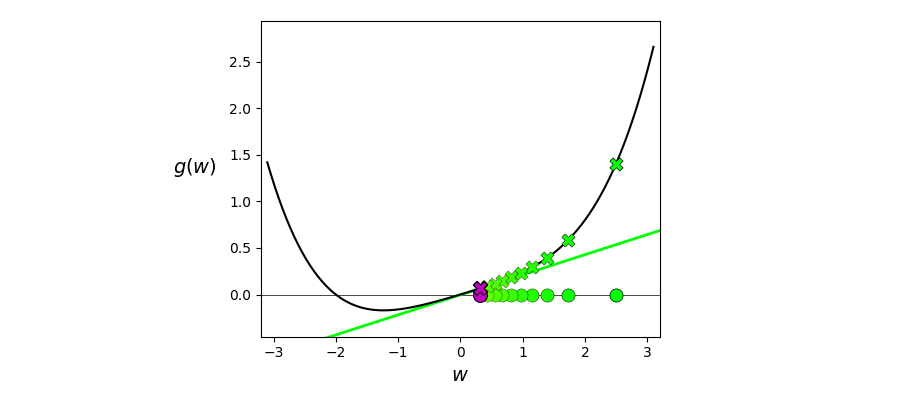
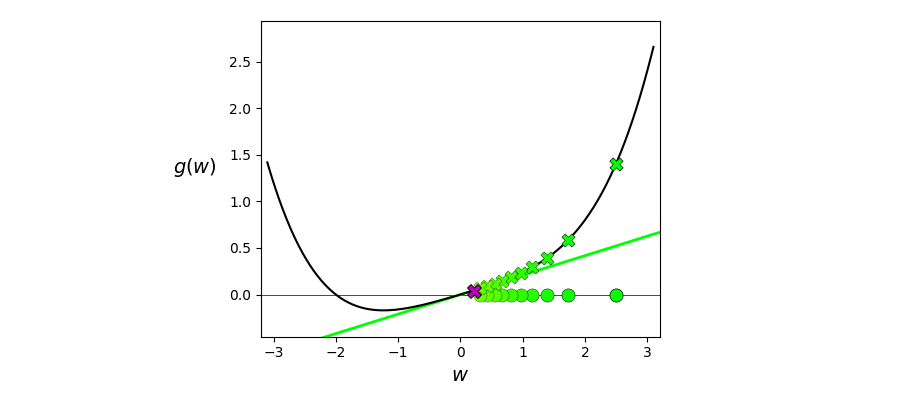
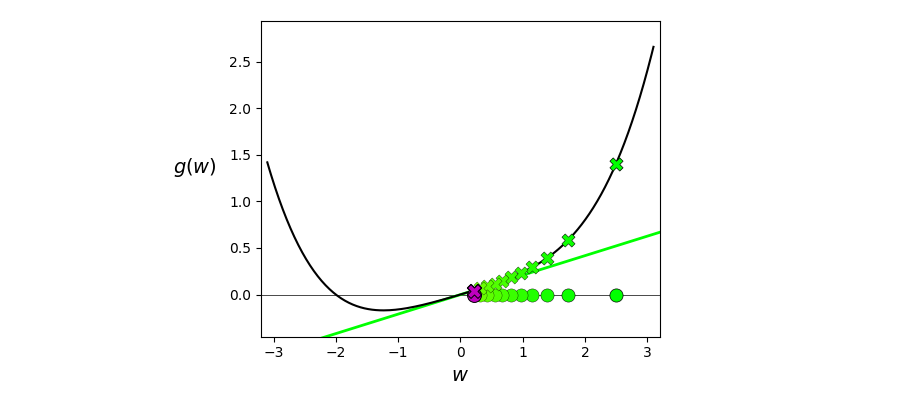
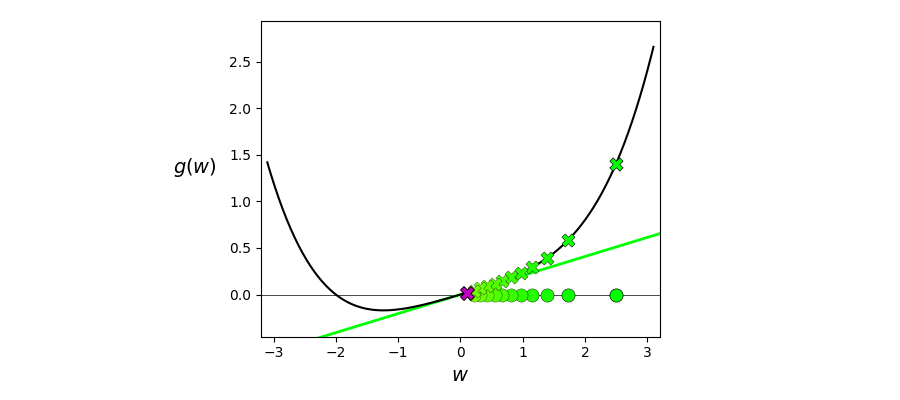
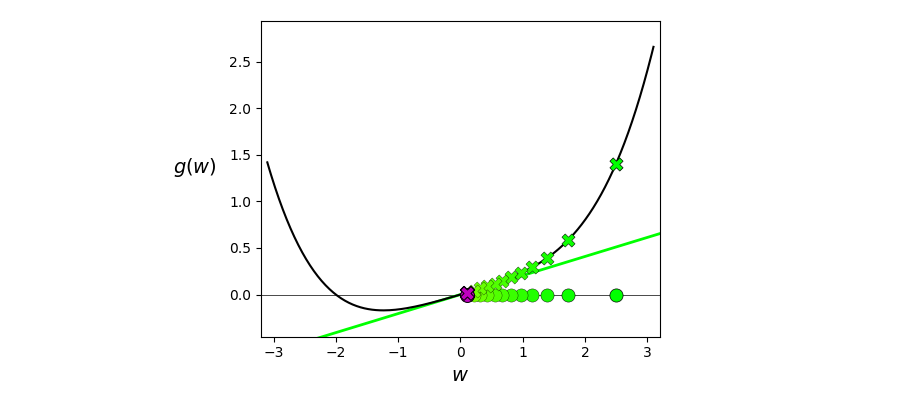
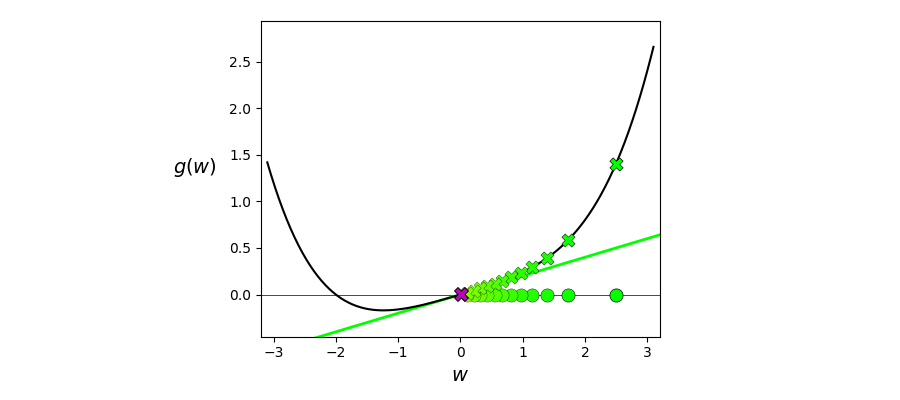
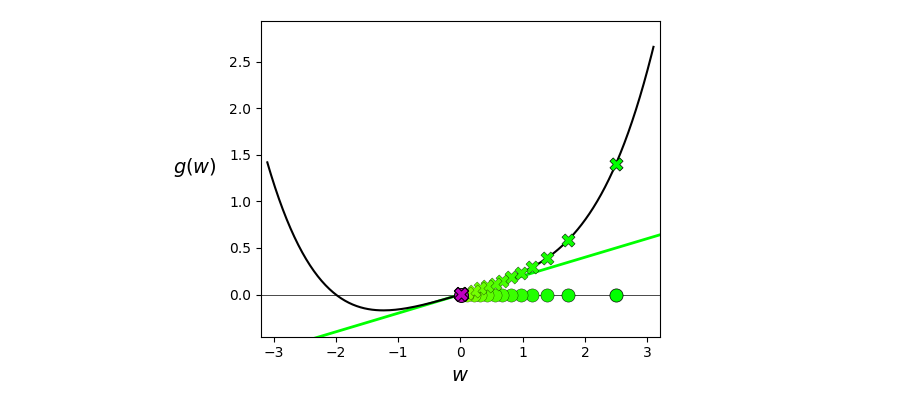
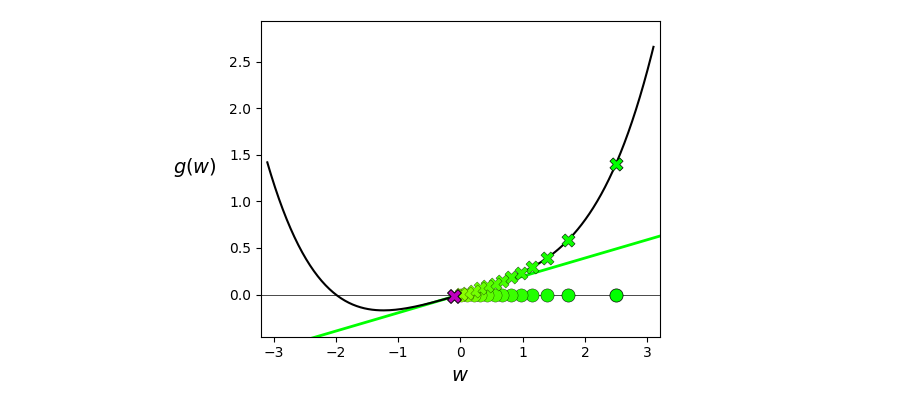
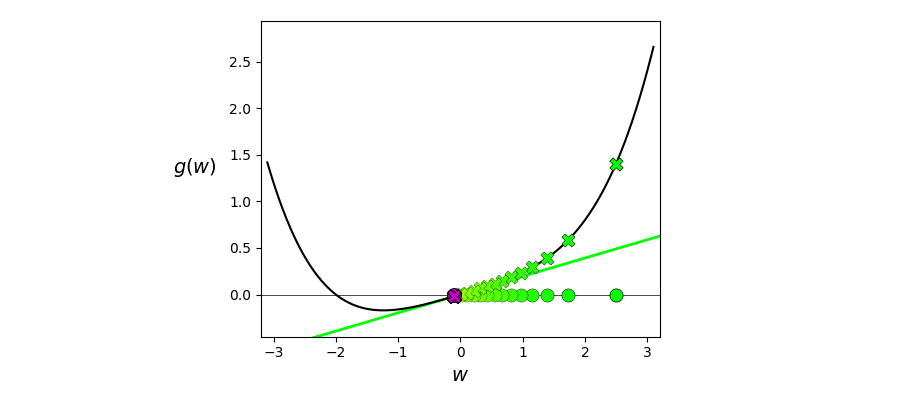
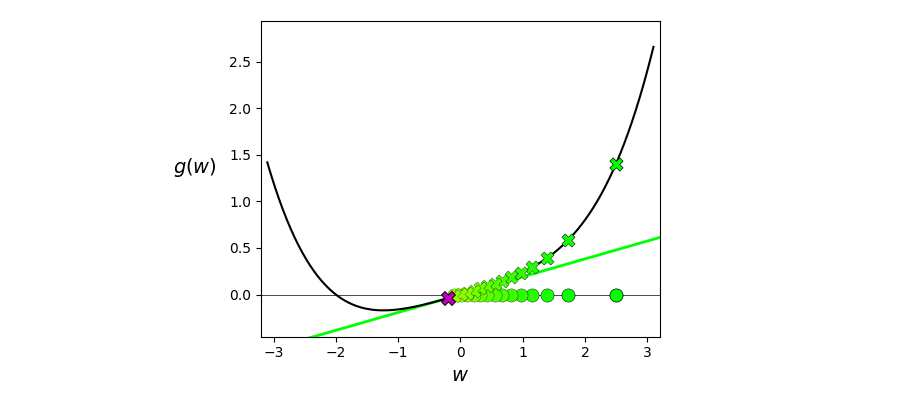
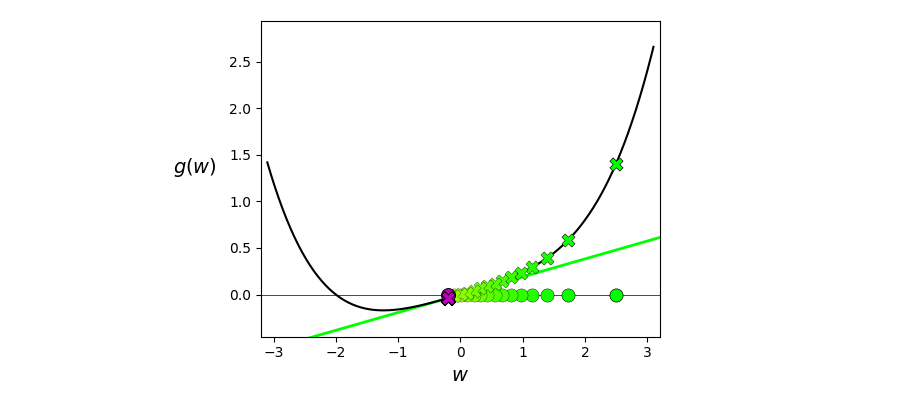
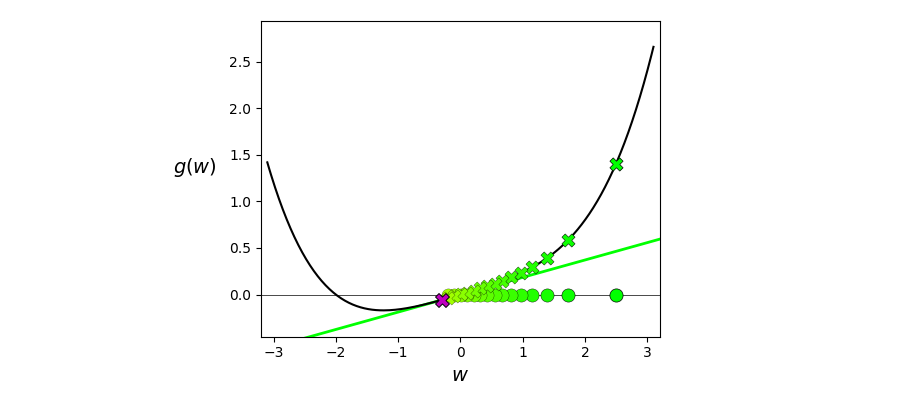
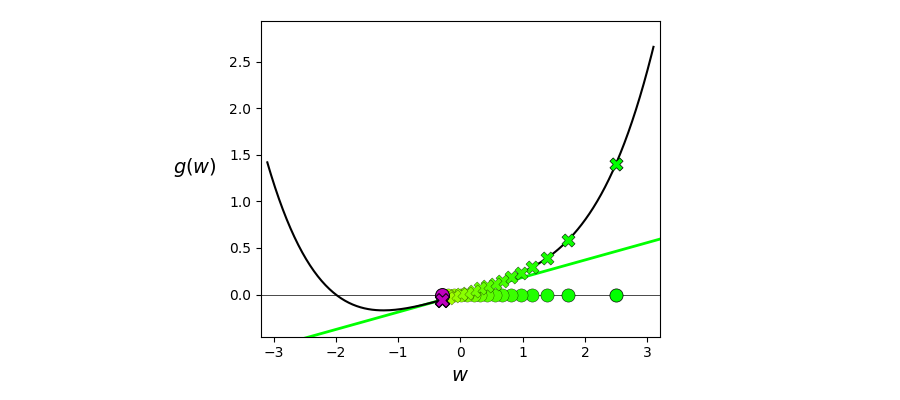
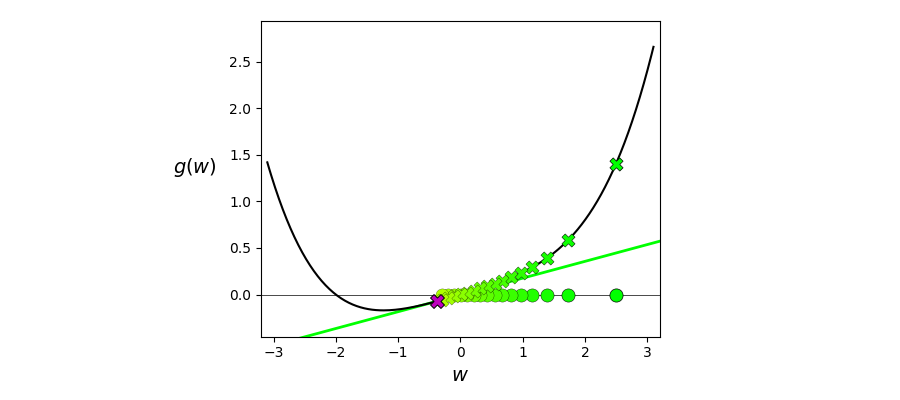
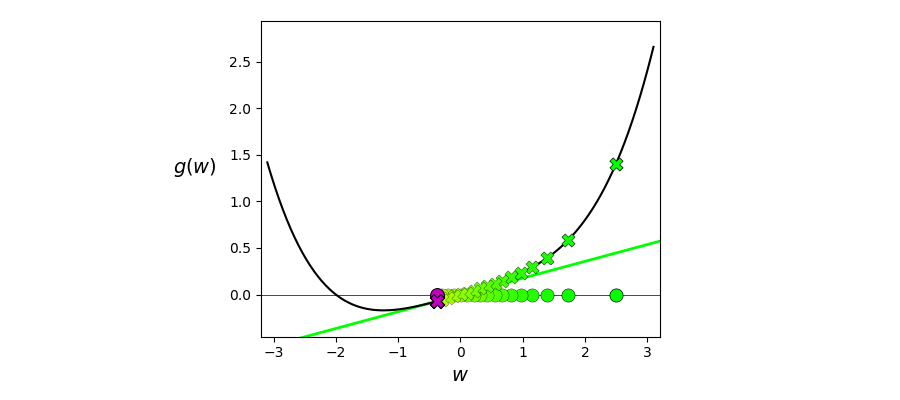
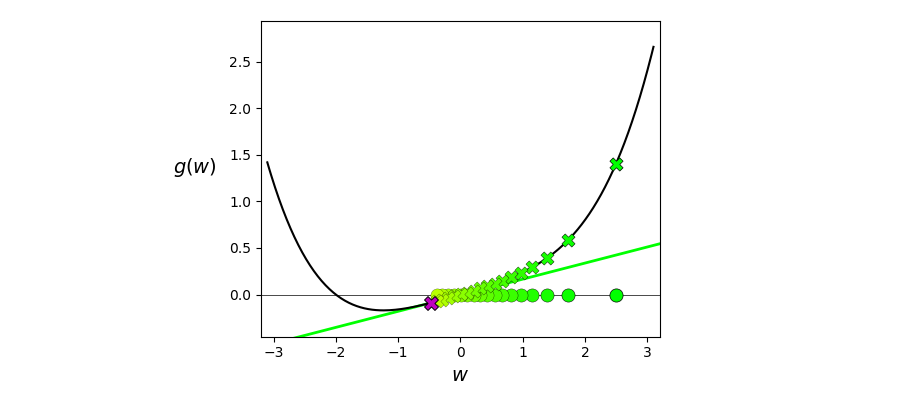
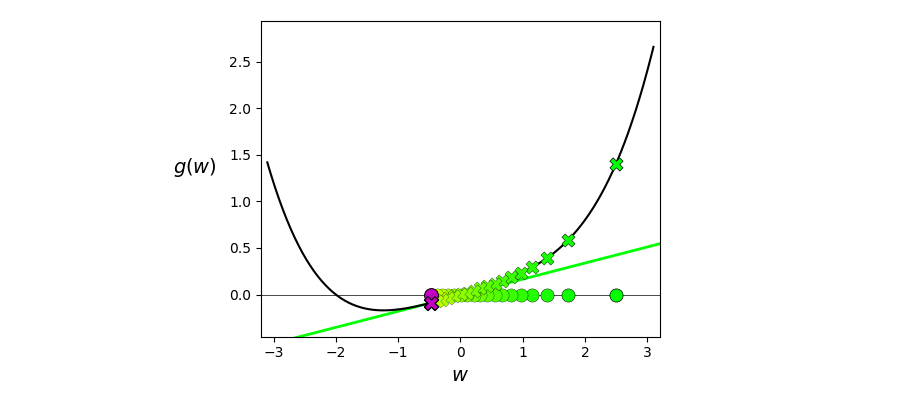
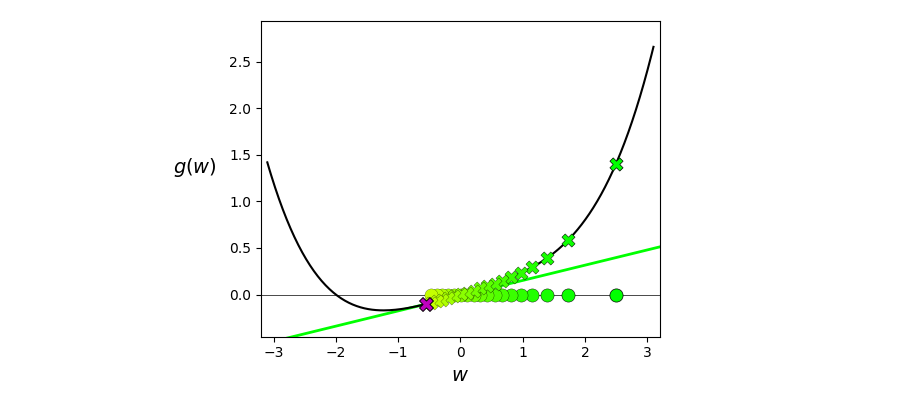
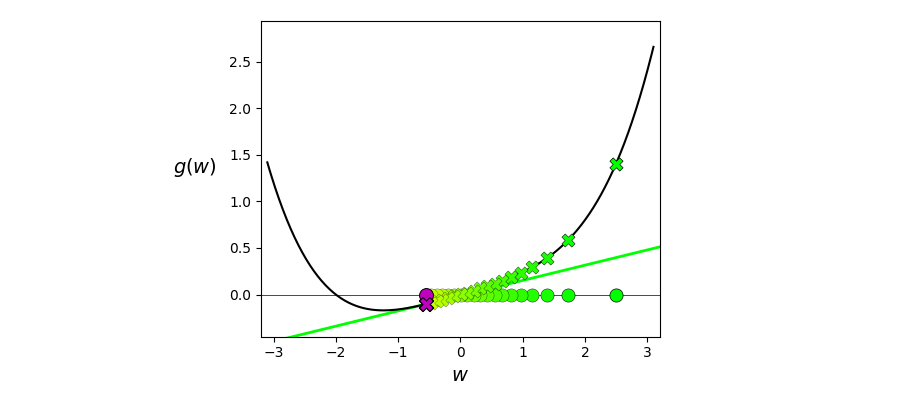
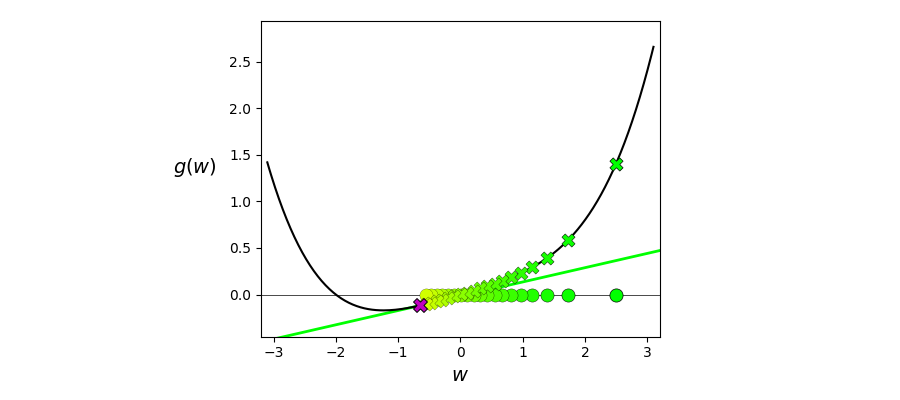
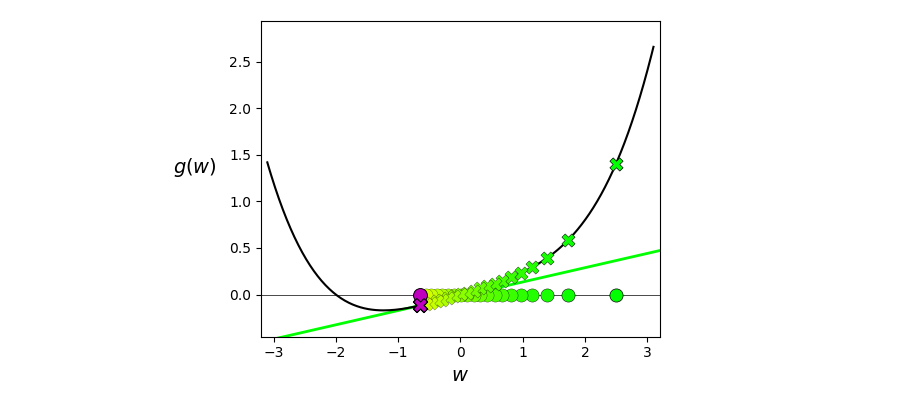
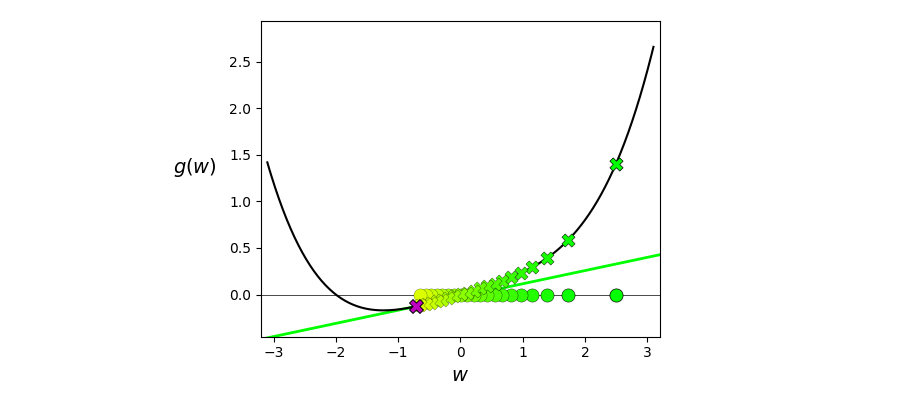
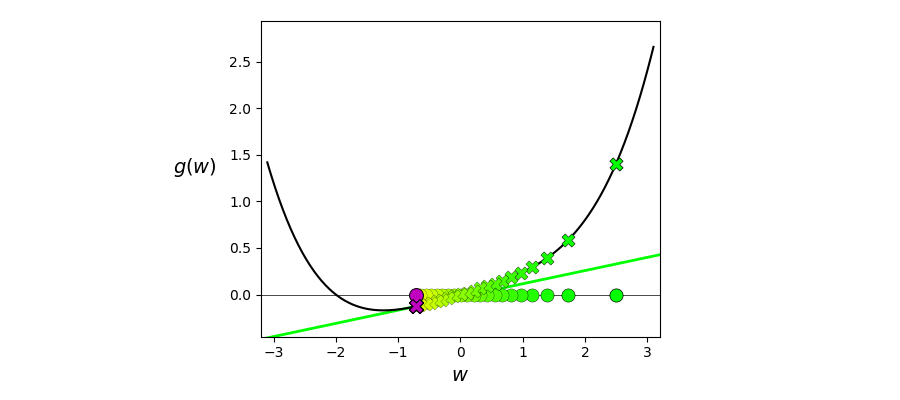
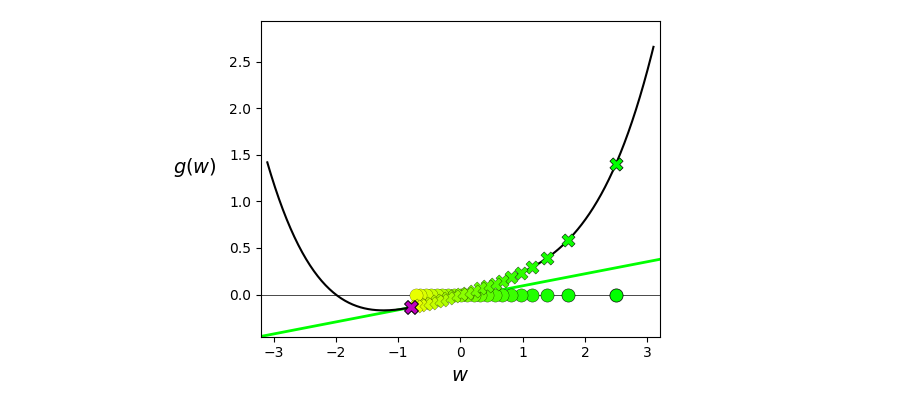
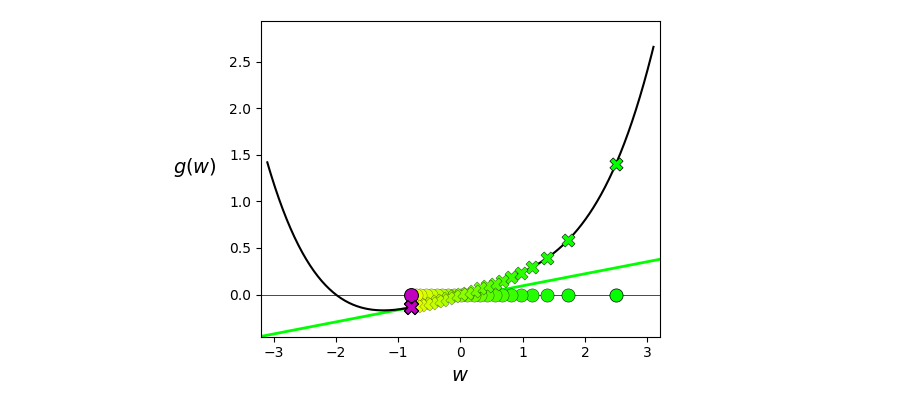
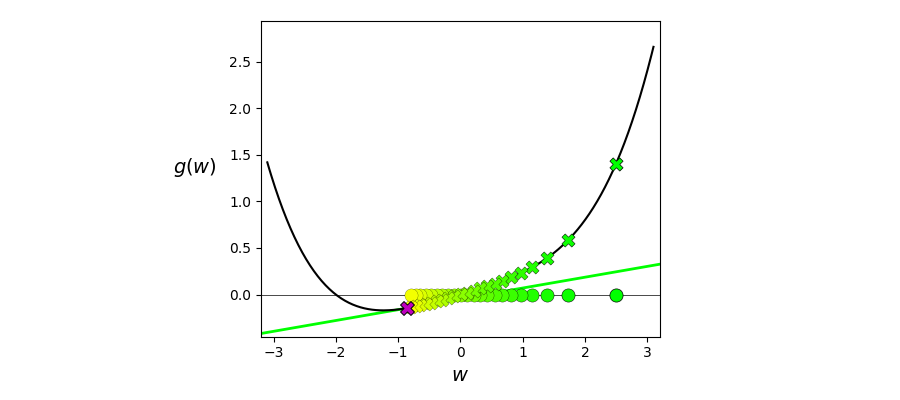
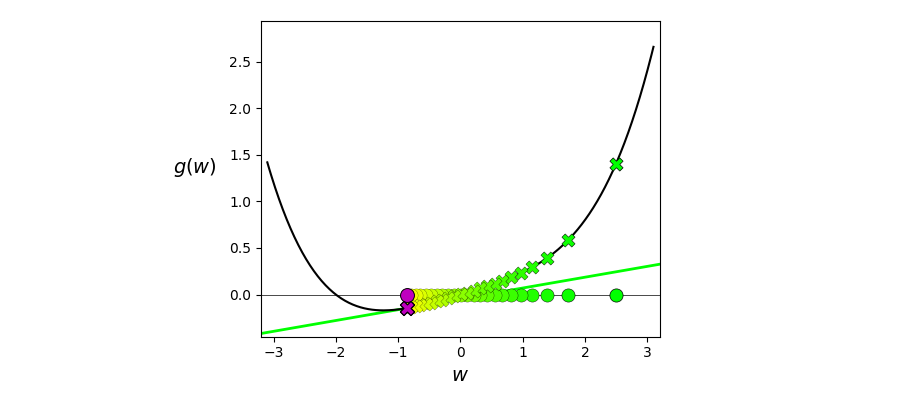
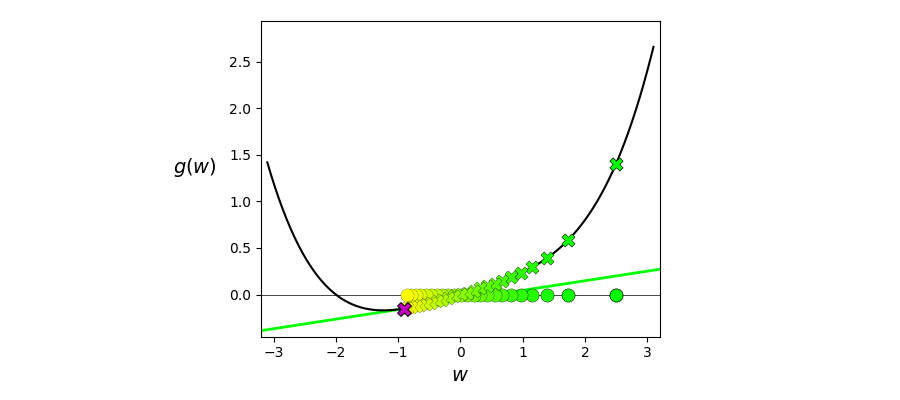
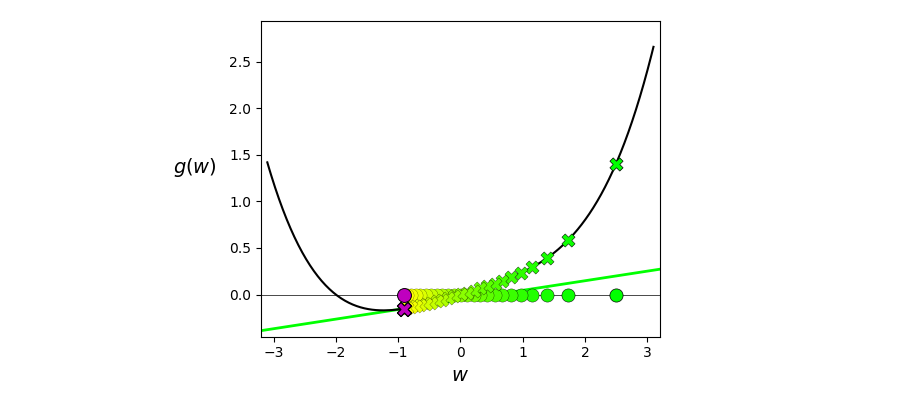
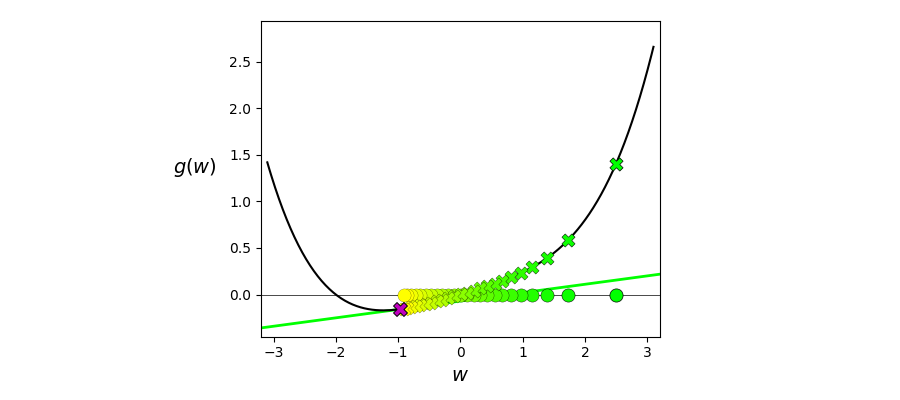
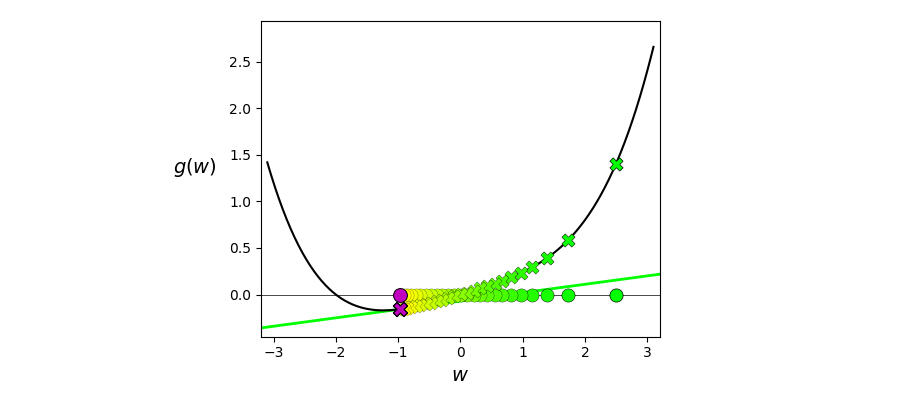
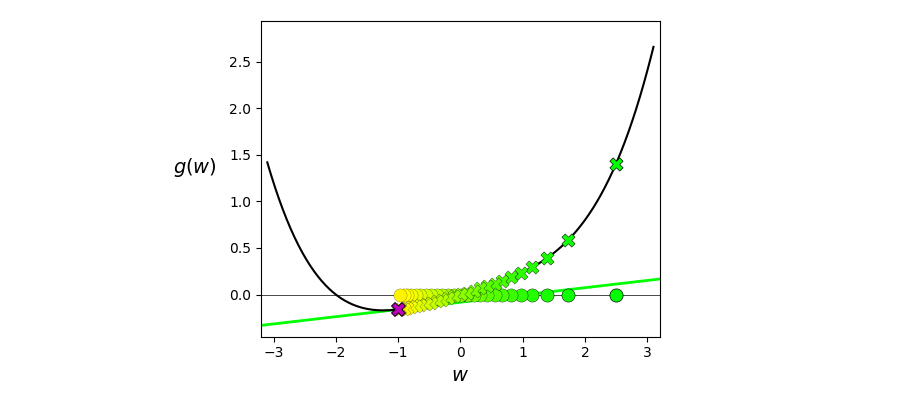
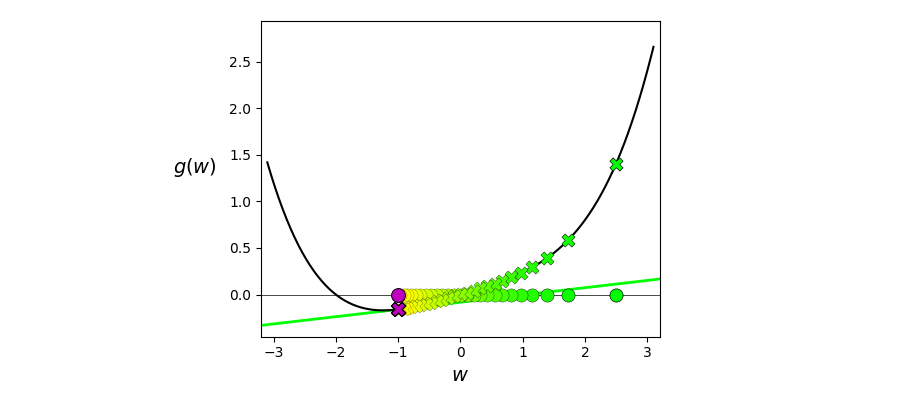
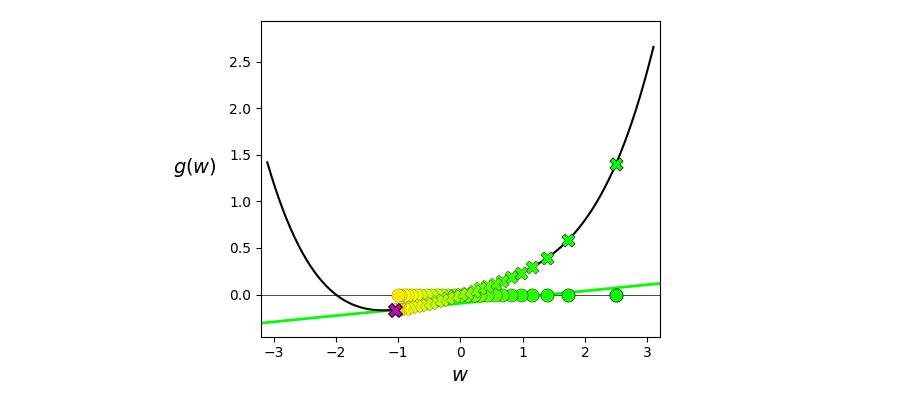
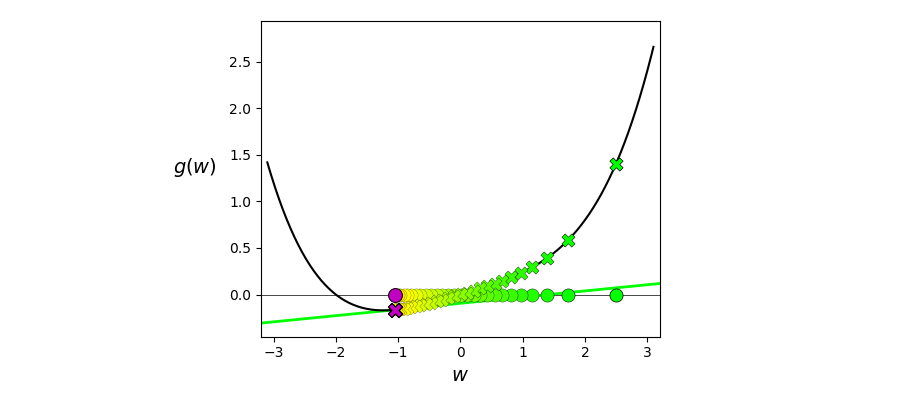
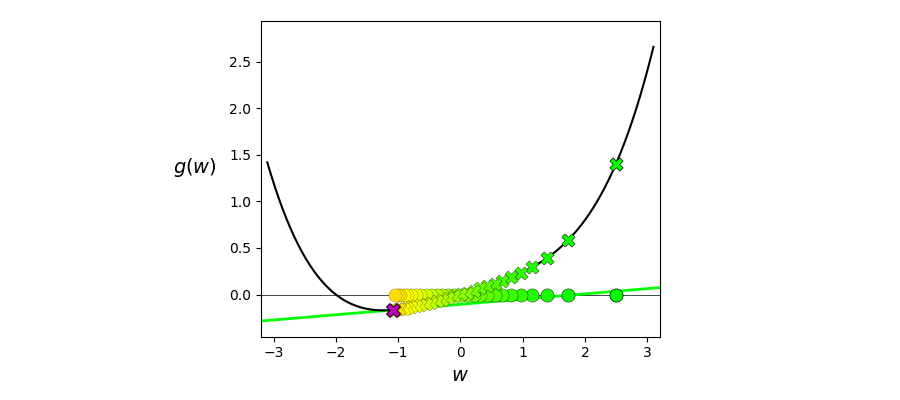
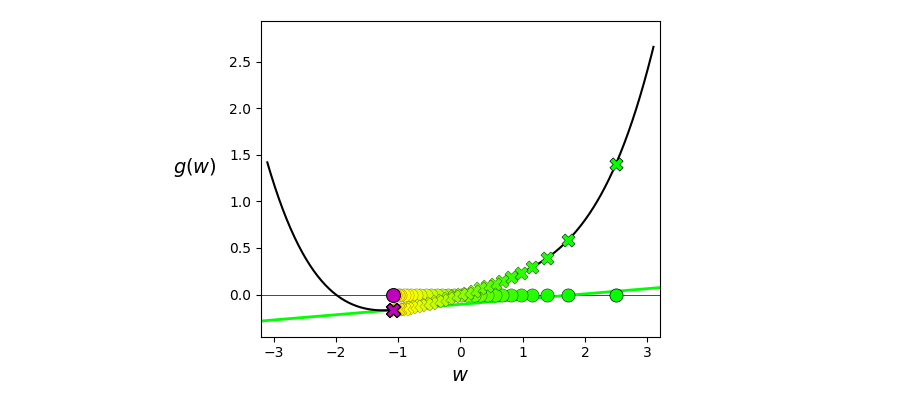
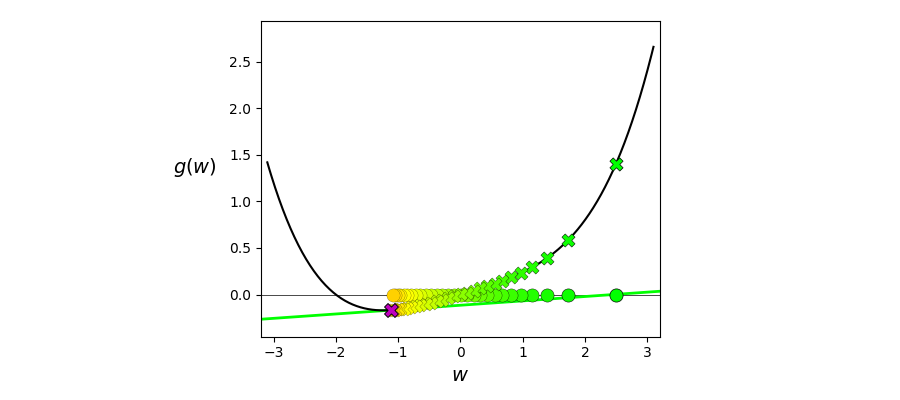
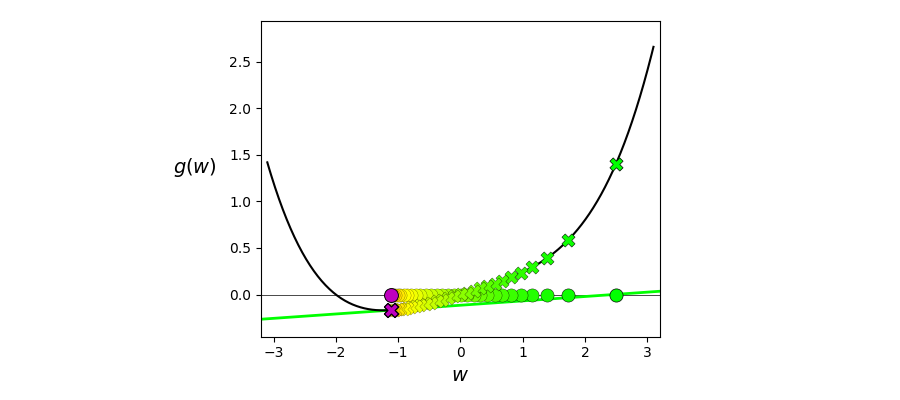
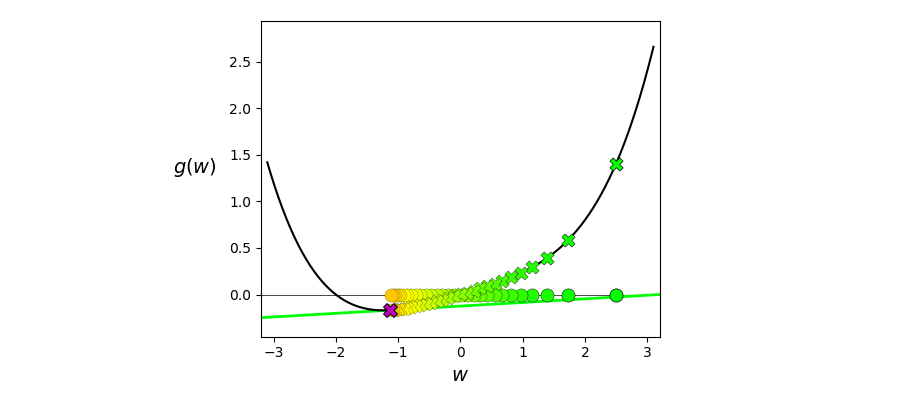
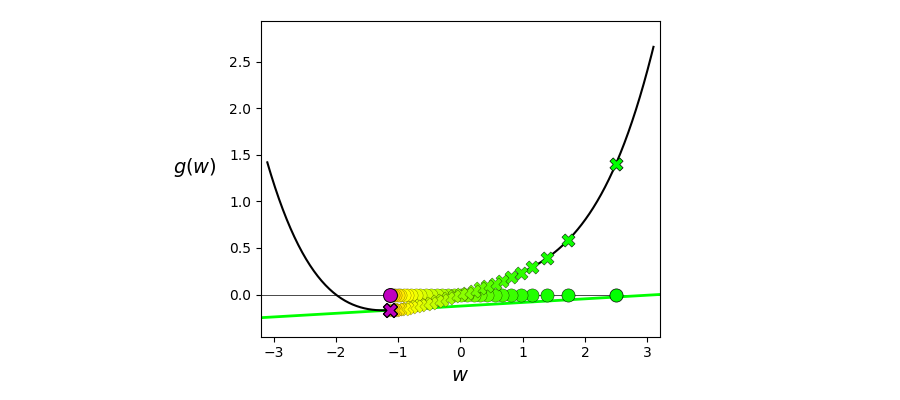
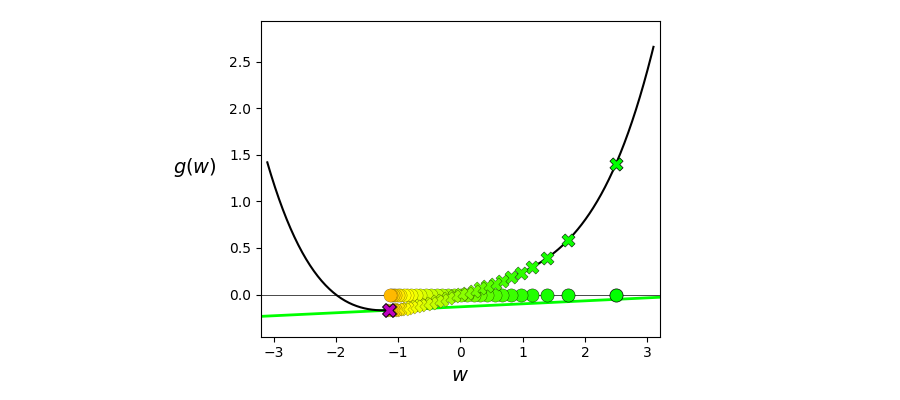
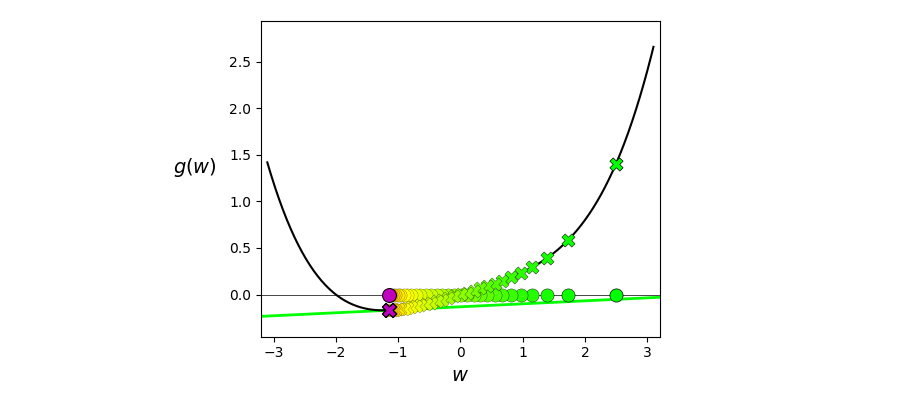
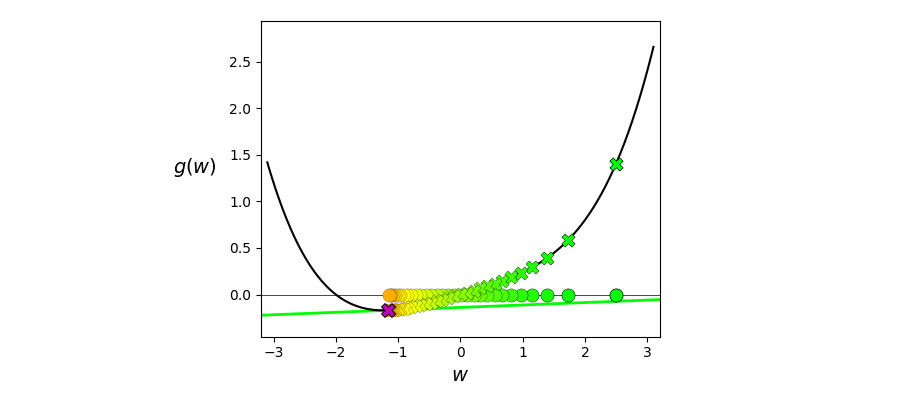
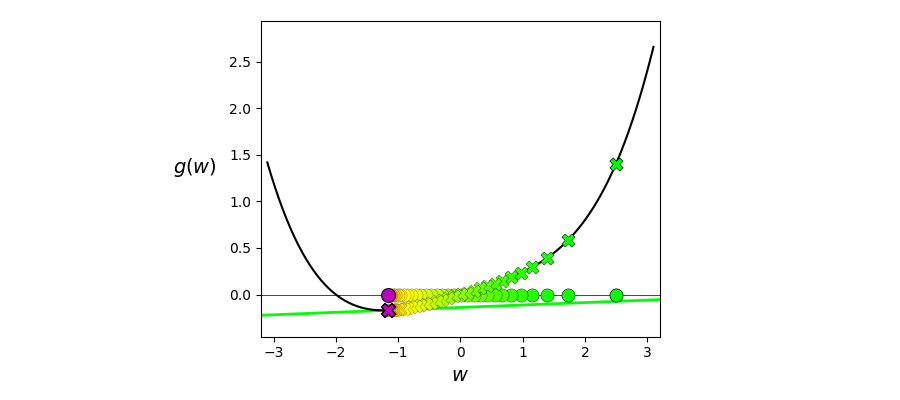
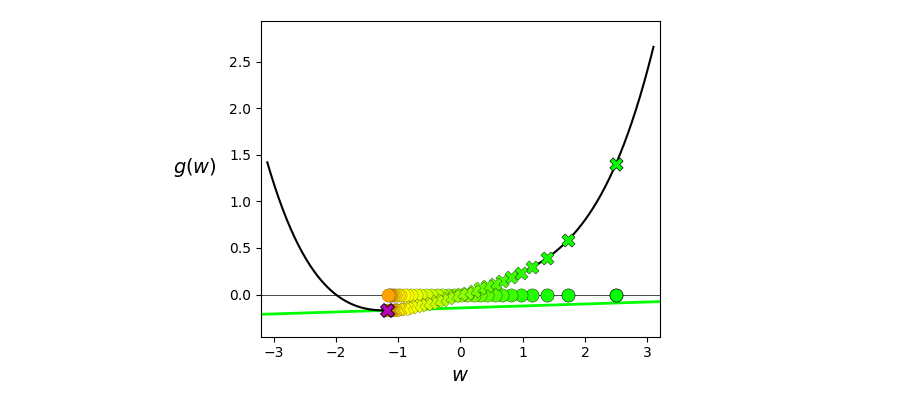
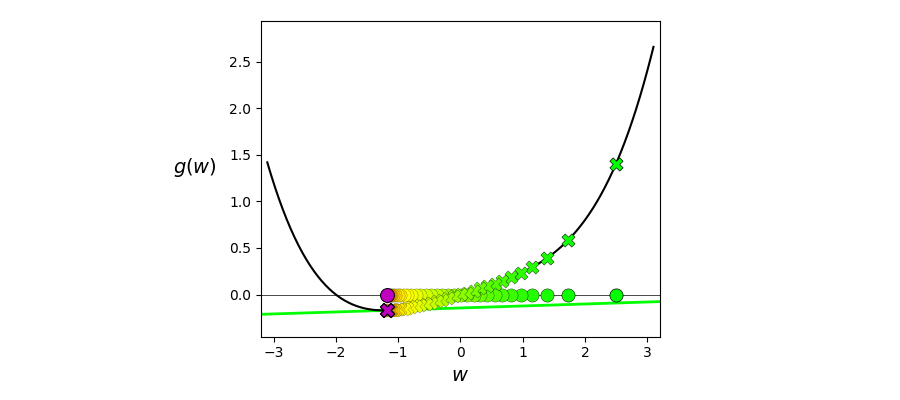
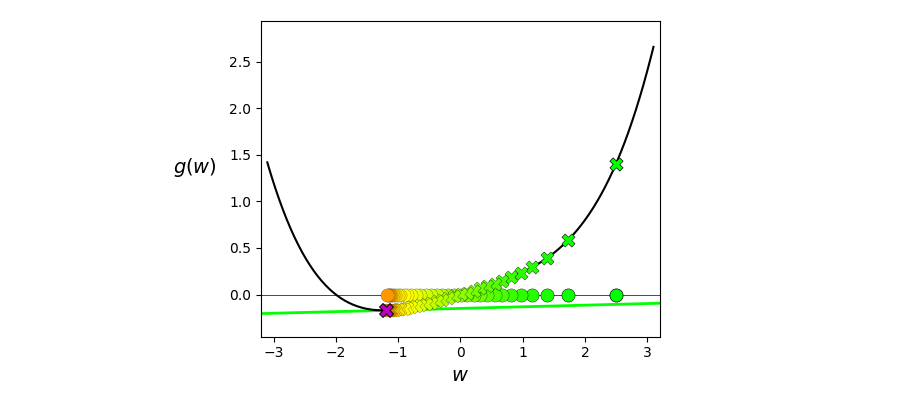
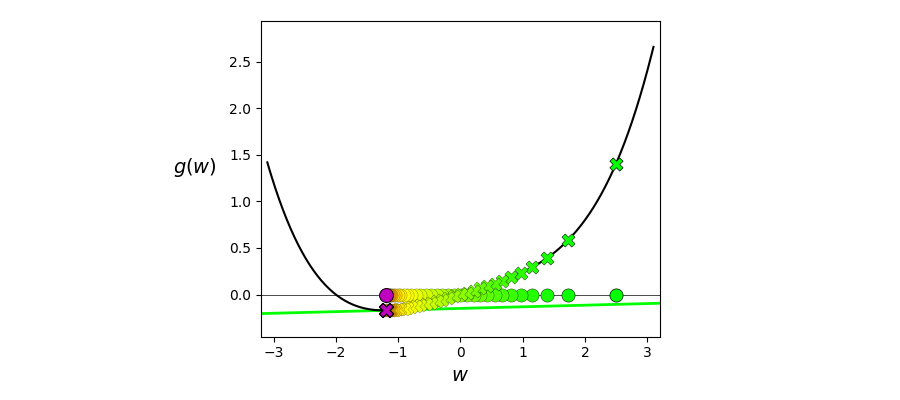
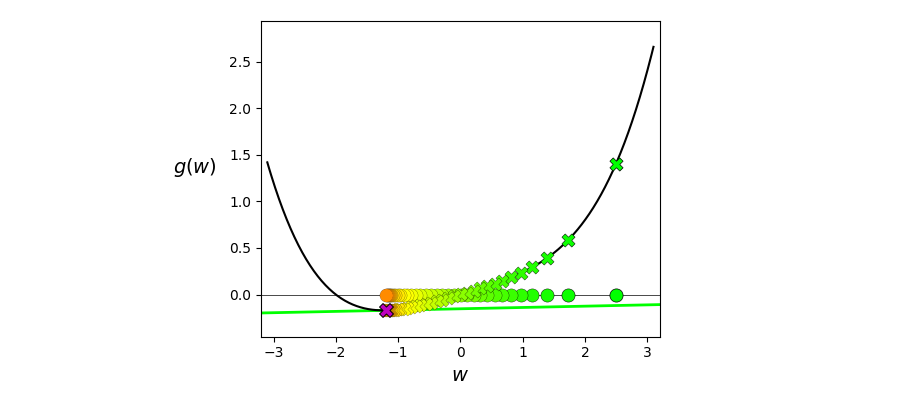
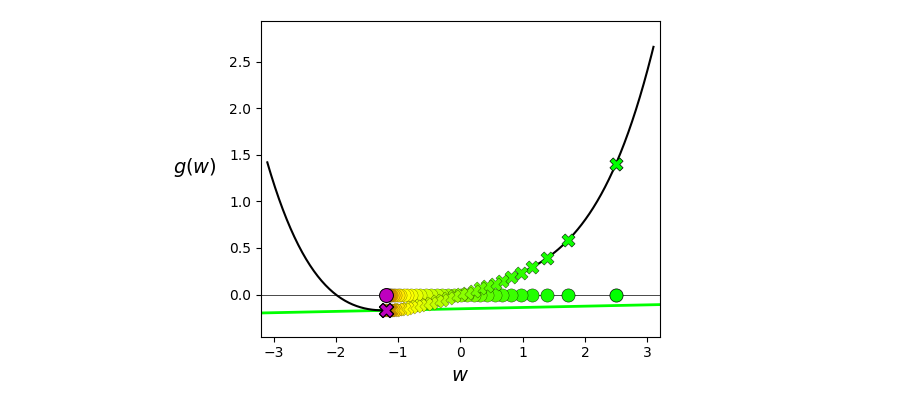
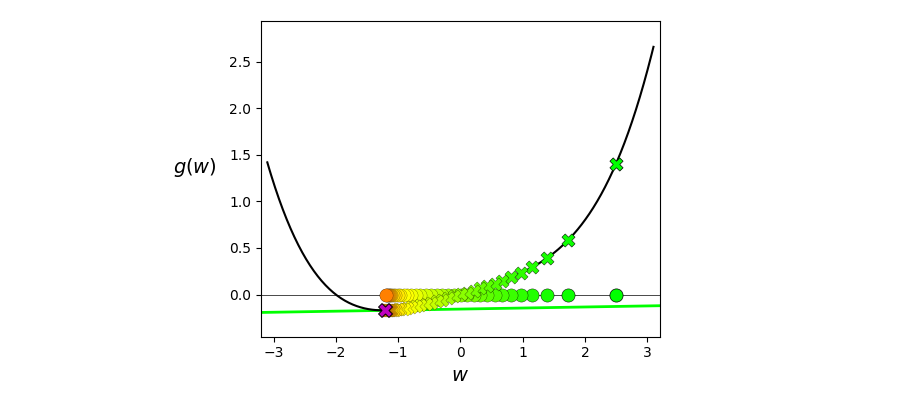
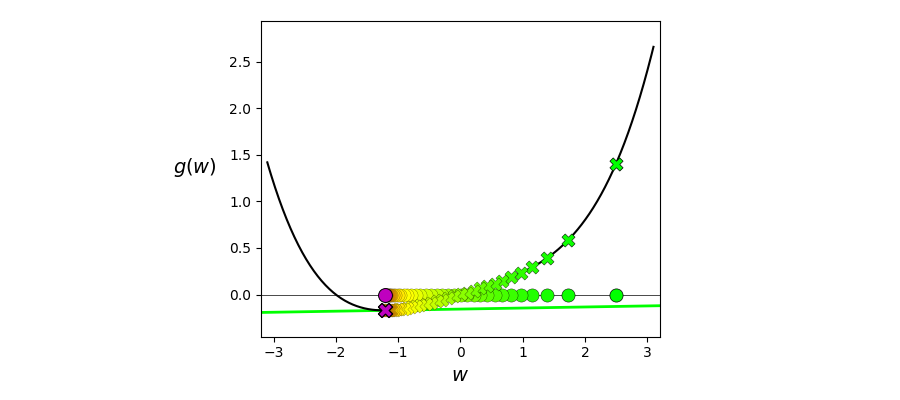
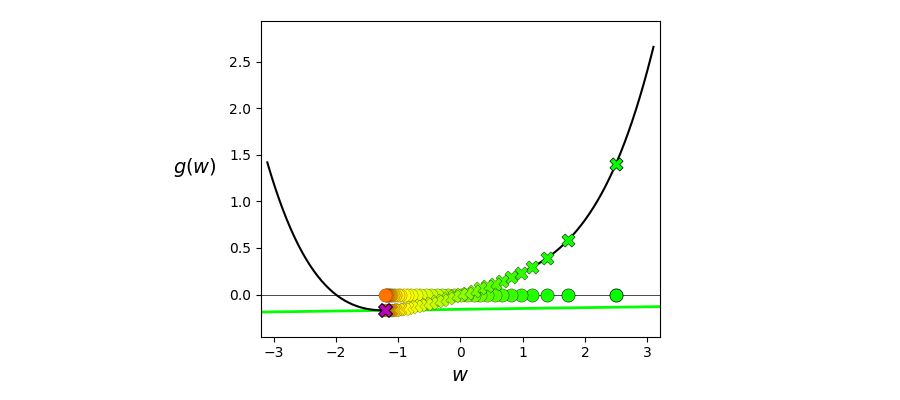
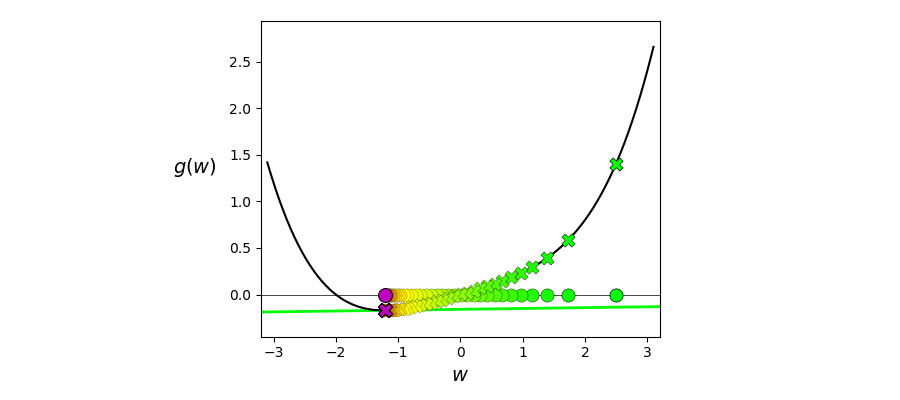
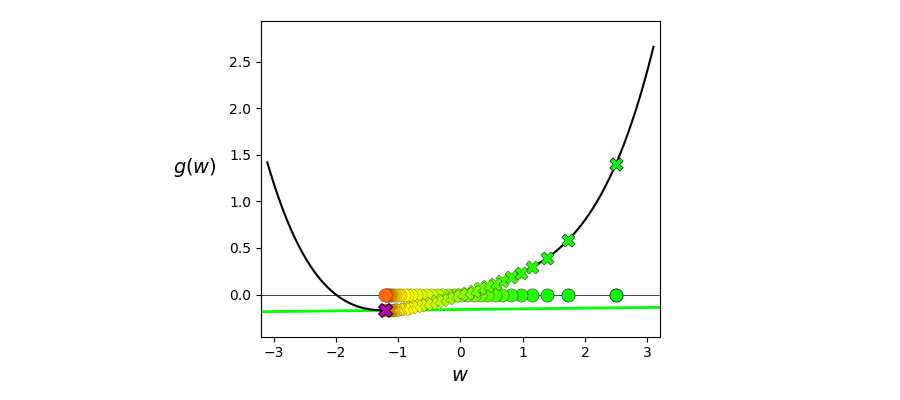
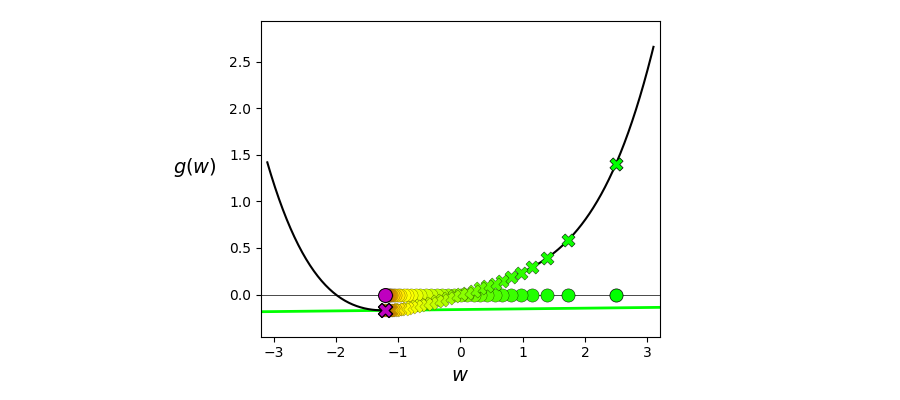
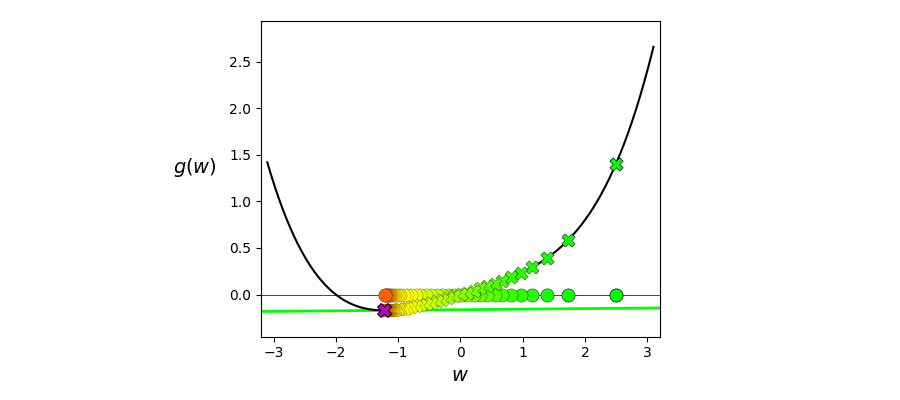
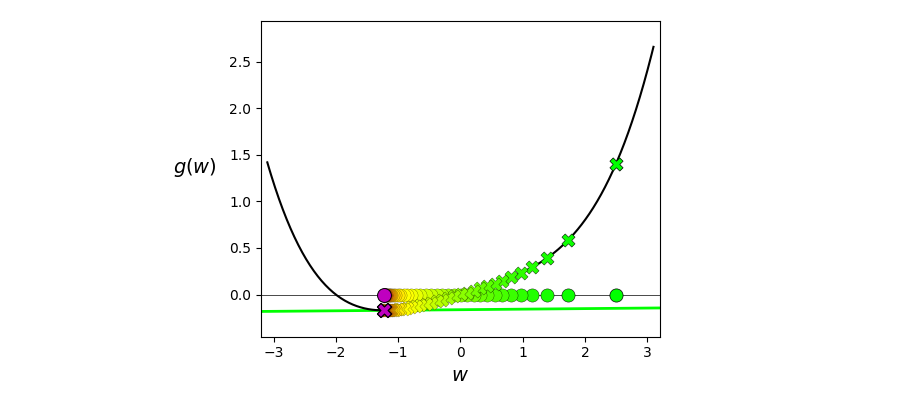
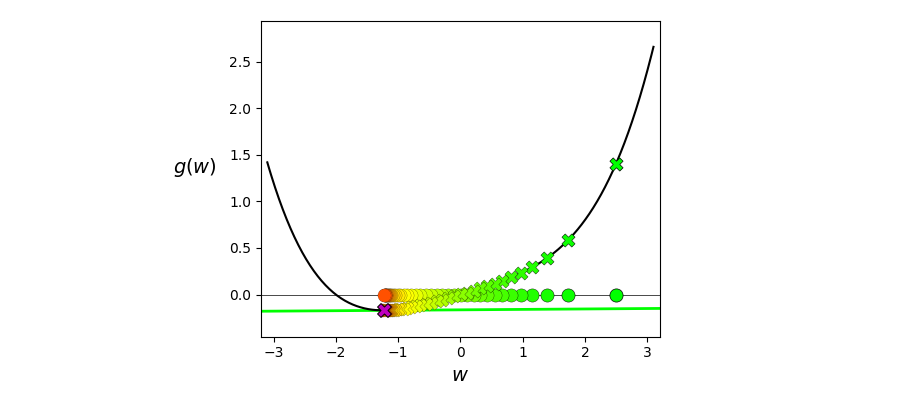
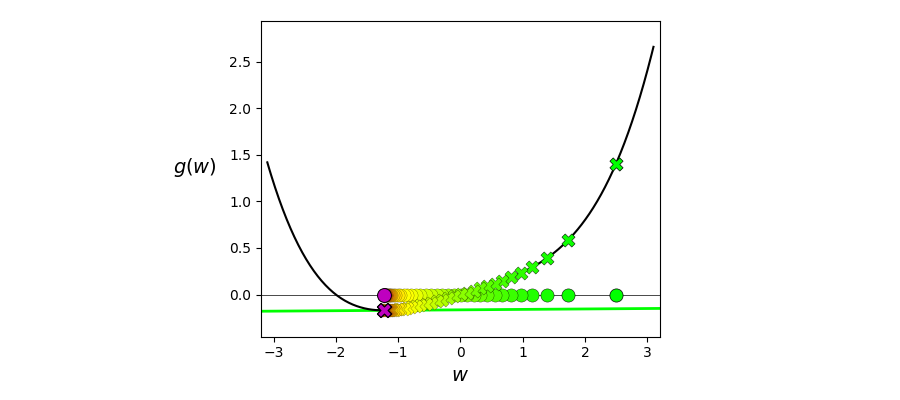
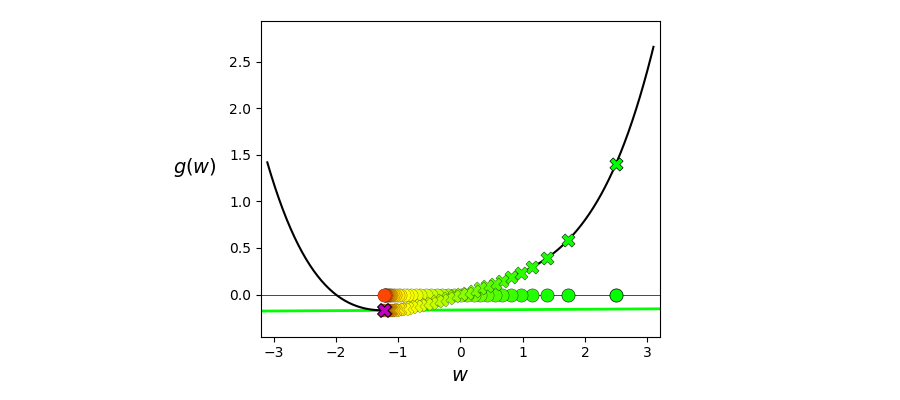
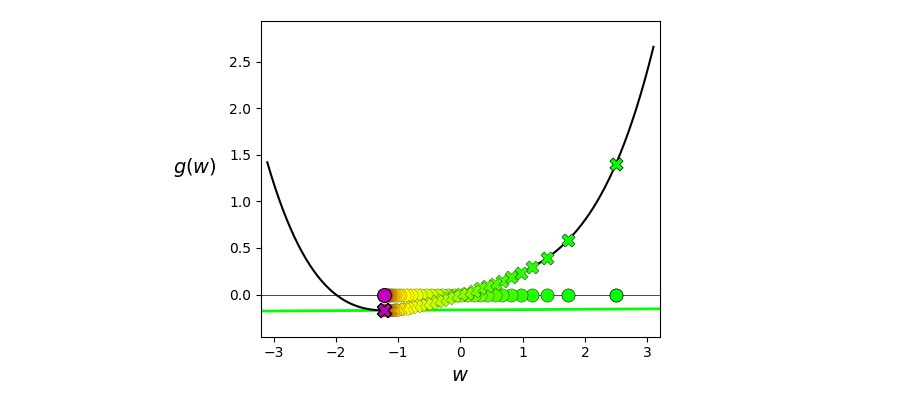
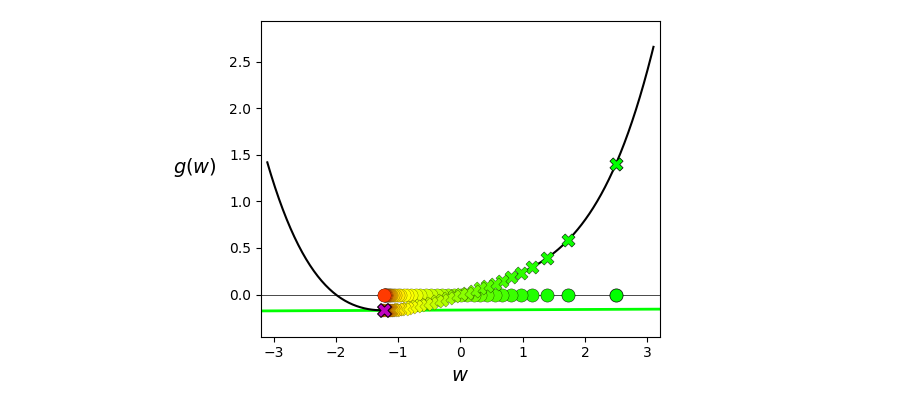
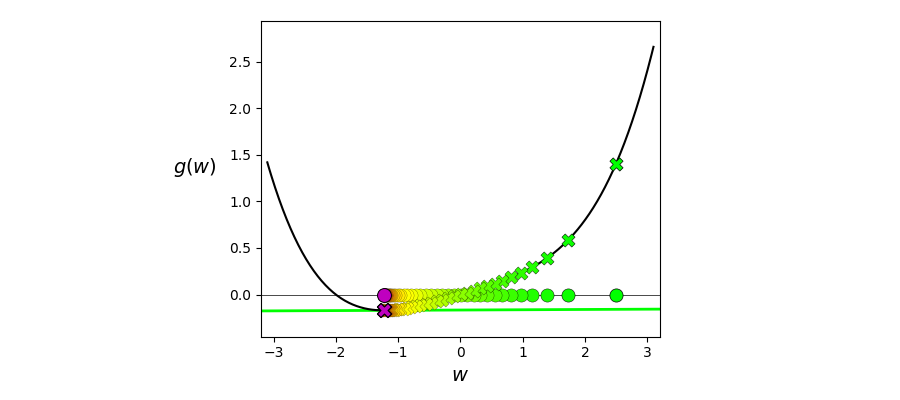
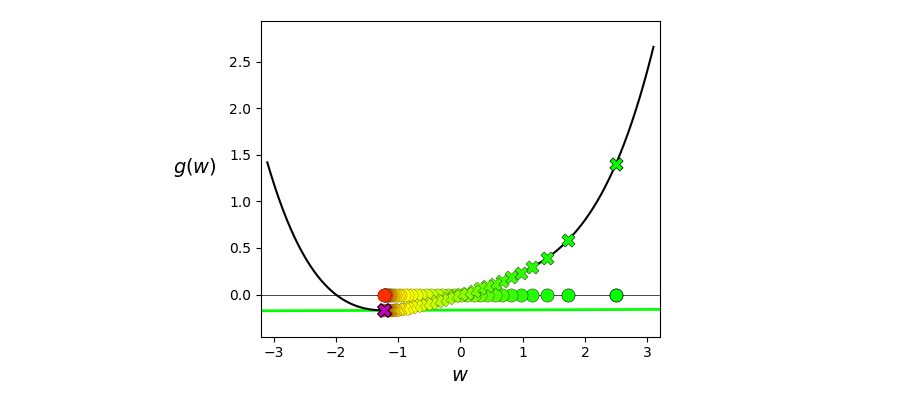
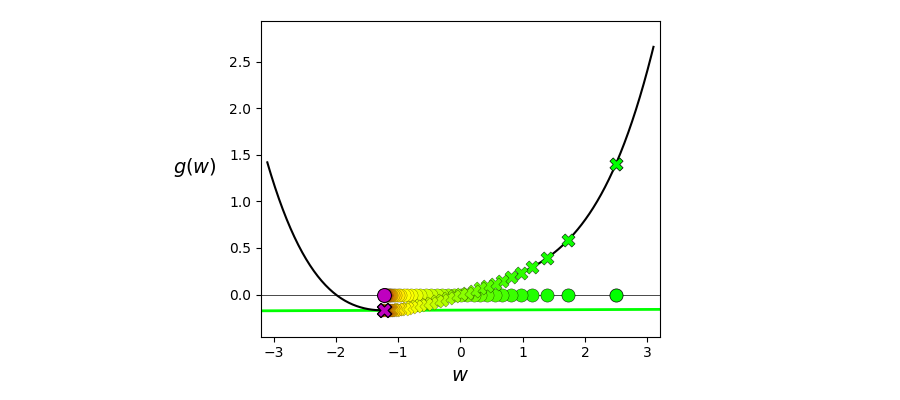
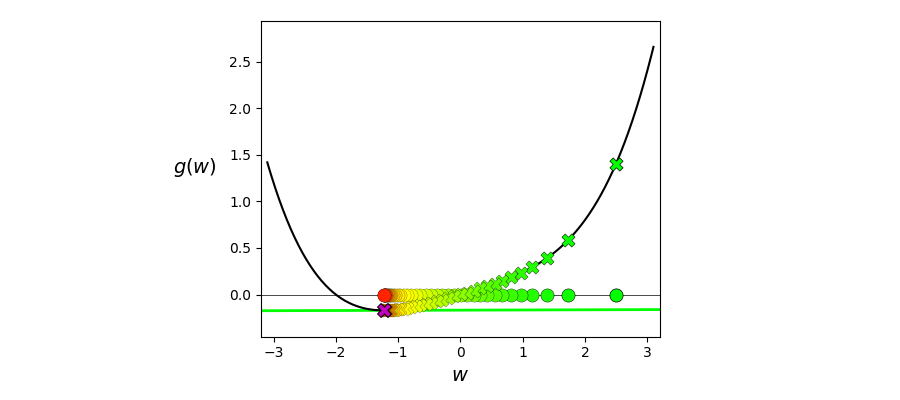
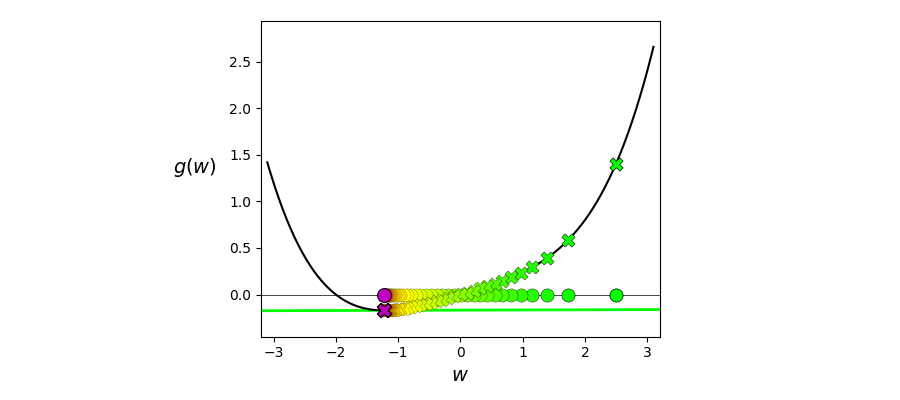
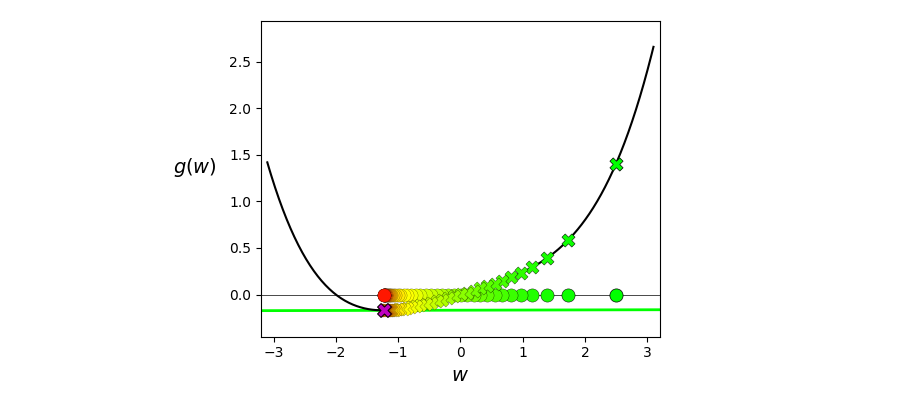
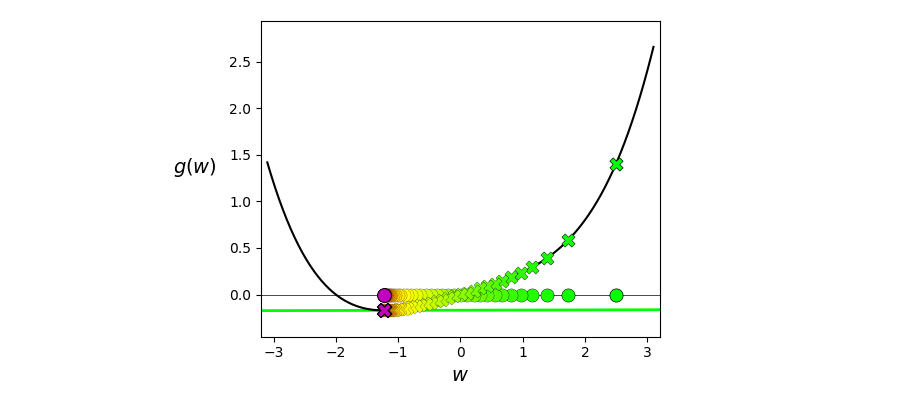
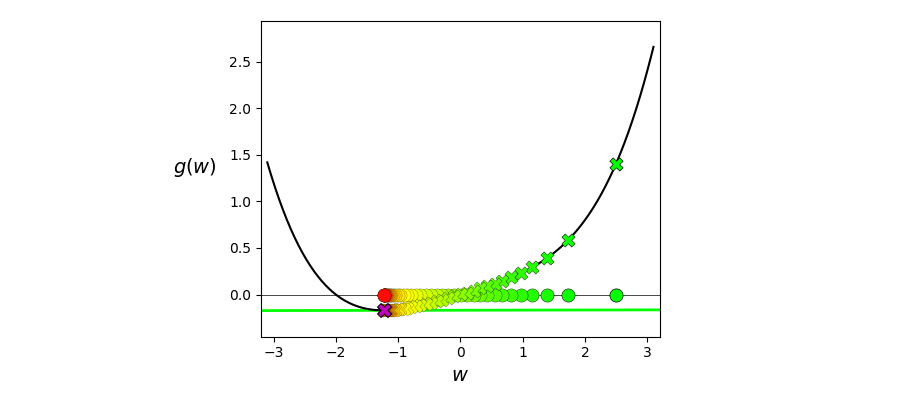
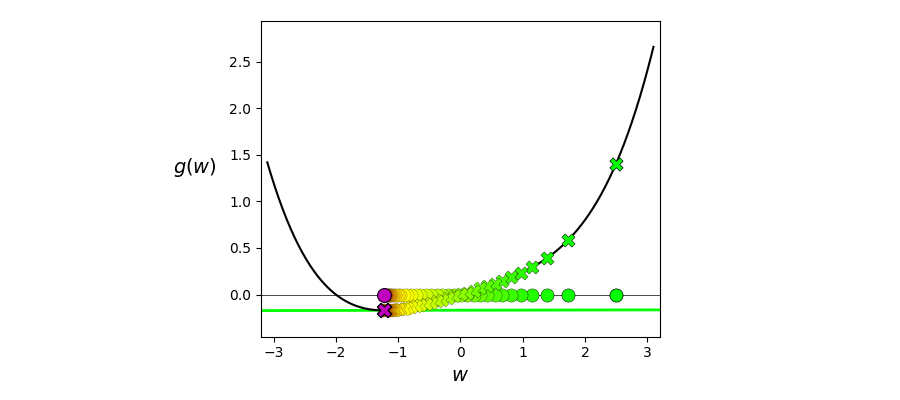
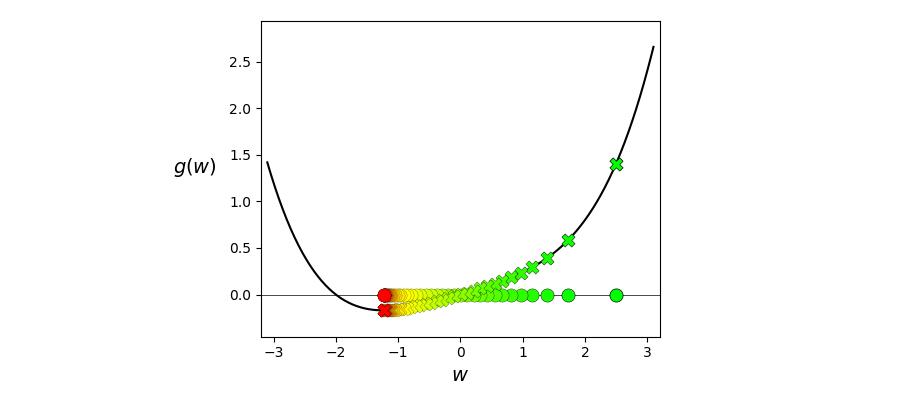

In [4]:
# what function should we play with?  Defined in the next line.
g = lambda w: 1/float(50)*(w**4 + w**2 + 10*w)   # try other functions too!  Like g = lambda w: np.cos(2*w) , g = lambda w: np.sin(5*w) + 0.1*w**2, g = lambda w: np.cos(5*w)*np.sin(w)

# run the visualizer for our chosen input function, initial point, and step length alpha
demo = optlib.gradient_descent_demos.visualizer();

demo.animate_2d(g=g, w_init = 2.5,steplength = 0.5,max_its = 45,version = 'unnormalized')

Notice in playing with the slider how the slope of the tangent line - the magnitude of the derivative - goes to zero as we approach the minimum.  This sort of behavior happens more generally as well whenever gradient descent encounters a *stationary point* of a function.

Note how the easily the gradient descent code can be written here when we use an automatic differentiation tool (here we use [autograd](https://github.com/HIPS/autograd)).  In the next Python cell we write out a vanilla gradient descent algorithm.  It involves just a few requisite initializations, the computation of the gradient, and the very simple descent loop.  The output is simply set as the weight providing the smallest evaluation during the process - whereas in the animation above we recorded every weight for visualization purposes. 

In [5]:
# using an automatic differentiator - like the one imported via the statement below - makes coding up gradient descent a breeze
from autograd import grad 

# gradient descent function - inputs: g (input function), alpha (steplength parameter), max_its (maximum number of iterations), w (initialization)
def unnormalized_gradient_descent(g,alpha,max_its,w):
    # compute the gradient of our input function - note this is a function too!
    gradient = grad(g)

    # run the gradient descent loop
    best_w = w        # weight we return, should be the one providing lowest evaluation
    best_eval = g(w)       # lowest evaluation yet
    for k in range(max_its):
        # evaluate the gradient
        grad_eval = gradient(w)

        # take gradient descent step
        w = w - alpha*grad_eval
        
        # return only the weight providing the lowest evaluation
        test_eval = g(w)
        if test_eval < best_eval:
            best_eval = test_eval
            best_w = w
            
    return best_w

 There are many other small variations one can make when coding up gradient descent as well, which we will describe as we go forward.  Nonetheless what we present above can be used for essentially any input function $g(w)$, not just the one we use here.

#### <span style="color:#a50e3e;">Example 5. </span>  Higher dimensional input is no problem for gradient descent

Since the gradient immediately supplies us with the descent direction gradient descent is not crippled by increasing input dimension, as we saw random local search was.  In the next Python cell we plot a run of (unnormalized) gradient descent on the multi-input quadratic function $g(w_1,w_2) = w_1^2 + w_2^2 + 2$.  We take 10 steps each using the steplength $\alpha = 0.2$.  Notice that this only helps define the length between steps, which is also dependent on the magnitude of the gradient at each step.

<IPython.core.display.Javascript object>


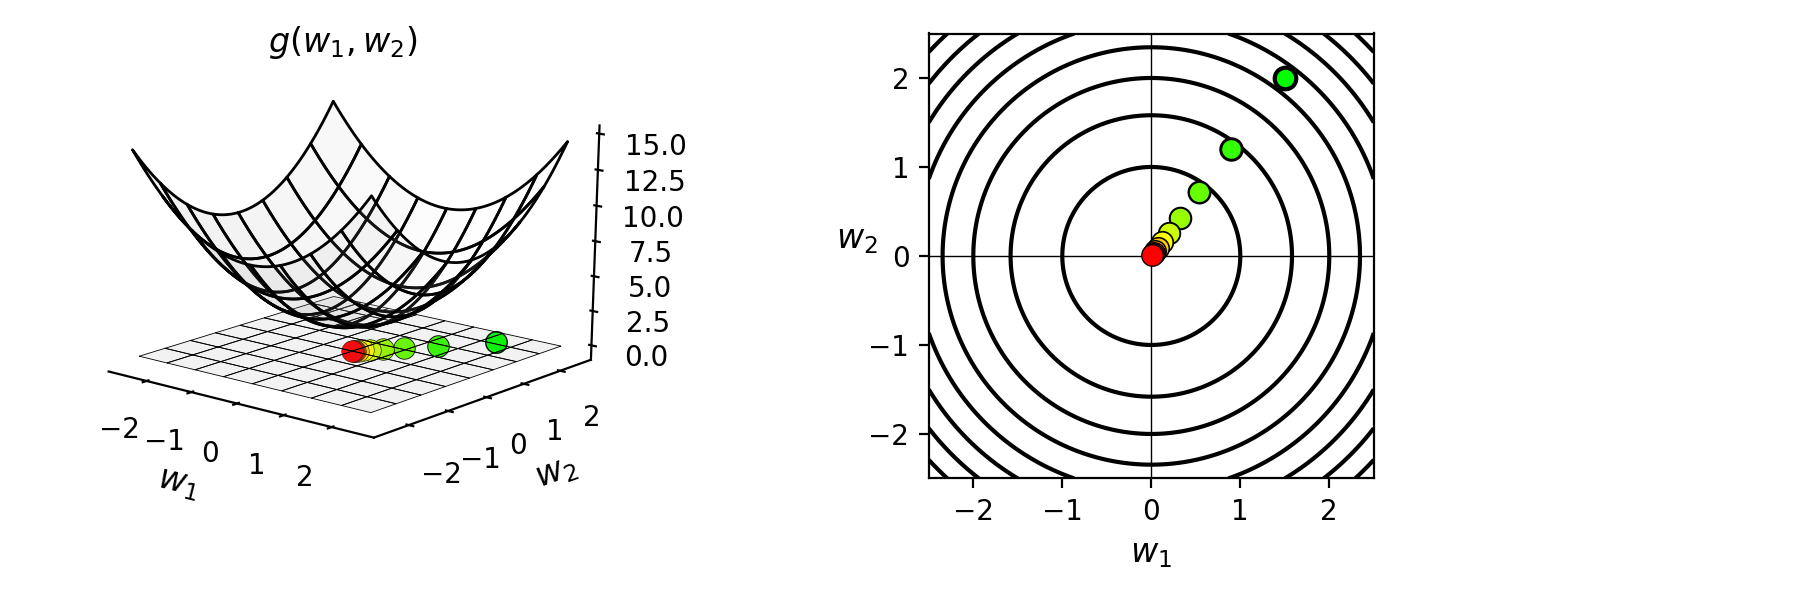

In [6]:
# what function should we play with?  Defined in the next line.
g = lambda w: np.dot(w.T,w) + 2

# run the visualizer for our chosen input function, initial point, and step length alpha
demo = optlib.gradient_descent_demos.visualizer();
w_init = [1.5,2]; max_its = 10; steplength = 0.2;

demo.visualize3d(g,w_init,steplength,max_its,version = 'unnormalized',wmax=max(w_init[0],w_init[1]))

In describing how the curse of dimensionality cripples random local search in Example 8 of the previous post we used the exceedingly simple quadratic function

$$
g(\mathbf{w}) = \mathbf{w}^T\mathbf{w}
$$

and saw how our chances of finding a descent direction at random drop exponentially as we increase the dimension of the input. In particular we saw an experiment where we began at the point $\mathbf{w}^{0}=\left[\begin{array}{cc}
1 \\ 0 \\ \vdots \\ 0\end{array}\right]$ and saw that by the time this vector reaches a length of $N = 25$ we find approximately zero directions of descent even when looking in $10,000$ random directions.

With gradient descent we need not seek out a descent direction, one is given to us directly using the gradient. Below we minimize the quadratic above using $N = 100$ dimensional input starting at the given $\mathbf{w}^0$ above as well.  We use the unnormalized gradient descent scheme, a steplength parameter of $\alpha = 0.1$, and 100 iterations.  Within this paradigm we reach a point extremely close to the true solution at the origin in less than a $10^{th}$ of a second. 

In [7]:
# define inputs to gradient descent function
g = lambda w: np.dot(w.T,w)
N = 100                        # input dimension
w_init = np.zeros((N,1))       # initial point
w_init[0] = 1
alpha = 0.1                    # steplength parameter
max_its = 100                  # maximum number of iterations

# use the gradient descent function defined in the previous example for our experiment above
t0 = time.time()
best_w = unnormalized_gradient_descent(g,alpha,max_its,w_init)
t1 = time.time()
print ('the best weights found are ' + str(np.linalg.norm(best_w)) + ' distance away from the true solution')
print ('total optimization time: ' + str(t1-t0)+ ' seconds') 

the best weights found are 2.03703597633e-10 distance away from the true solution
total optimization time: 0.04457497596740723 seconds


#### <span style="color:#a50e3e;">Example 6. </span>  Minimizing a function with many local minima using multiple runs of gradient descent

In this example we show what one may need to do in order to find the global minimum of a function using (normalized) gradient descent.  Using the function

$$
g(w) = \text{sin}(3w) + 0.1w^2
$$

we initialize two runs - at $w^0 = 4.5$ and $w^0 = -1.5$.  For both runs we use a steplength of $\alpha = 0.1$ fixed for all 10 iterations.  As can be seen by the result depending on where we initialize we may end up near a local or global minimum - here resulting from the first and second initialization respectively.  Here we illustrate the steps of each run as circles along the input axis with corresponding evaluations on the function itself as a similarly colored 'x'.  The steps of each run are colored green near the start of the run to red when a run halts.  Notice how - since we are using the normalized version of gradient descent - each step has precisely the length given by the steplength parameter $\alpha$.

<IPython.core.display.Javascript object>


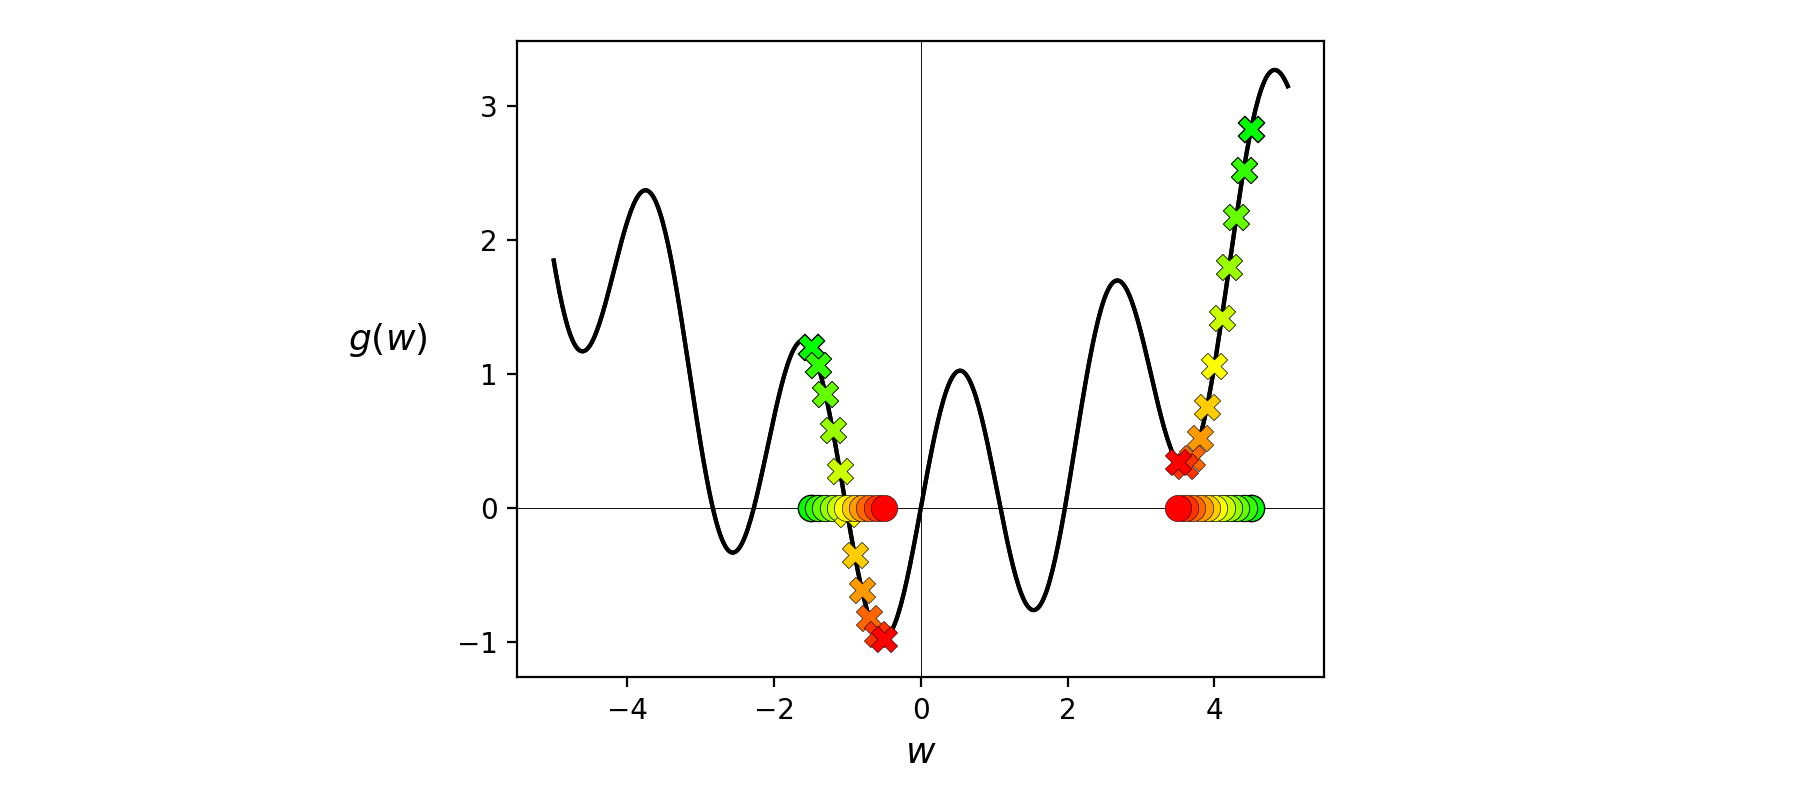

In [8]:
# what function should we play with?  Defined in the next line.
g = lambda w: np.sin(3*w) + 0.1*w**2

# run the visualizer for our chosen input function, initial point, and step length alpha
demo = optlib.gradient_descent_demos.visualizer();

demo.draw_2d(g=g, w_inits = [4.5,-1.5],steplength = 0.1,max_its = 10,version = 'normalized',wmin = -5,wmax = 5)

This example is indicative of what one may have to do when applying (normalized) gradient descent to minimizing highly non-convex functions with many local minima: run the algorithm several times with different initializations, and pick the best result (the best local minimum one can find).  Of course not all non-convex functions present this challenge - when the local minima of a non-convex are either are equal (e.g., when $g(w) = \text{sin}(w)$) or when they are all fairly close in value to a global minimum, a single run ending near any local minimum can suffice for practical applications (like many types of deep neural networks).

To illustrate this idea we can run the same experiment above using the similar function $g(w) = \text{sin}(3w) + 0.01w^2$.  Here the local minima - at least on the interval $[-5,5]$ - are all vey close to the global minimum and so may be adequate.

<IPython.core.display.Javascript object>


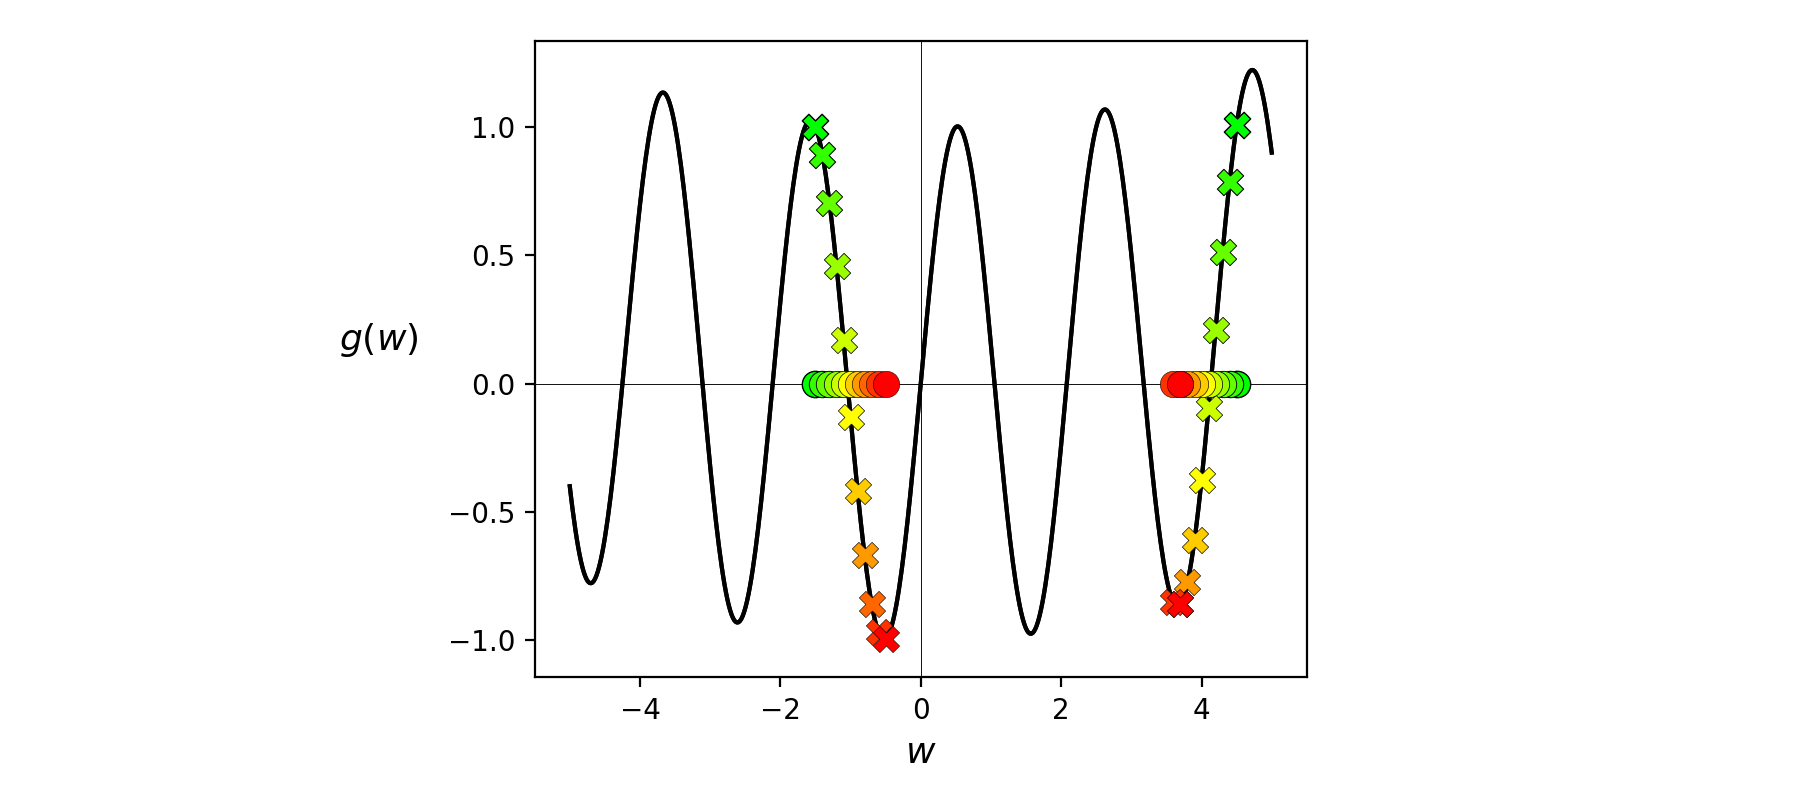

In [9]:
# what function should we play with?  Defined in the next line.
g = lambda w: np.sin(3*w) + 0.01*w**2

# run the visualizer for our chosen input function, initial point, and step length alpha
demo = optlib.gradient_descent_demos.visualizer();

demo.draw_2d(g=g, w_inits = [4.5,-1.5],steplength = 0.1,max_its = 10,version = 'normalized',wmin = -5,wmax = 5)

Note that one can quickly adjust the Python code given in Example 4 to make a normalized gradient descent function.  Using the notation from that example, all we need to do is adjust a few lines in the descent loop itself.  First we need to compute the magnitude of the gradient as follows

In [ ]:
# evaluate the gradient
grad_eval = grad(w)

# compute norm of gradient
grad_norm = np.linalg.norm(grad_eval)

Next, since we will be dividing by this quantity, we need to make sure it is not so small in magnitude (or exactly 0) that it creates a 'division by zero ' error.  If the value is too small we pick a direction at random and move in its direction according to the steplength parameter $\alpha$.

In [ ]:
# check that magnitude of gradient is not too small, if yes pick a random direction to move
if grad_norm == 0:
    # pick random direction and normalize to have unit legnth
    grad_eval = 10**-6*np.sign(2*np.random.rand(len(w)) - 1)
    grad_norm = np.linalg.norm(grad_eval)
    grad_eval /= grad_norm

All together with these simple adjustments to the unnormalized gradient descent function we have the analgous normalized version below.

In [11]:
# using an automatic differentiator - like the one imported via the statement below - makes coding up gradient descent a breeze
from autograd import grad 

# gradient descent function - inputs: g (input function), alpha (steplength parameter), max_its (maximum number of iterations), w (initialization)
def normalized_gradient_descent(g,alpha,max_its,w):
    # compute the gradient of our input function - note this is a function too!
    gradient = grad(g)

    # run the gradient descent loop
    best_w = w        # weight we return, should be the one providing lowest evaluation
    best_eval = g(w)       # lowest evaluation yet
    for k in range(max_its):
        # evaluate the gradient, compute its length
        grad_eval = gradient(w)
        grad_norm = np.linalg.norm(grad_eval)
        
        # check that magnitude of gradient is not too small, if yes pick a random direction to move
        if grad_norm == 0:
            # pick random direction and normalize to have unit legnth
            grad_eval = 10**-6*np.sign(2*np.random.rand(len(w)) - 1)
            grad_norm = np.linalg.norm(grad_eval)
            grad_eval /= grad_norm
    
        # take gradient descent step
        w = w - alpha*grad_eval
        
        # return only the weight providing the lowest evaluation
        test_eval = g(w)
        if test_eval < best_eval:
            best_eval = test_eval
            best_w = w
            
    return best_w

#### <span style="color:#a50e3e;">Example 7. </span>  To descend or not to descend - that is the question: the steplength parameter and convergence / divergence of gradient descent

At each step of the random local search method if we lucked onto a descent direction we took a step in its direction since - by design - it always led to a point lower on the function.  If we could find no such point we stayed put.  With gradient descent things are slightly different, in particular the descent direction and whether or not we descend in the function itself when taking a step in this direction are de-coupled.

At each step of gradient descent we *always* have a descent direction - this is defined explicitly by the negative gradient itself, we need not have to search one out as with the random local search method (which becomes almost impossible to do in higher input dimensions).  This is a huge plus.  However whether or not we descend in the function when taking this step depends completely on how far along it we travel, or in other words our choice of the steplength parameter.  This is not to say that the general steplength rules we have seen so far - i.e., fixing the steplength to a hand-tuned constant for all steps or using a diminishing steplength like $\alpha = \frac{1}{k}$ - are not perfectly applicable for use with gradient descent - they absolutely are.  In fact there are even more choices for the selecting steplengths for gradient descent we will see later.  But it is important to keep in mind the fact that just because we move in a descent *direction* with gradient descent does not mean that we always descend in the function itself when using a fixed or diminishing steplength rule.

We illustrate this general principle in the next Python cell using a slider widget to animate what the first 5 steps of (unnormalized) gradient descent look like applied to the simple quadratic function $g(w) = w^2$.  Here we initialize at $w^0 = -2.5$ using a fixed steplength parameter rule.  We show the function evaluation at each step of the algorithm (not the step itself, which is in the input space), and color them from green at the start of the run to red when the last step is taken.  As you move the slider from left to right each frame shows a different run with a slightly increased fixed steplength value  $\alpha$ used for all steps, whose numerical value is printed above the left panel.  In the beginning the steplength is extremely small - so small that we do not descend very much at all.  On the other end of the spectrum however, when we set 

In the right panel we show what a *cost function plot* that simply plots the evaluation of $g$ at each step of gradient descent run sequentially in order from the evaluation of the initial point $g\left(w^0\right)$ on the left, to the final step evaluation $g\left(w^5\right)$.  We also color these points from green (start of run) to red (end of run).  The cost function plot is a very useful tool in general - particularly for multi-input functions that take in $N > 2$ inputs (so most machine learning / deep learning problems) which we cannot directly visualize - for understanding the behavior any local search method like gradient descent. 

In [ ]:
# what function should we play with?  Defined in the next line., nice setting here is g = cos(2*w), w_init = 0.4, alpha_range = np.linspace(2*10**-4,1,200)
g = lambda w: w**2

# create an instance of the visualizer with this function
demo = optlib.grad_descent_steplength_adjuster_2d.visualizer()

# run the visualizer for our chosen input function, initial point, and step length alpha
w_init = -2.5
steplength_range = np.linspace(10**-5,1.5,150)
max_its = 5
demo.animate_it(w_init = w_init, g = g, steplength_range = steplength_range,max_its = max_its,tracers = 'on',version = 'unnormalized')

When the steplength parameter is set too large, and the sequence of evaluations begins to rocket out of control, the sequence of steps is said to *diverge*.  This sort of example suggests that it is good practice when implementing gradient descent (employing  hand-tuned fixed steplength or diminishing steplength rule) one should usually, at each step, make sure to also keep track of the best weights seen thus far in the process (i.e., those providing the lowest function value).  This is because the final weights resulting from the run may not in fact provide the lowest value depending on function / steplength parameter setting / etc.,

We illustrate this same concept for a function taking in two inputs - here the simple sinusoid $g\left(w_1,w_2\right) = \text{sin}(w_1)$

In [ ]:
# what function should we play with?  Defined in the next line., nice setting here is g = cos(2*w), w_init = 0.4, alpha_range = np.linspace(2*10**-4,1,200)
g = lambda w: np.sin(w[0])

# create an instance of the visualizer with this function
demo = optlib.grad_descent_steplength_adjuster_3d.visualizer()

# run the visualizer for our chosen input function, initial point, and step length alpha
w_init = [1,0]; alpha_range = np.linspace(2*10**-4,5,100); max_its = 10; view = [10,120];
demo.animate_it(g = g,w_init = w_init,alpha_range = alpha_range,max_its = max_its,view = view)

## 1.4 Comparing normalized and unnormalized gradient descent schemes

From a mathematical point of view the difference between unnormalized and normalized gradient descent is trivial - they describe the same idea, and either one can be quickly seen to be mathematically equivalent to the other by correct choice of steplength.  For example, setting $\alpha \longleftarrow \frac{\alpha}{{\left\Vert \nabla g(\mathbf{w}^{\,k-1}) \right\Vert_2 }}$ turns the unnormalized gradient descent step $\mathbf{w}^{\,k} = \mathbf{w}^{\,k-1} - \alpha \nabla g\left(\mathbf{w}^{\,k-1}\right)$ into a normalized one.  So why go to the trouble of mentioning both normalized and unnormalized gradient descent methods if they are mathematically the same?

Because *practically speaking* depending on the function being minimized one version of gradient descent can be much easier to employ effectively than another.  In this subsection we will explore the practical advantages and disadvantages of each version of gradient descent.  In particular we will see the following via examples below. 

>  **1. Behavior on generic convex functions:** Generally speaking the *unnormalized* method is more convenient for use with convex functions (e.g., linear and logistic regression, support vector machines). 
With many smooth convex cost functions the length of each step is tied directly to the magnitude of the gradient, which is advantageous.

>  **2.  Behavior on generic non-convex functions:** Generally speaking the *normalized* is more convenient for use with non-convex functions (like e.g., *deep neural networks*), because here the fact that the length of each step of the unnormalized version is tied directly to the magnitude of the gradient is disadvantageous.  By completely controlling the length of each step via the steplength parameter, the normalized version can be made to more easily pass over saddle points and through flat regions of a function.


> **3.  Stepsize parameter selection and infinitesimally:**   For a general function gradient descent reaches points infinitesimally close to local minima only when the length of each step diminishes as the algorithm progresses (at least eventually).  In the case of normalized gradient descent this implies that the steplength parameter $\alpha$ should be diminishing in size if such a solution is needed.  This must be done as well with unnormalized gradient descent when applied to certain convex functions (that are not completely smooth, e.g., the absolute value function) as well.  However for smooth convex functions with unnormalized gradient descent since the length of each step is dependent on the length of the gradient such behavior is possible even with a steplength parameter $\alpha$ fixed for all iterations.

#### <span style="color:#a50e3e;">Example 5. </span>  (unnormalized) gradient descent and convex functions

We start by examining a run of unnormalized gradient descent applied to the simple quadratic function

$$
g(w) = w^2
$$

beginning at the point $w^0 = -1.75$.  We fix the steplength parameter $\alpha = 0.1$ and take 30 steps with the method.  What is produced is a now familiar looking animation with a slider widget allowing you to see how gradient descent behaves during this run - moving the slider from left to right animates each step of the process, the color of each step turning from green to red as the process nears completion.


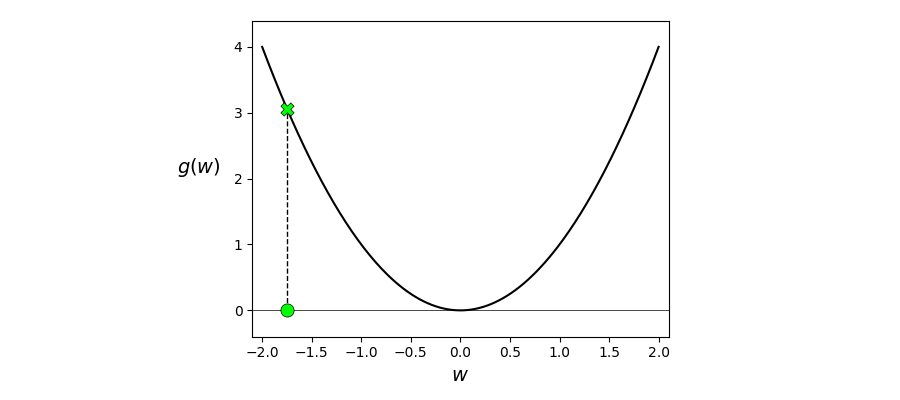
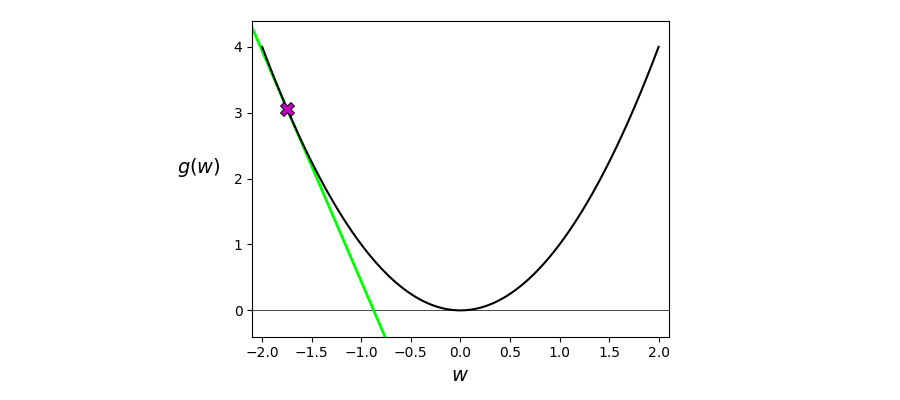
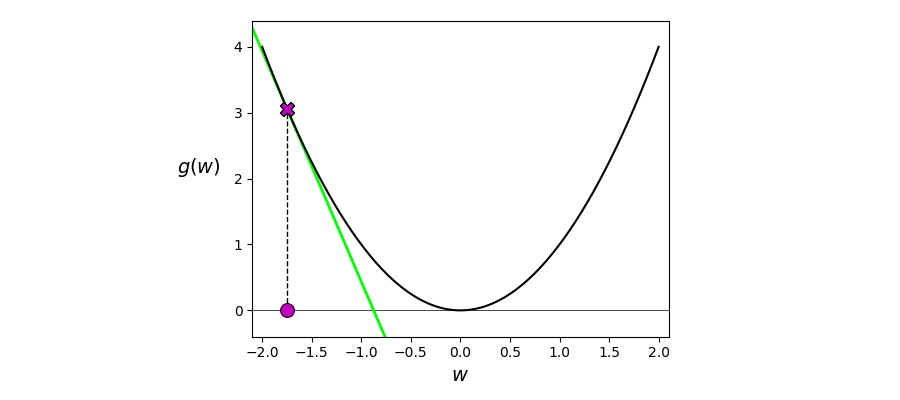
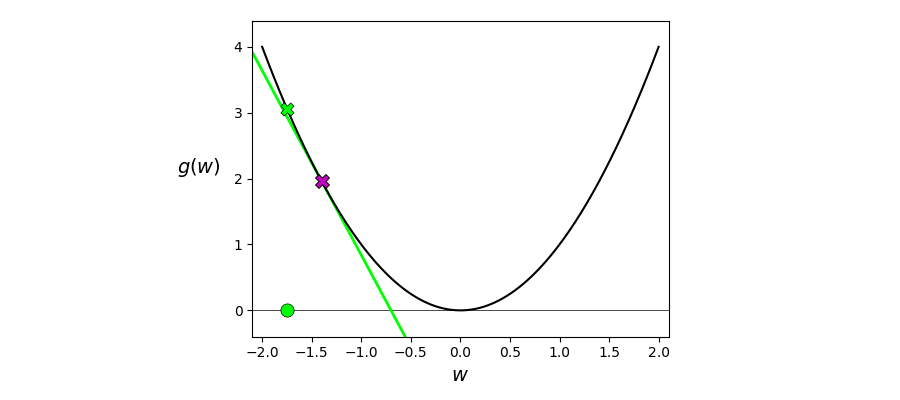
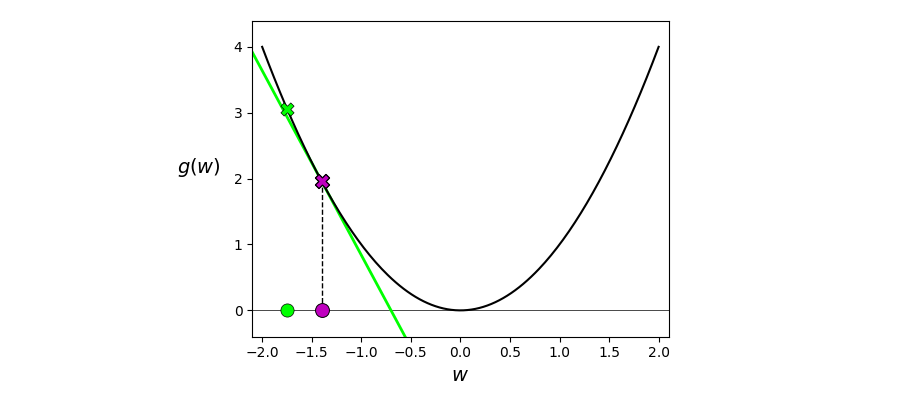
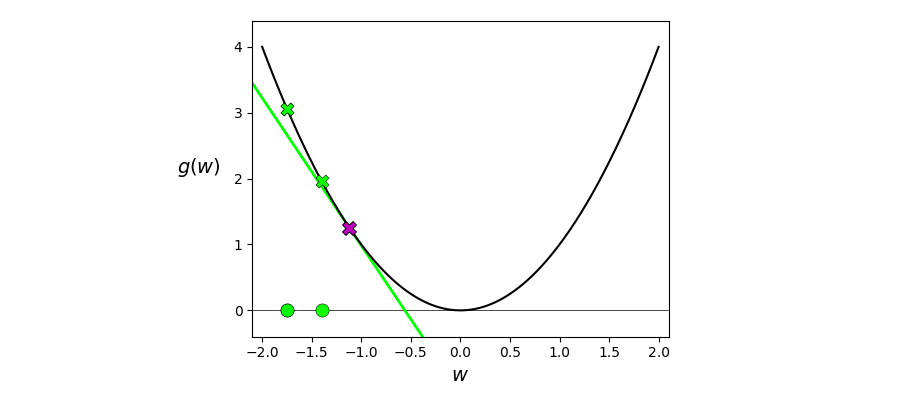
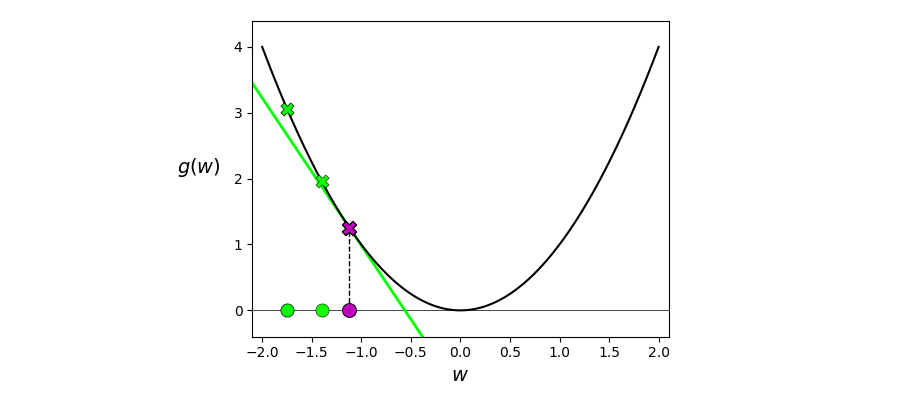
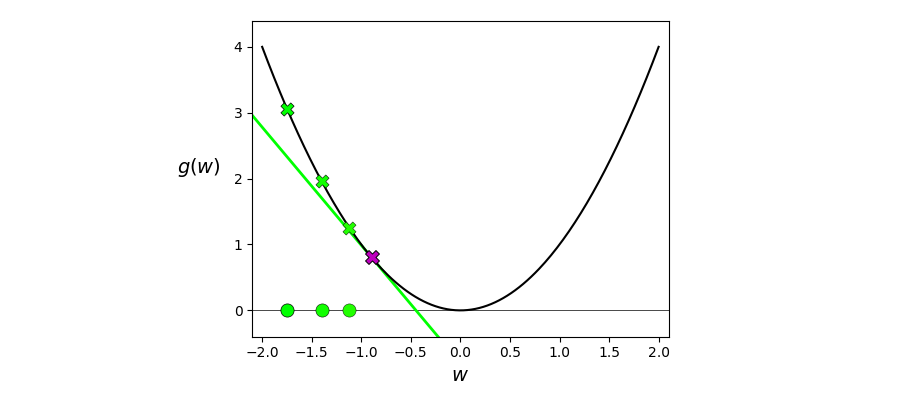
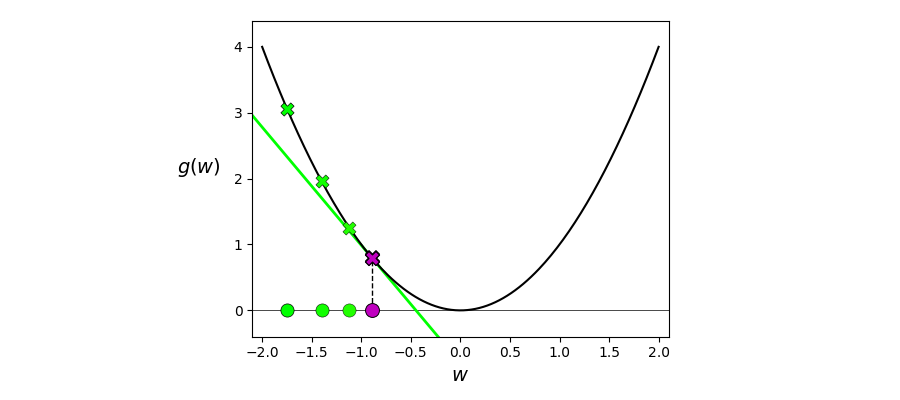
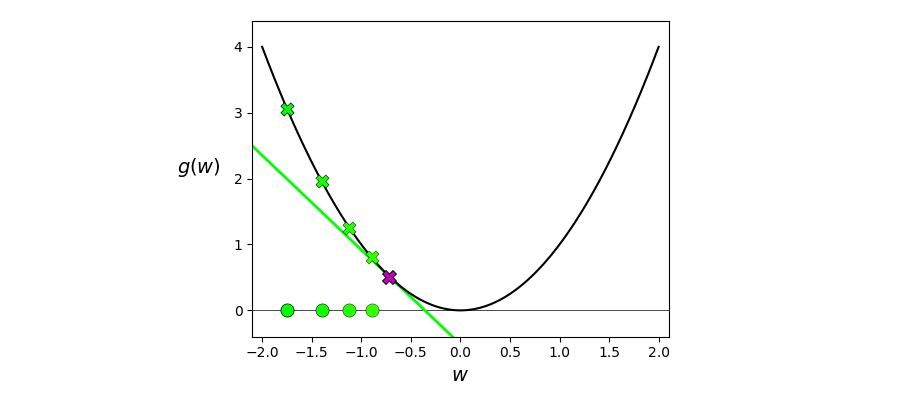
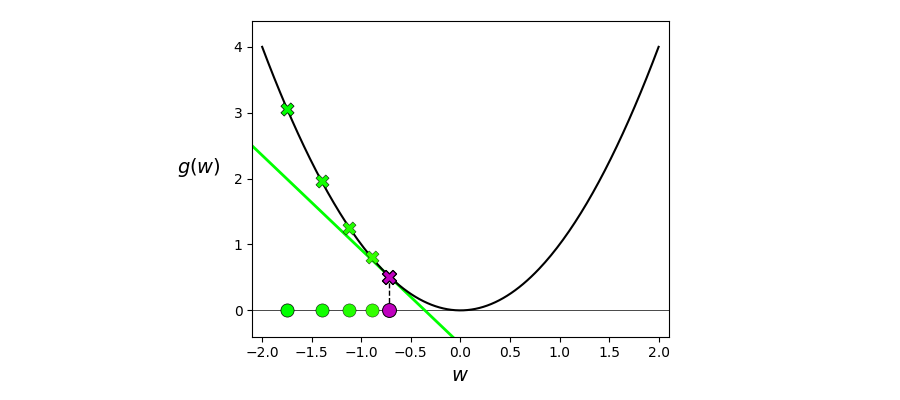
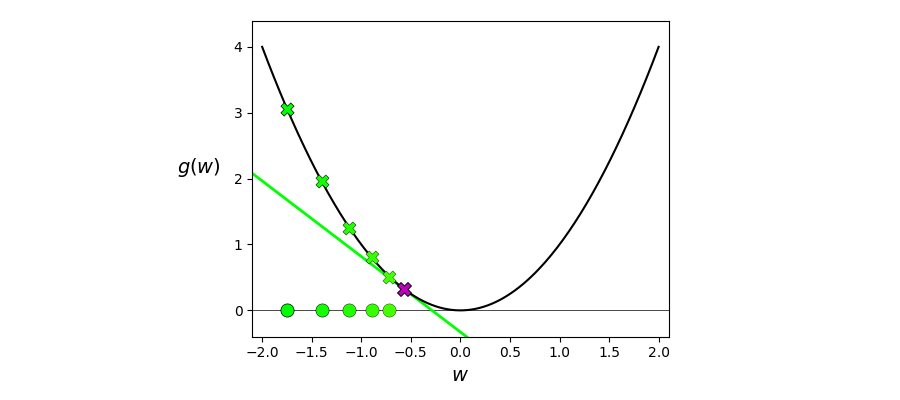
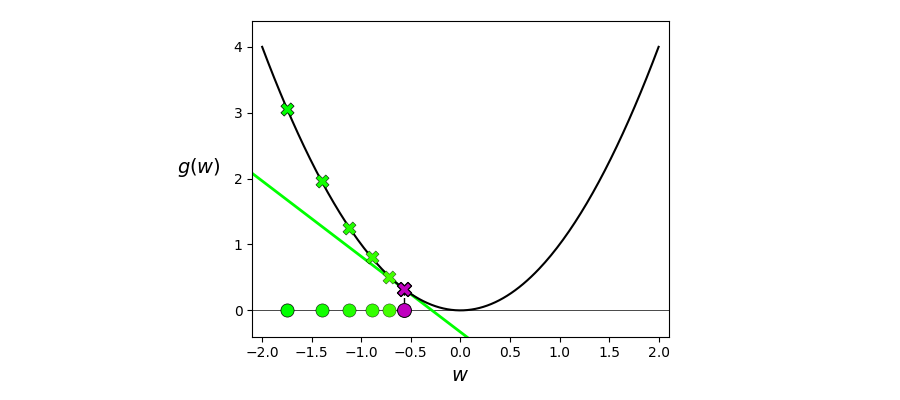
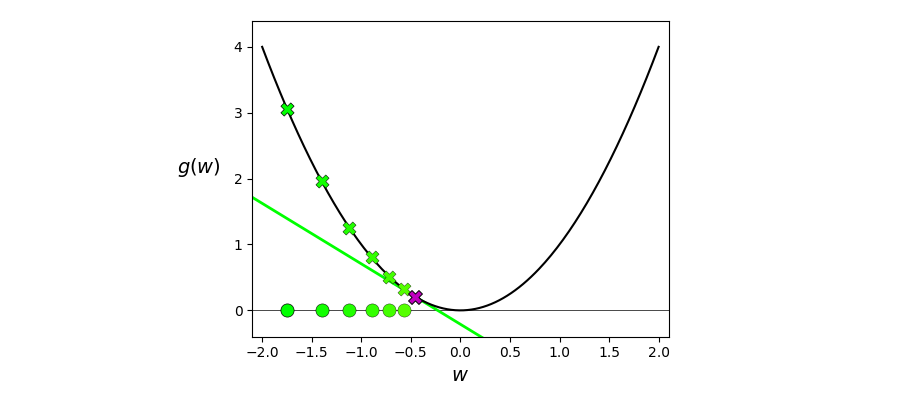
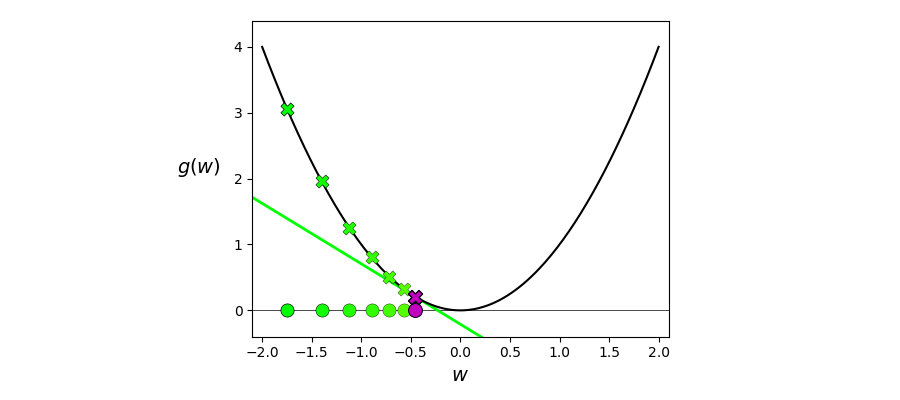
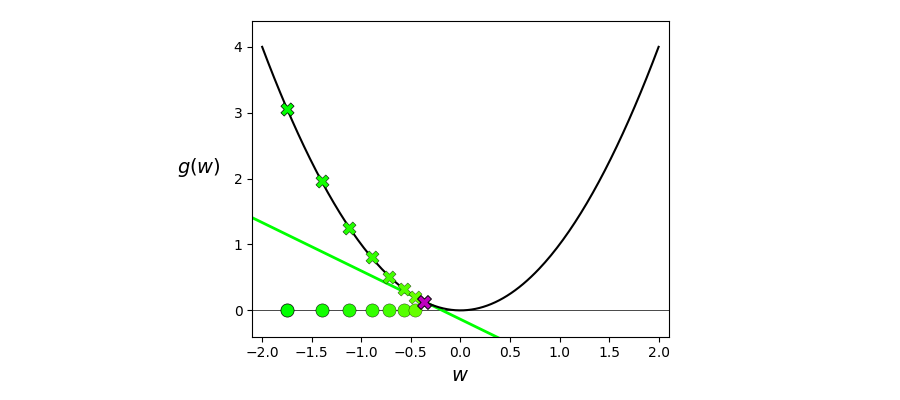
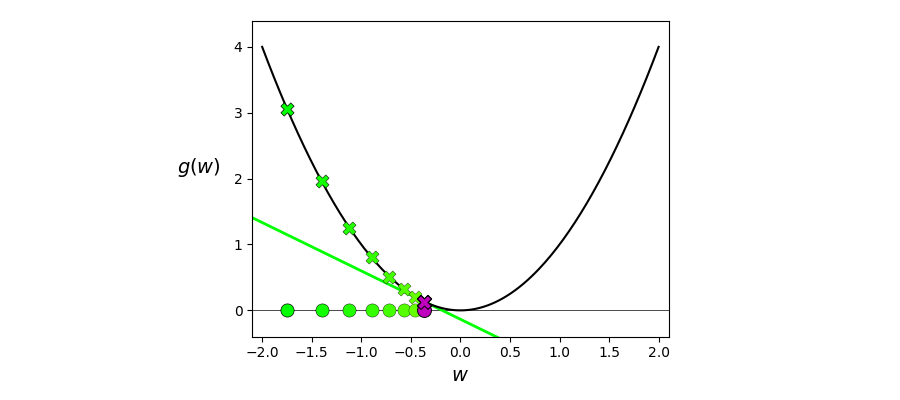
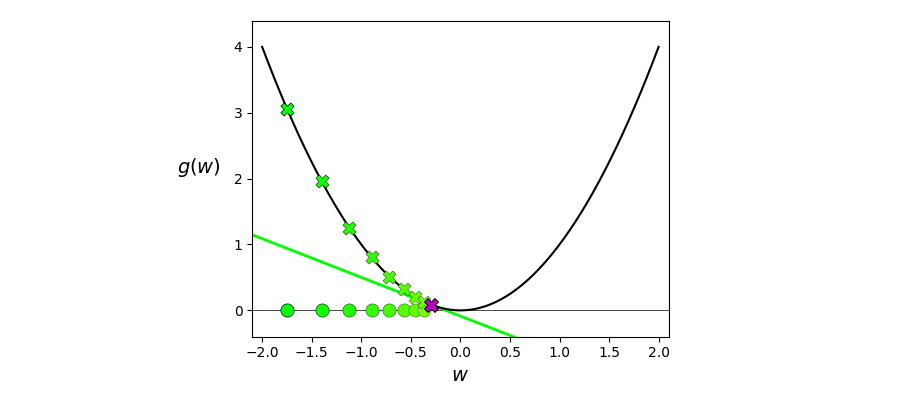
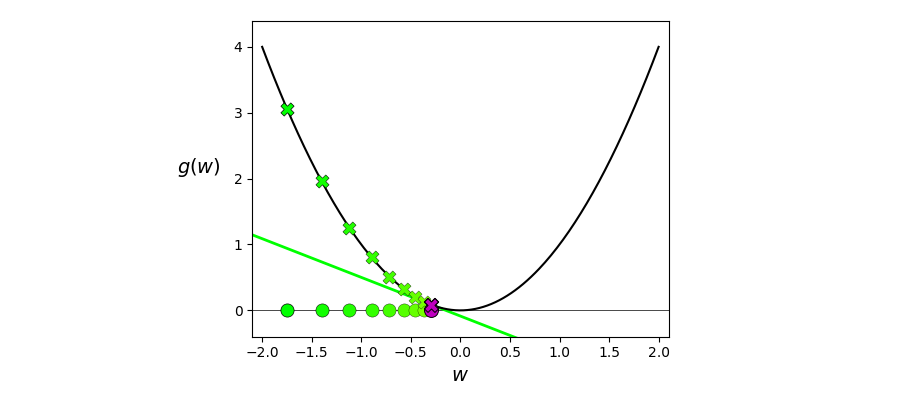
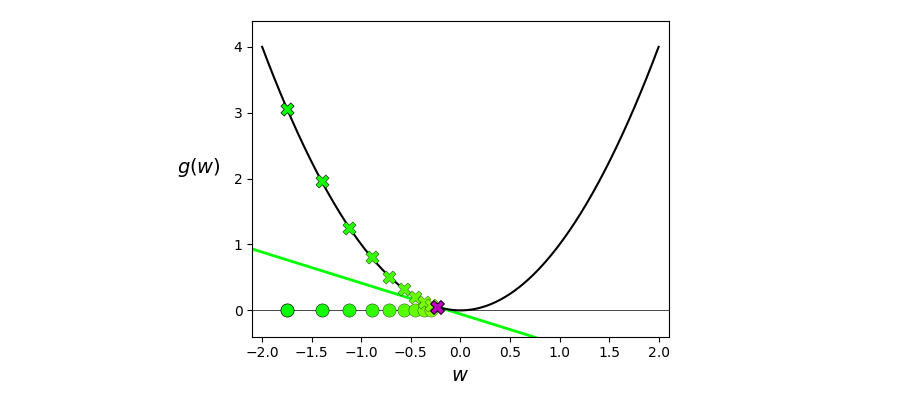
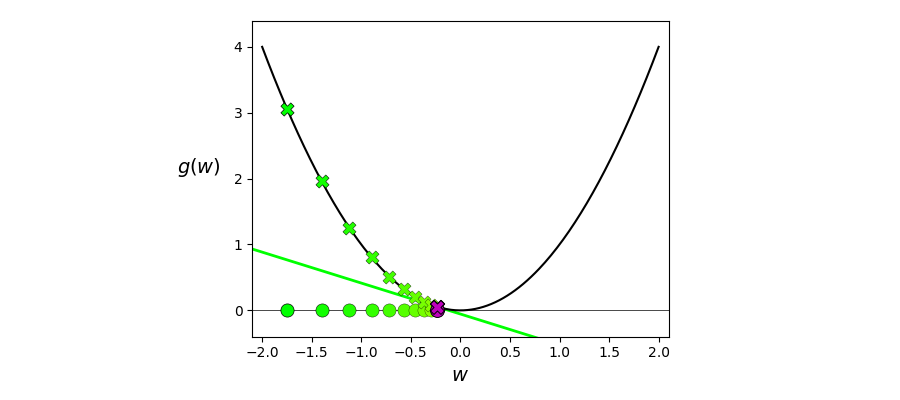
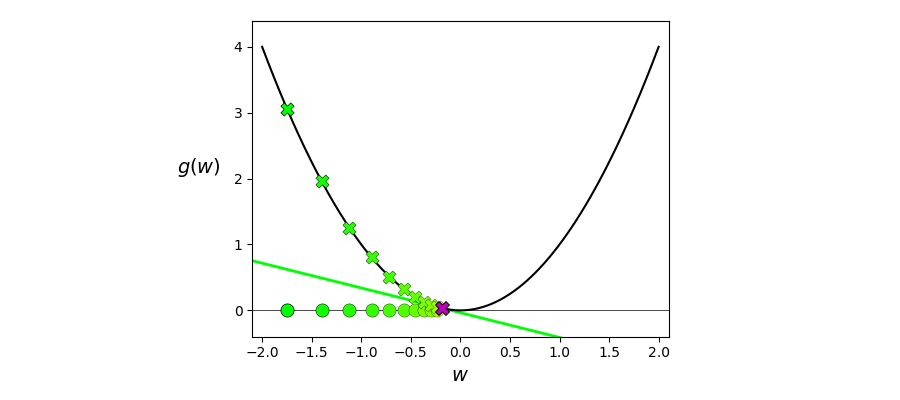
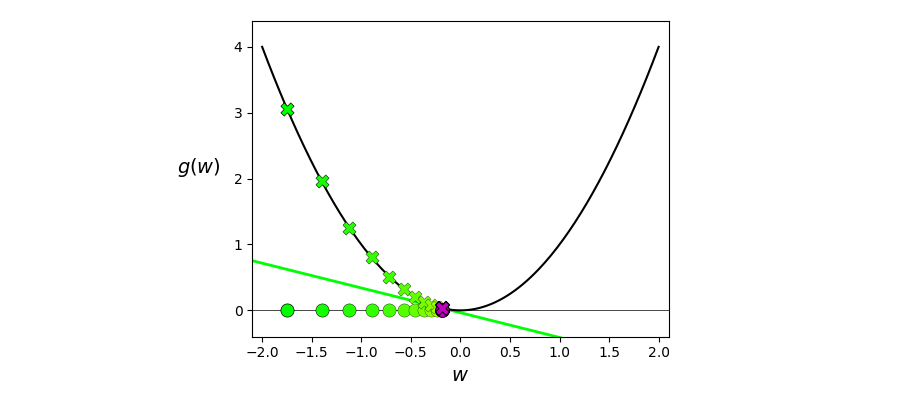
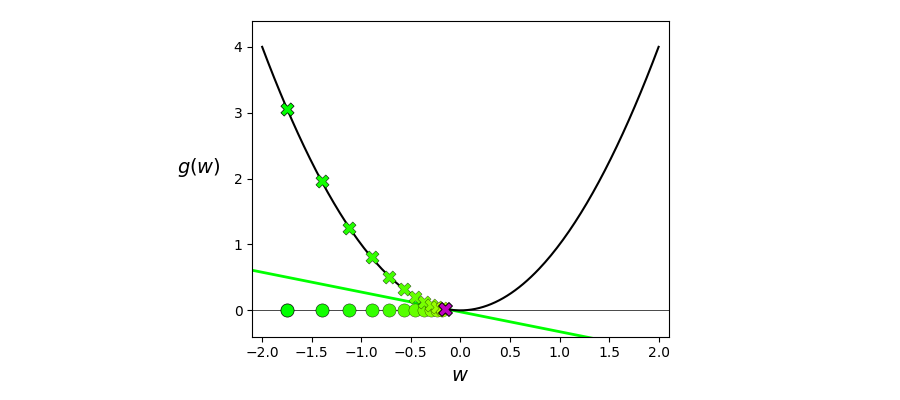
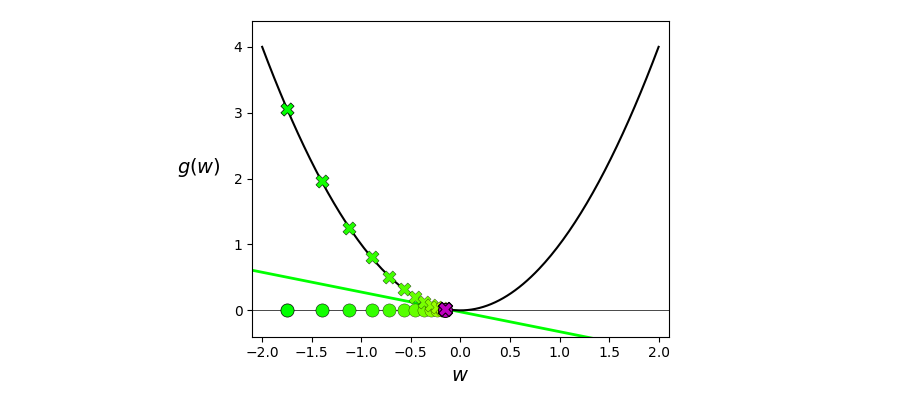
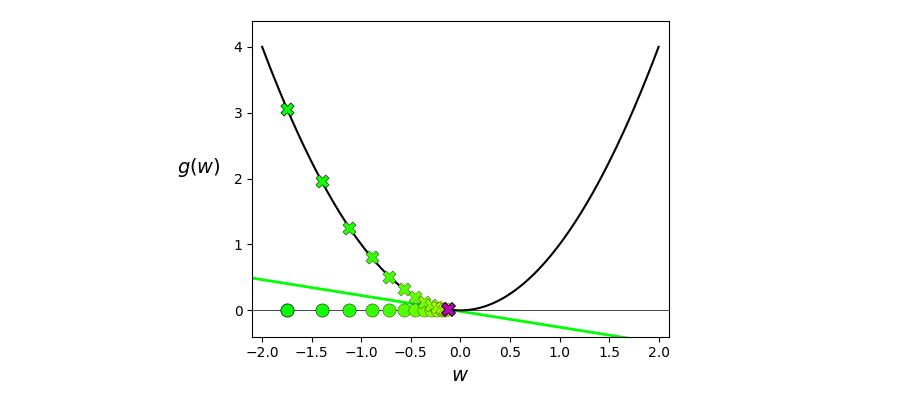
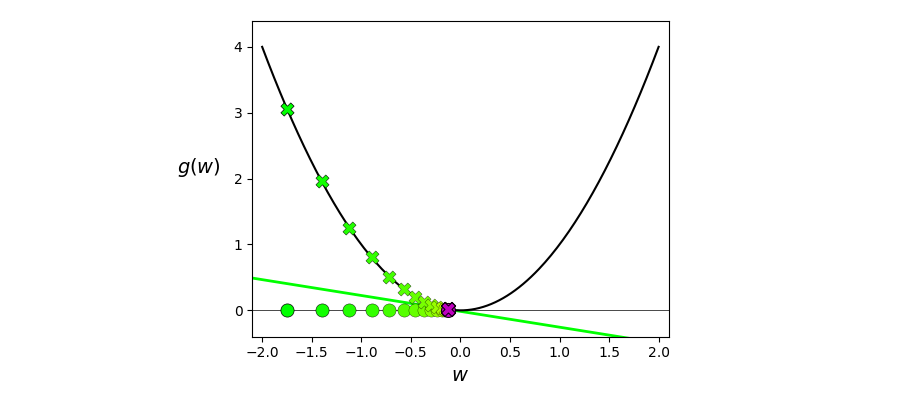
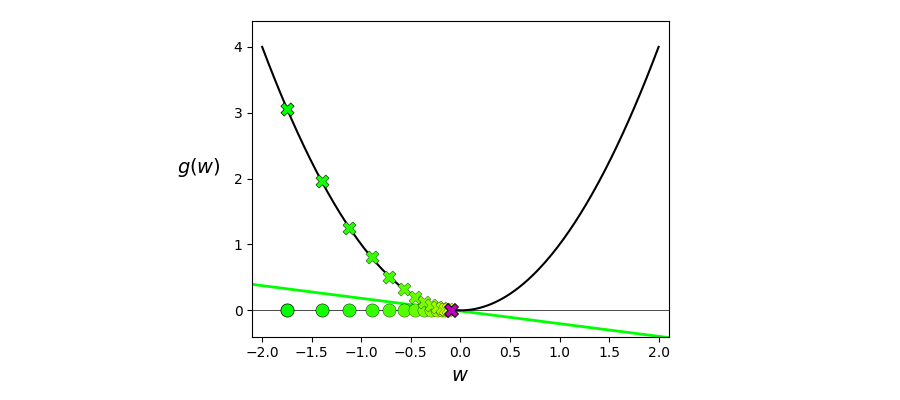
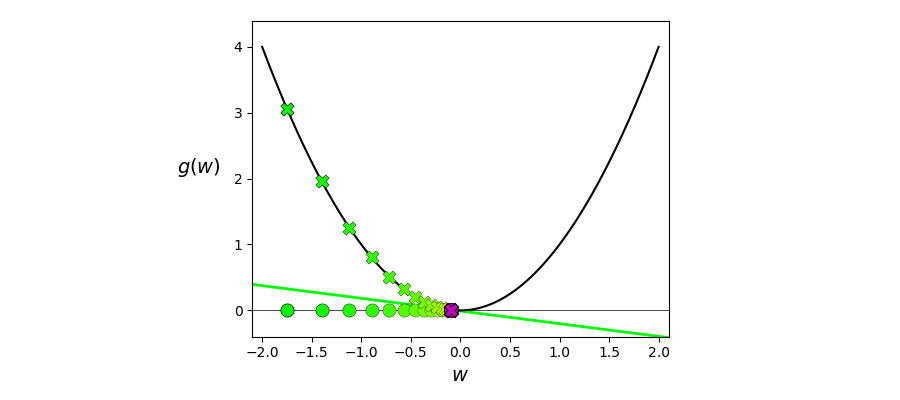
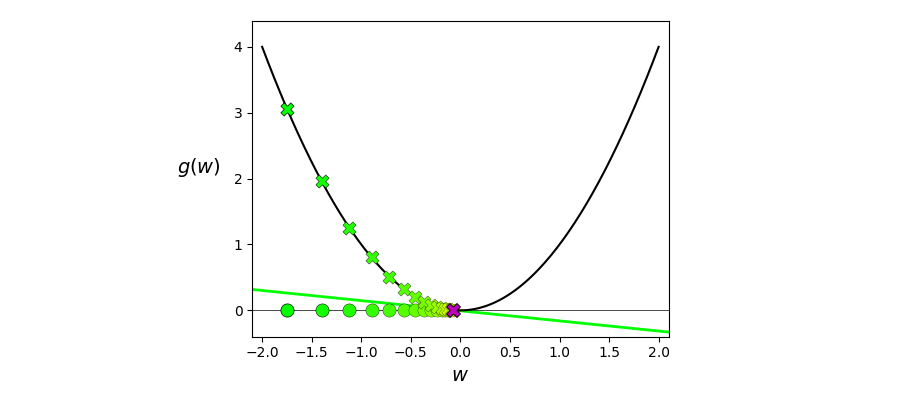
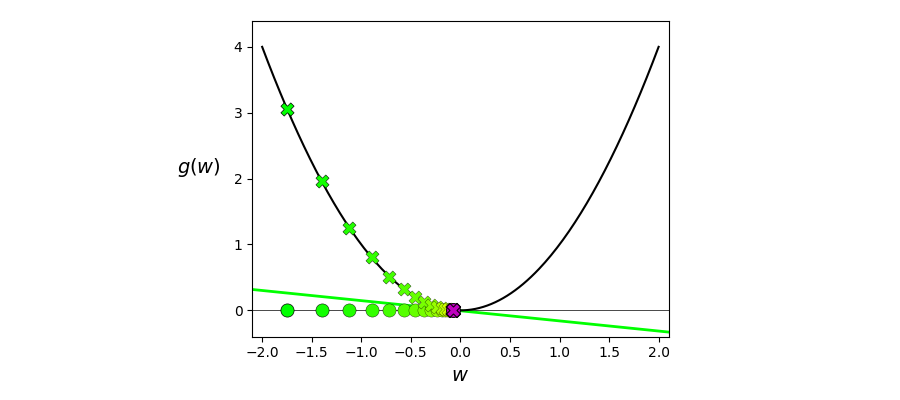
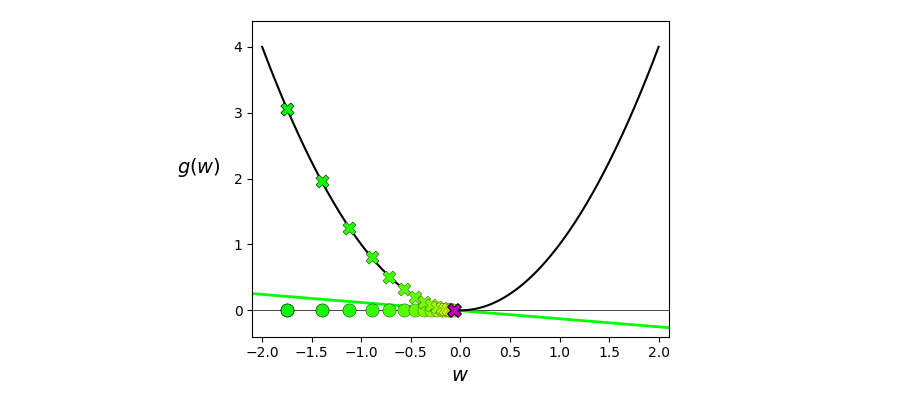
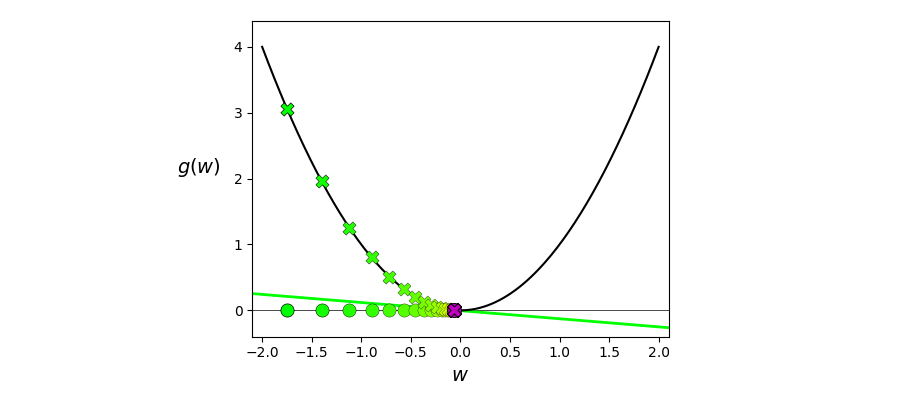
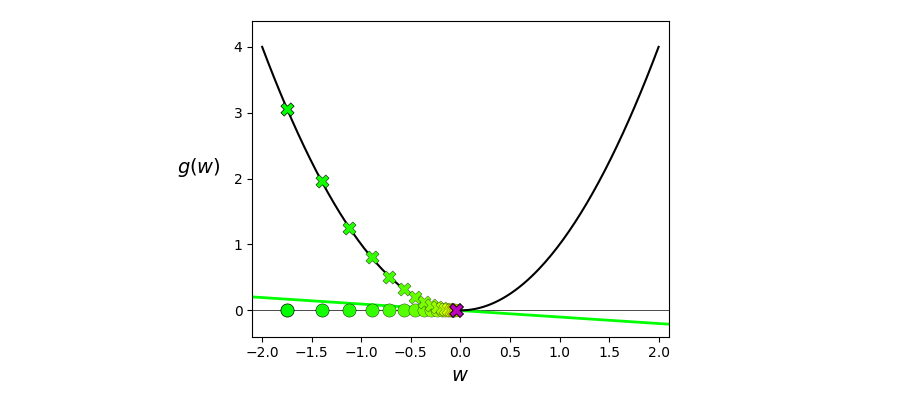
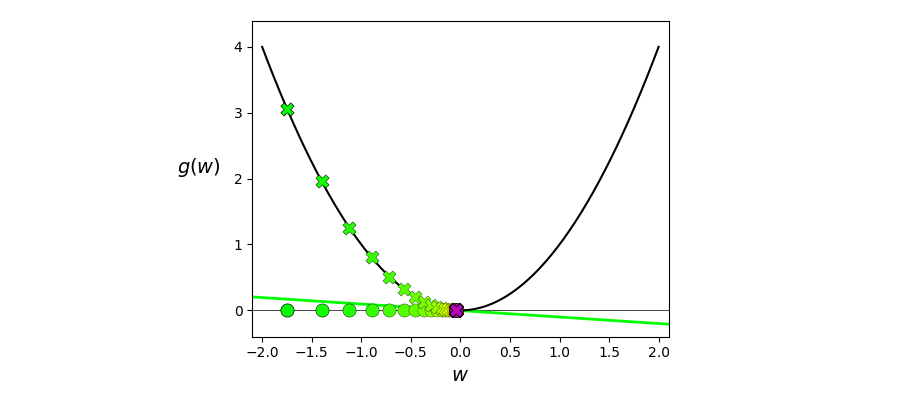
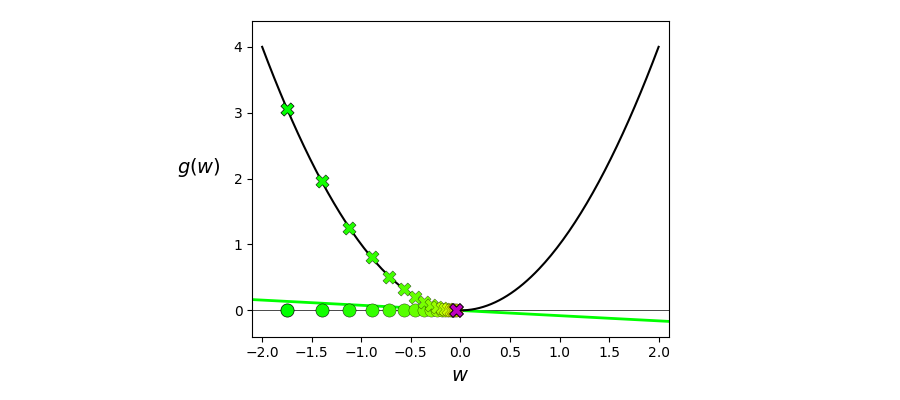
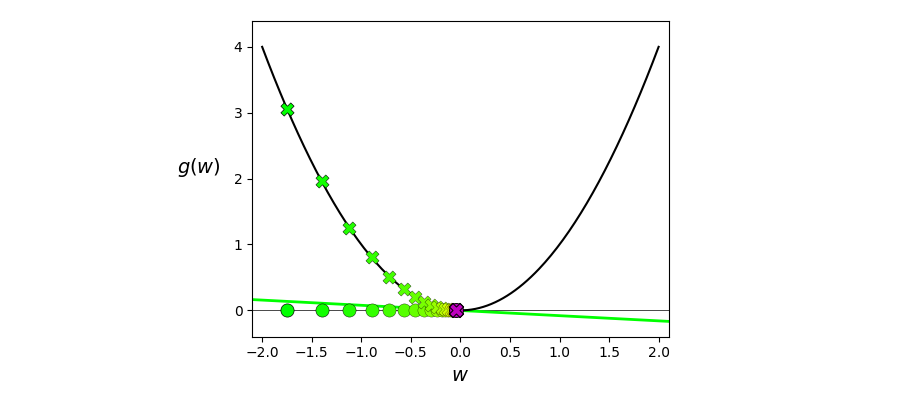
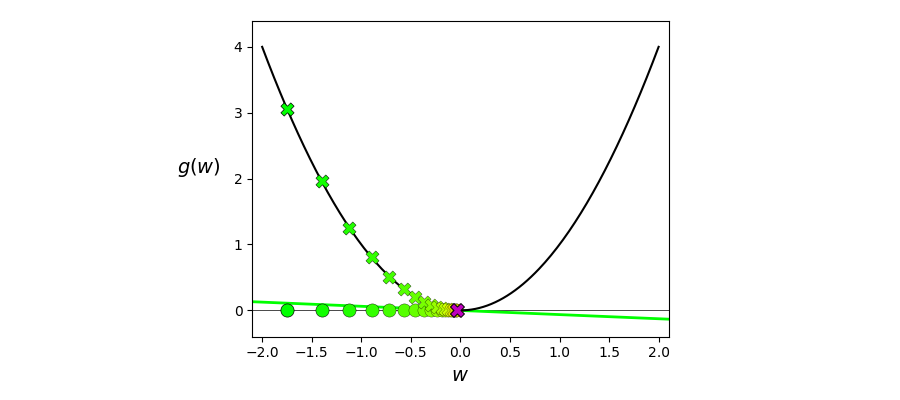
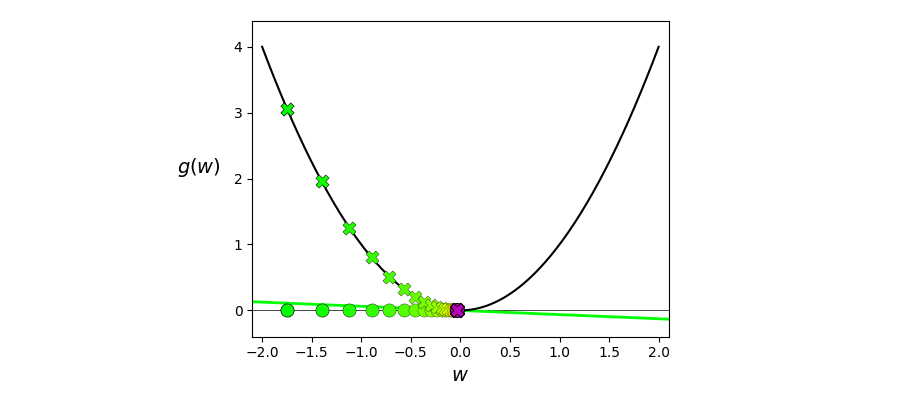
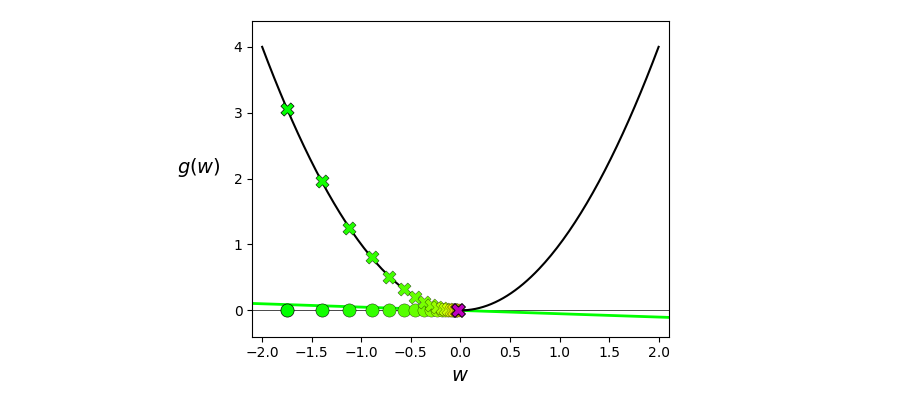
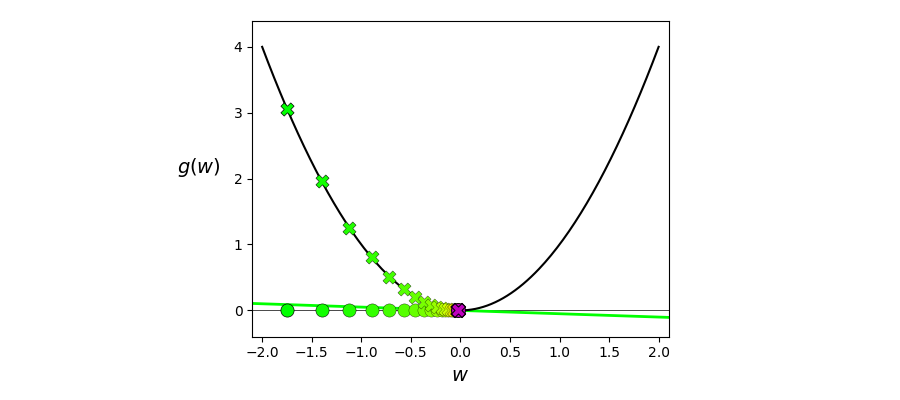
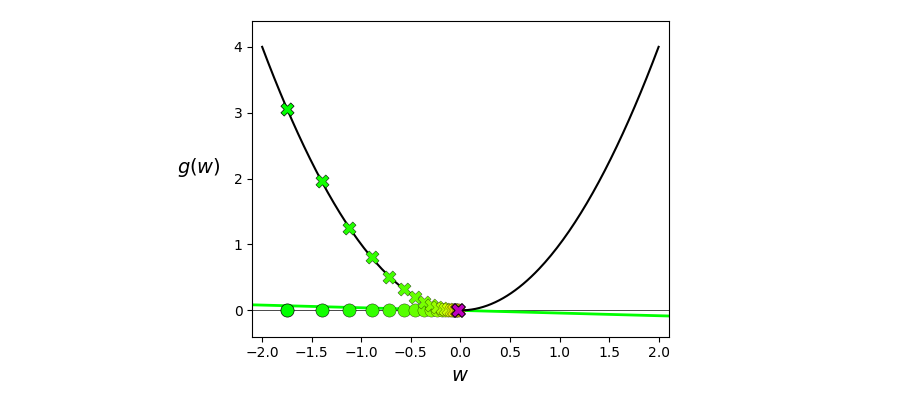
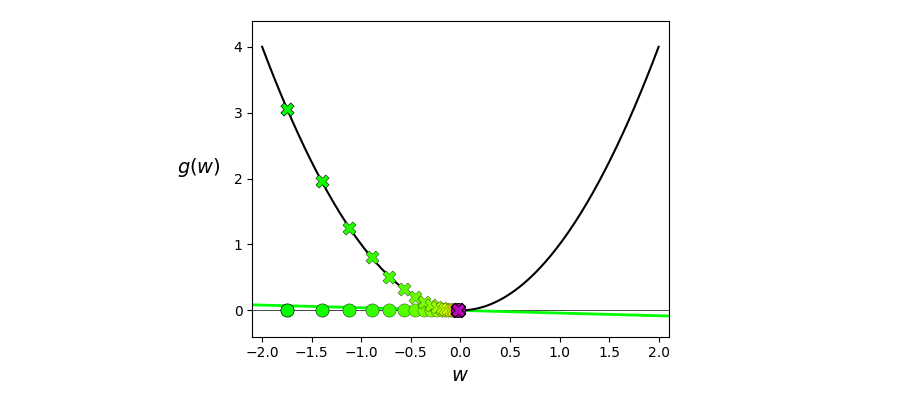
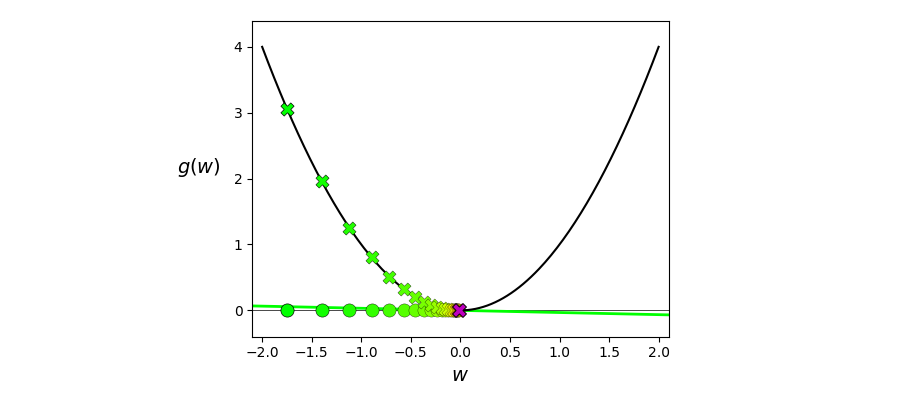
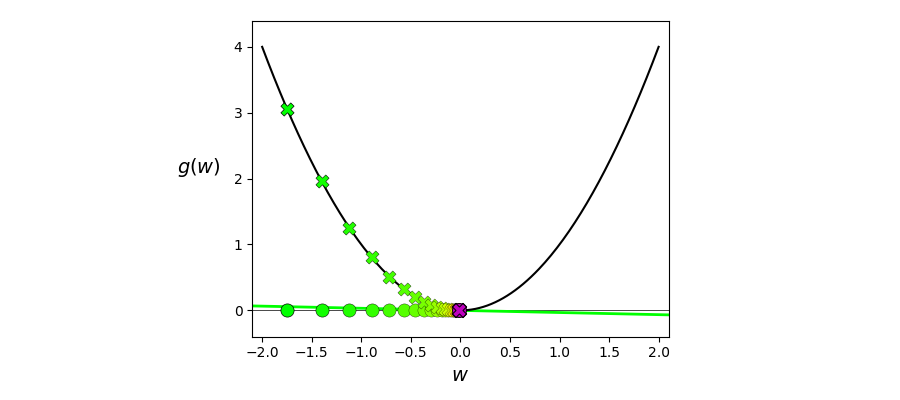
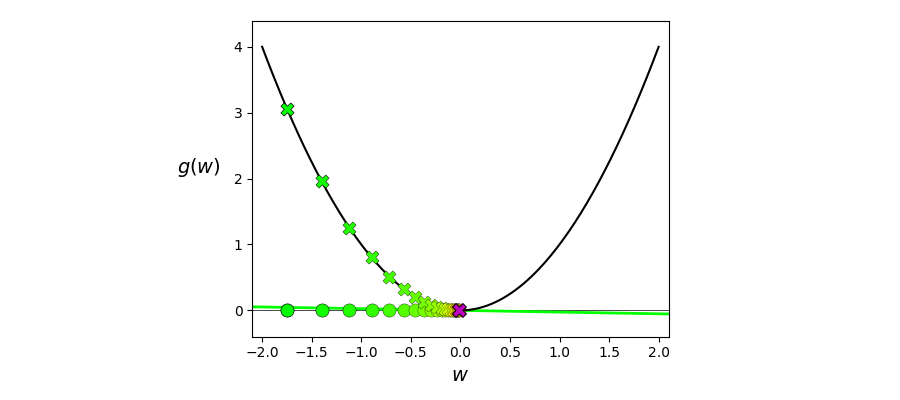
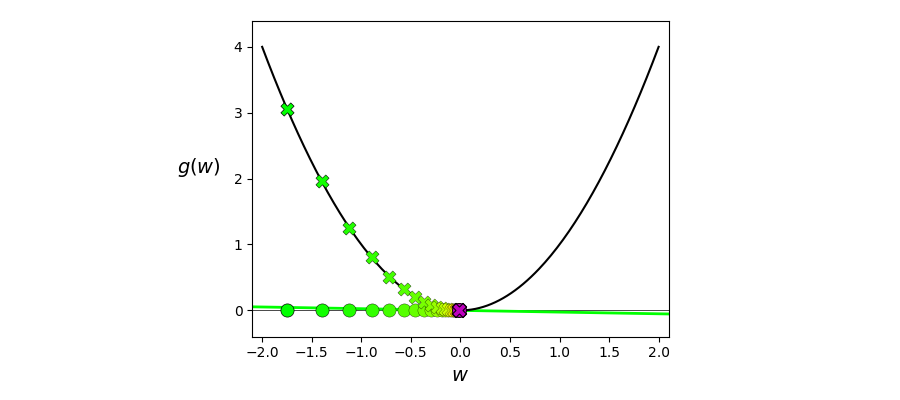
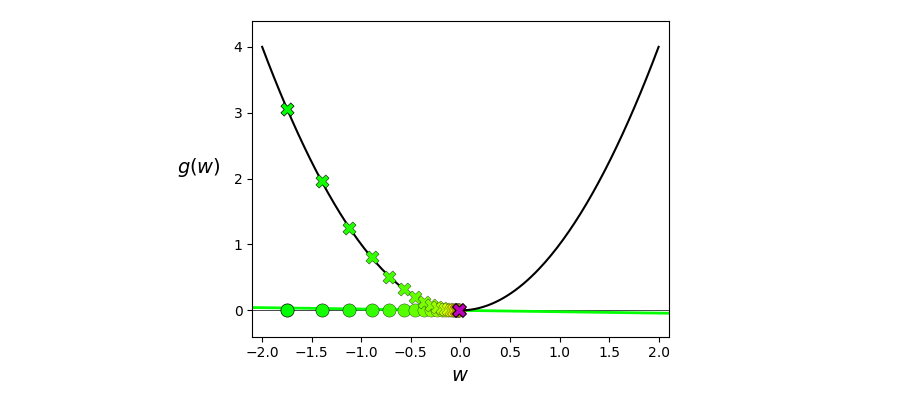
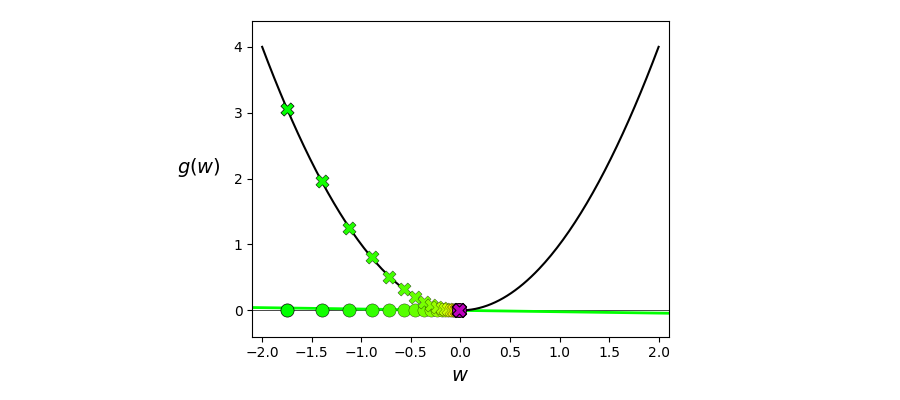
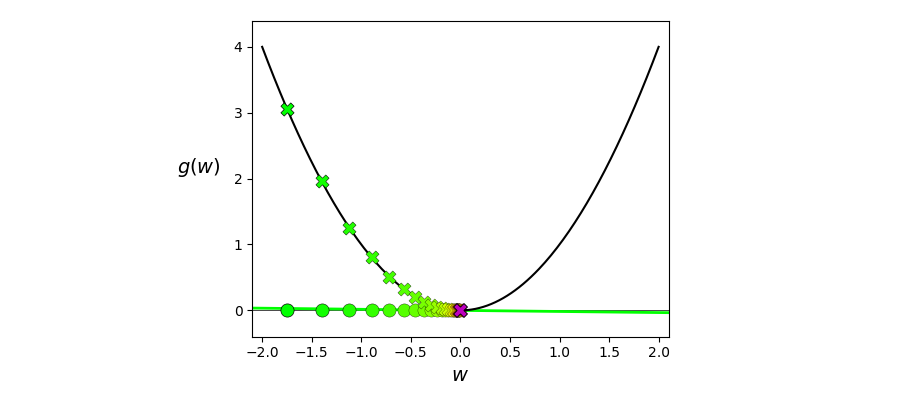
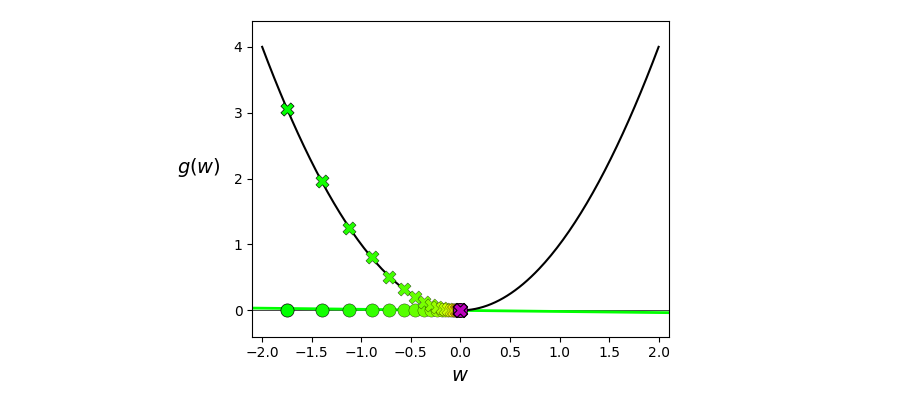
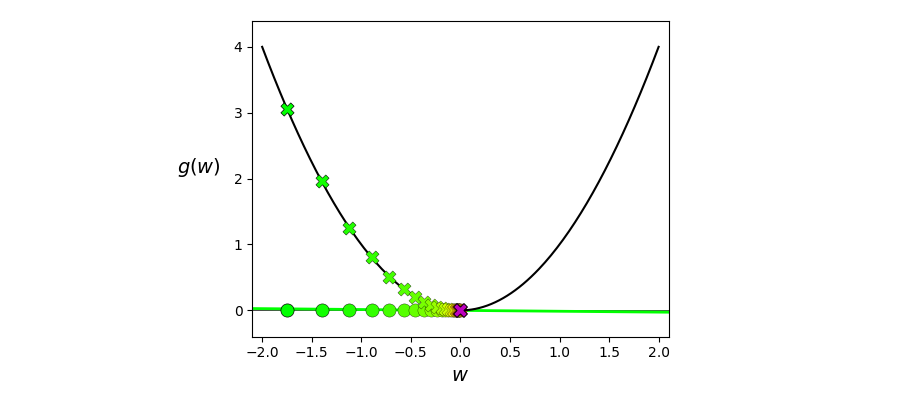
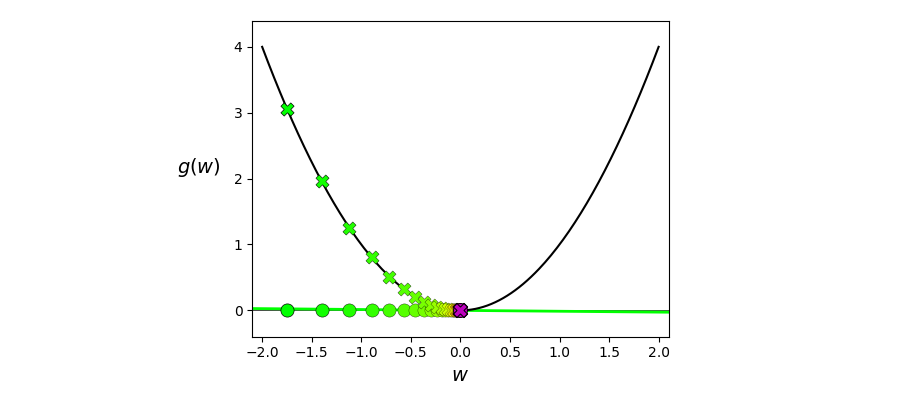
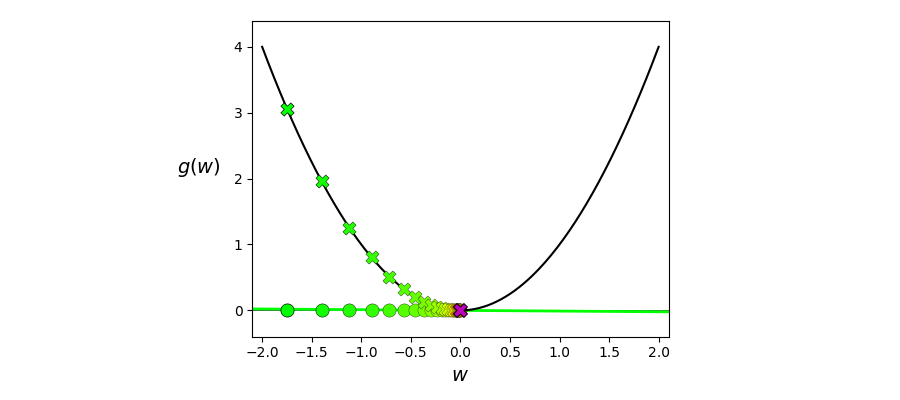
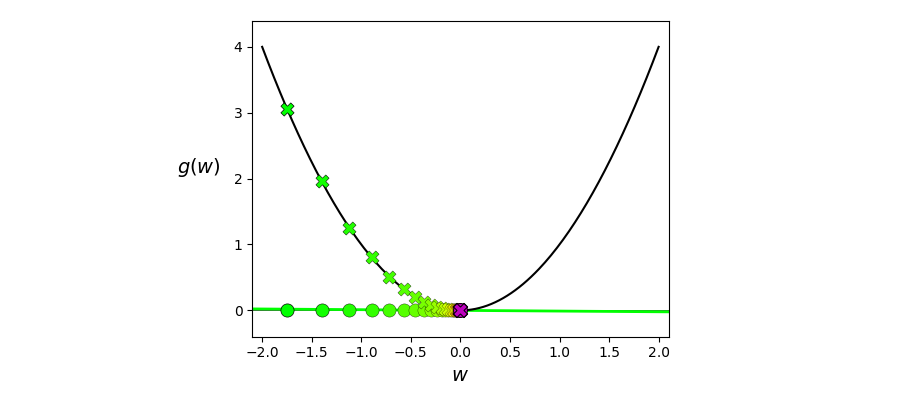
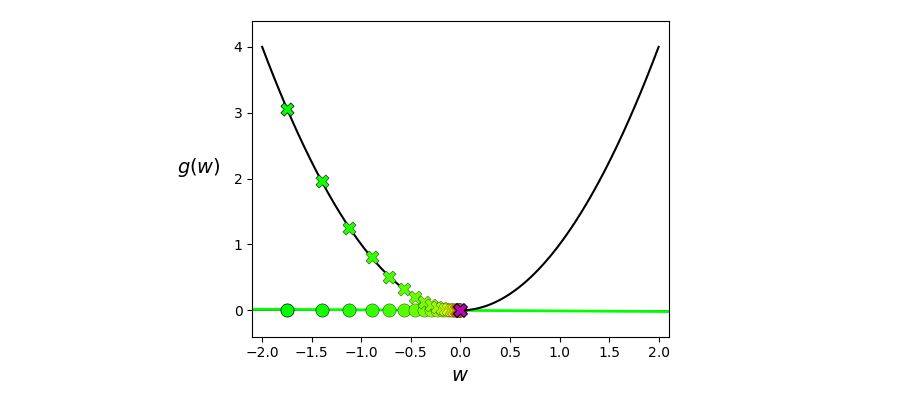
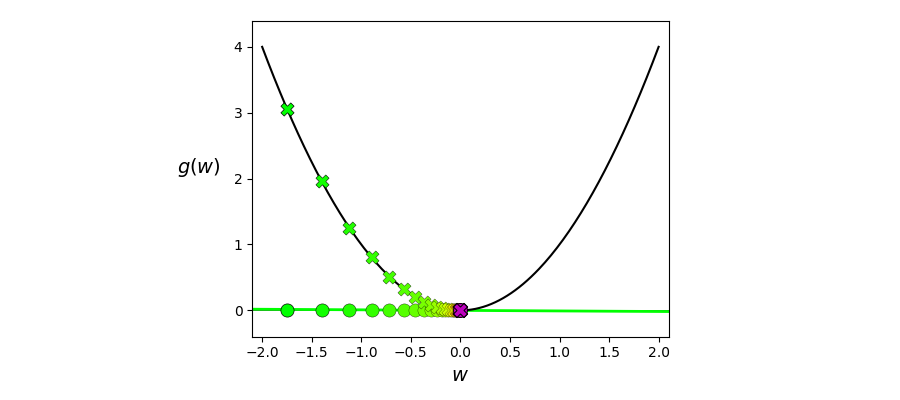
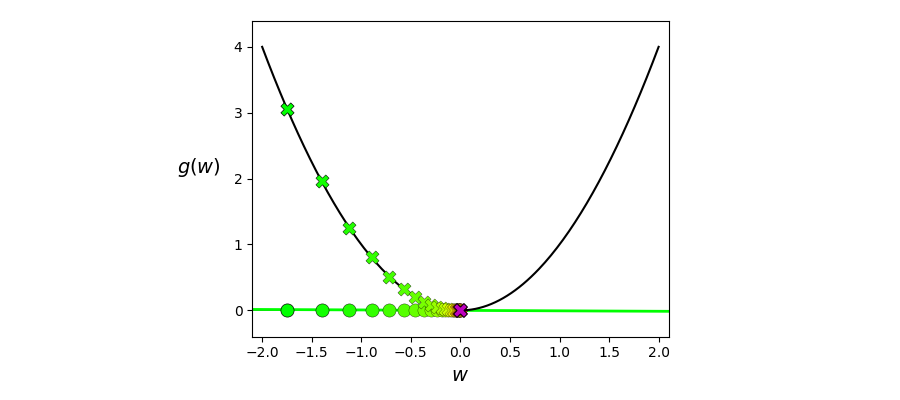
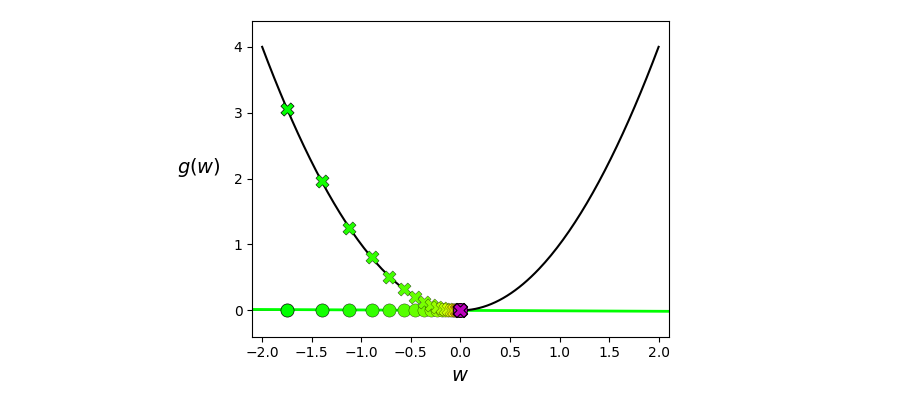
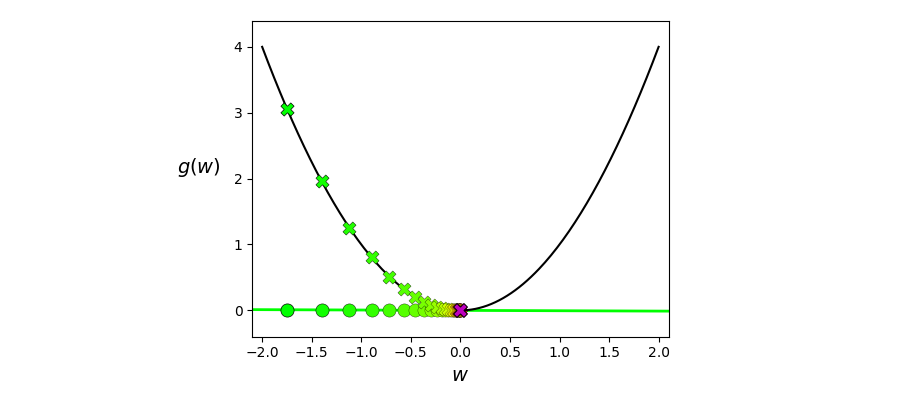
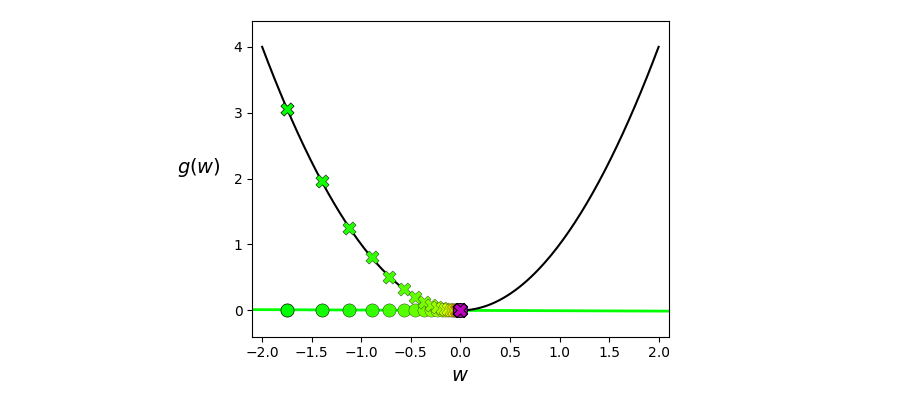
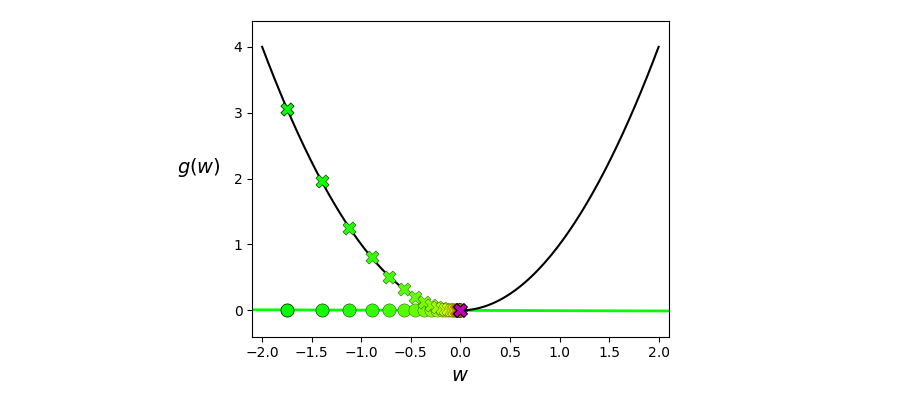
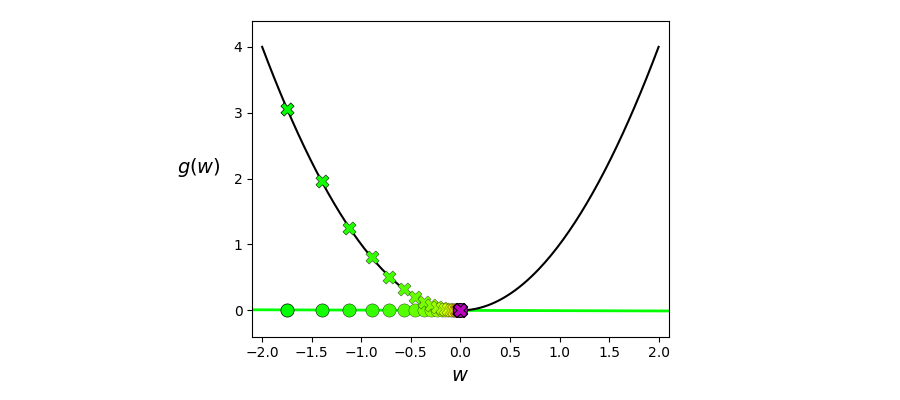
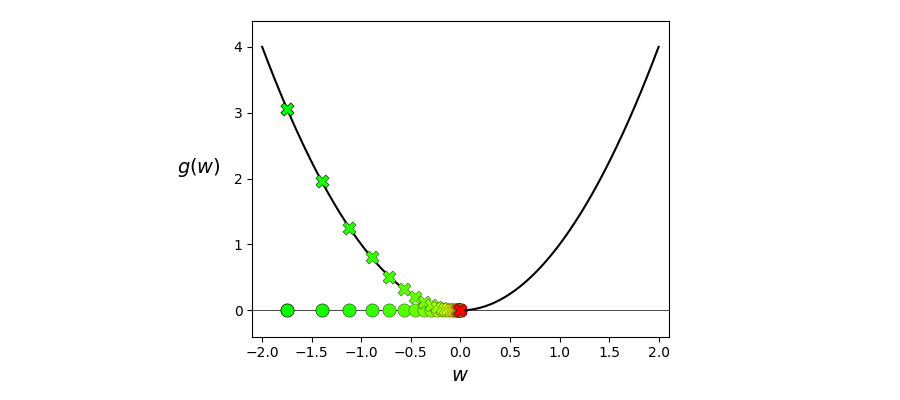

In [2]:
# what function should we play with?  Defined in the next line.
g = lambda w: w**2  

# run the visualizer for our chosen input function, initial point, and step length alpha
demo = optlib.gradient_descent_demos.visualizer();

demo.animate_2d(g=g, w_init = -1.75,steplength = 0.1,max_its = 30,version = 'unnnormalized',wmin = -2,wmax = 2)

Place the slider one unit left of its full right position, so that the final point is colored purple and the linear approximation is shown in lime green.  Now, lets discuss the convergence behavior of this run by examining the results above and the general form of the $k^{th}$ step in the unnormalized method

$$
\mathbf{w}^{\,k} = \mathbf{w}^{\,k-1} - \alpha \nabla g(\mathbf{w}^{\,k-1})
$$

First off note how - by examining the horizontal axis of the plot above - we can see that while the steplength parameter $\alpha$ here was fixed the length of each step clearly decreased at each step.  This is of course due to the fact that the length of each step - given by $\alpha\left\Vert \nabla g\left(\mathbf{w}^{\,k-1}\right) \right\Vert_2$ as derived earlier - is inherently tied to the length of the gradient.  Here (and in general) as the length of the gradient gets smaller, the steps get shorter (and vice-versa).  Hence the method 'slow down' - taking smaller and smaller steps - near stationary points of a function.  Stated more formally, if the steps are extremely close, i.e., that  $\mathbf{w}^{\,k} \approx \mathbf{w}^{\,k-1}$ then from the unnormalized update step it must be the case that $\nabla g(\mathbf{w}^{\,k-1}) \approx \mathbf{0}_{N\times 1}$ or likewise that $\left\Vert \nabla g\left(\mathbf{w}^{\,k-1}\right)\right\Vert_2$ is small (with our example above we can indeed see that the derivative, or slope of the tangent line, is very close to zero).  This says that unnormalized gradient descent naturally halts near **any** stationary point of a function (including saddle points). (See our *Vital elements of calclus series* for more info on stationary points if this concept is unfamiliar.)  This feature makes the unnormalized gradient descent step a natural choice for minimizing convex functions - whose only stationary points are global minima.

In the next Python cell we compare normalized and unnormalized gradient descent (left and right panels respectively) on the simple quadratic function used previously.  Both algorithms use the same initial point ($w^0 = -3$), steplength parameter ($\alpha = 0.1$), and maximum number of iterations (20 each).  Steps are colored from green to red to indicate the starting and ending points of each run, with circles denoting the actual steps in the input space and 'x''s denoting their respective function evaluations.  Notice how - due to the re-scaling of each step via the derivative length - the unnormalized version races to the global minimum of the function.  Meanwhile the unnormalized version - taking constant length steps - gets only a fraction of the way there.  This behavior is indicative of how each behaves in general when applied to minimizing convex functions. 

<IPython.core.display.Javascript object>


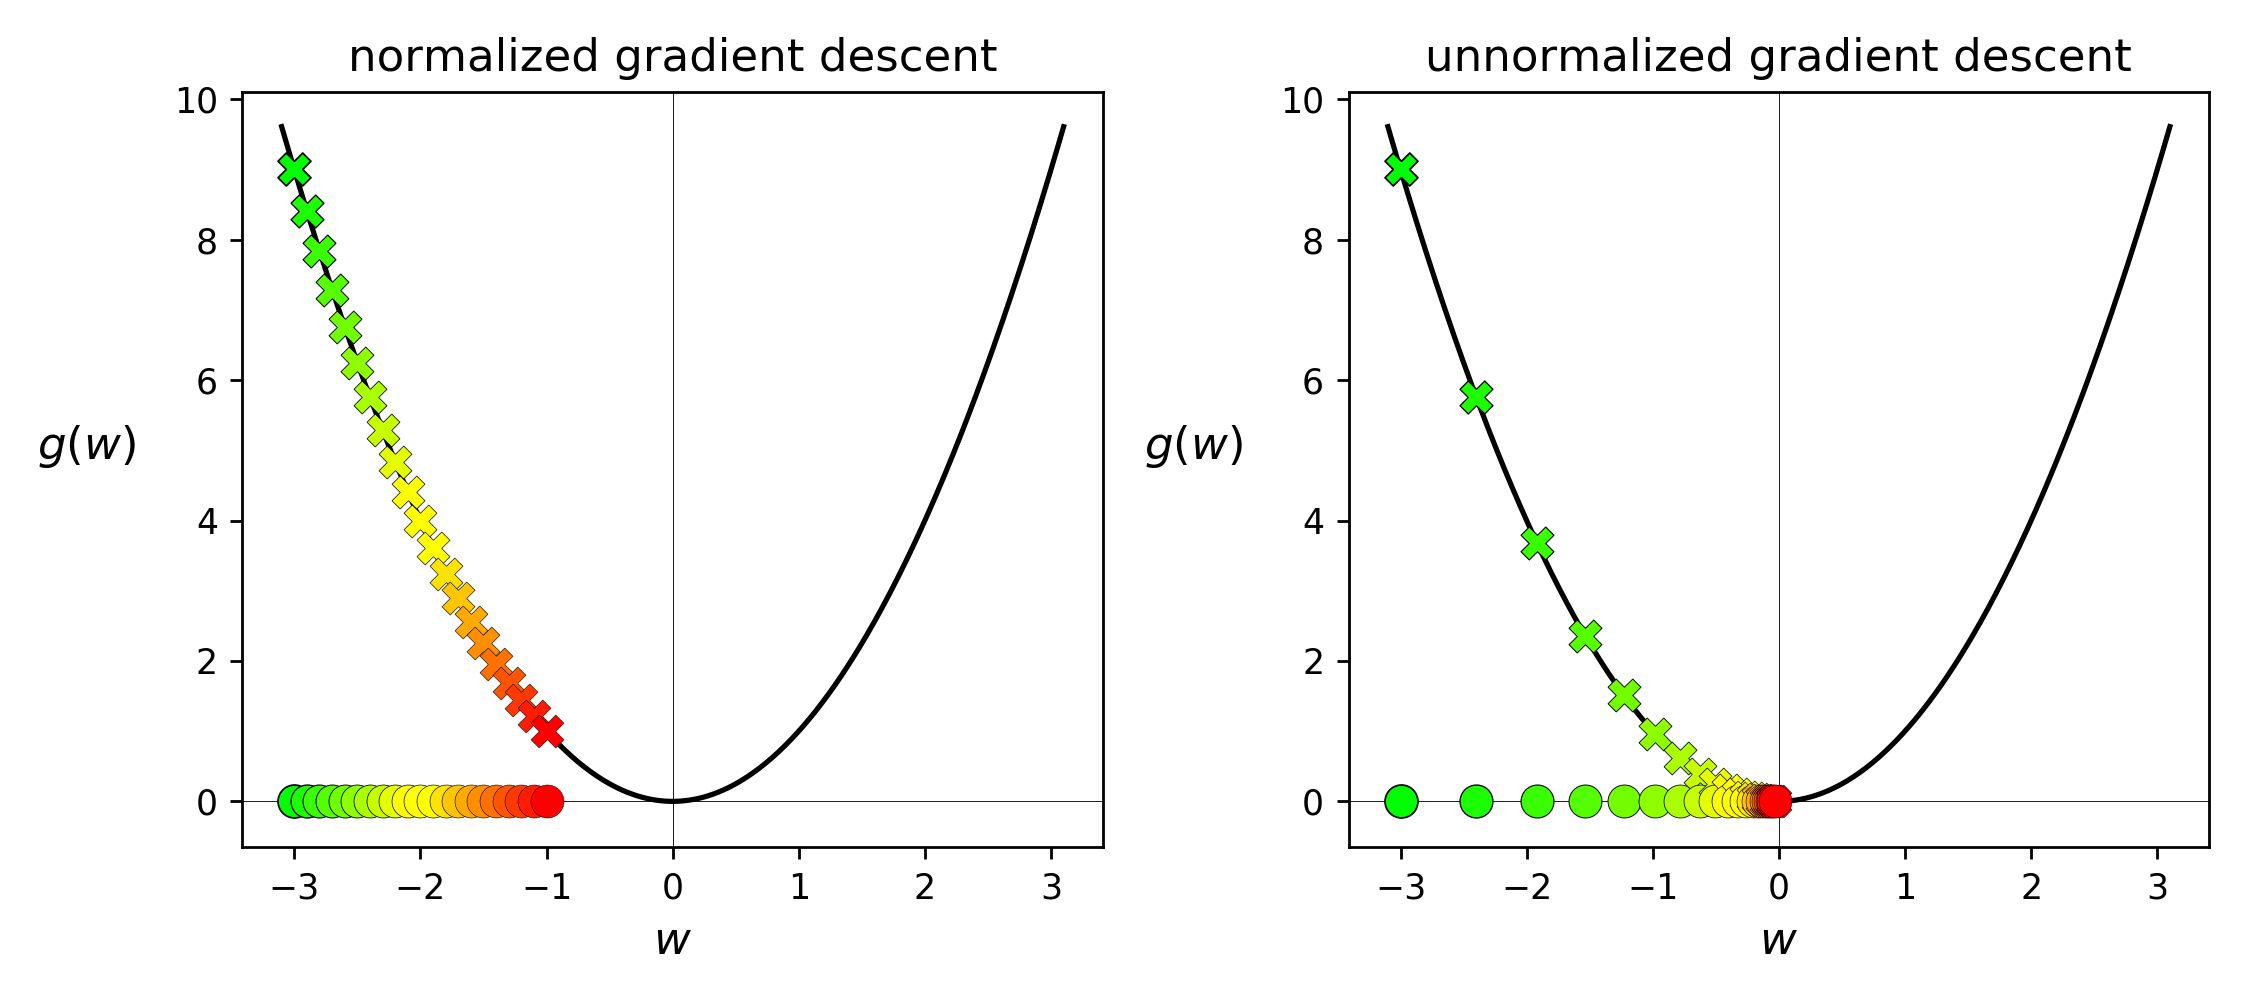

In [3]:
# what function should we play with?  Defined in the next line.
g = lambda w: w**2

# run the visualizer for our chosen input function, initial point, and step length alpha
demo = optlib.gradient_descent_demos.visualizer();
demo.compare_versions_2d(g=g, w_init = -3,steplength = 0.1,max_its = 20)

Another example, consider the same quadratic with $N = 2$ inputs which we illustrate - along with a run of each version of the algorithm - in the next Python cell.   As can be seen in the plot, when using a constant steplength parameter $\alpha = 0.7$ the length of each step with the unnormalized algorithm naturally *diminishes* as it approaches the stationary point (the global minimum) due to the shrinking gradient, and this helps it 'zero in' on the minimum and get infinitesimally close to it.  Conversely with the normalized gradient descent algorithm - which takes steps of the length $\alpha$ ad infinitem - we can only get so close to the global minimum.  We cannot 'zero in' on the solution at the origin as well as the unnormalized version can.

This is indicative of a more general behavior of the normalized gradient descent algorithm with functions such as this - if we want a point infinitesimally close to a global minimum we must *use a diminishing steplength*.  This gives the normalized algorithm a chance to 'zero in' on minima.  Thus for a general function we see that gradient descent 'zeros in' local minima only when the length of each step (eventually) diminishes as the algorithm progresses.  In the case of normalized gradient descent this implies that the steplength parameter $\alpha$ should be diminishing in size if such a solution is needed.

<IPython.core.display.Javascript object>


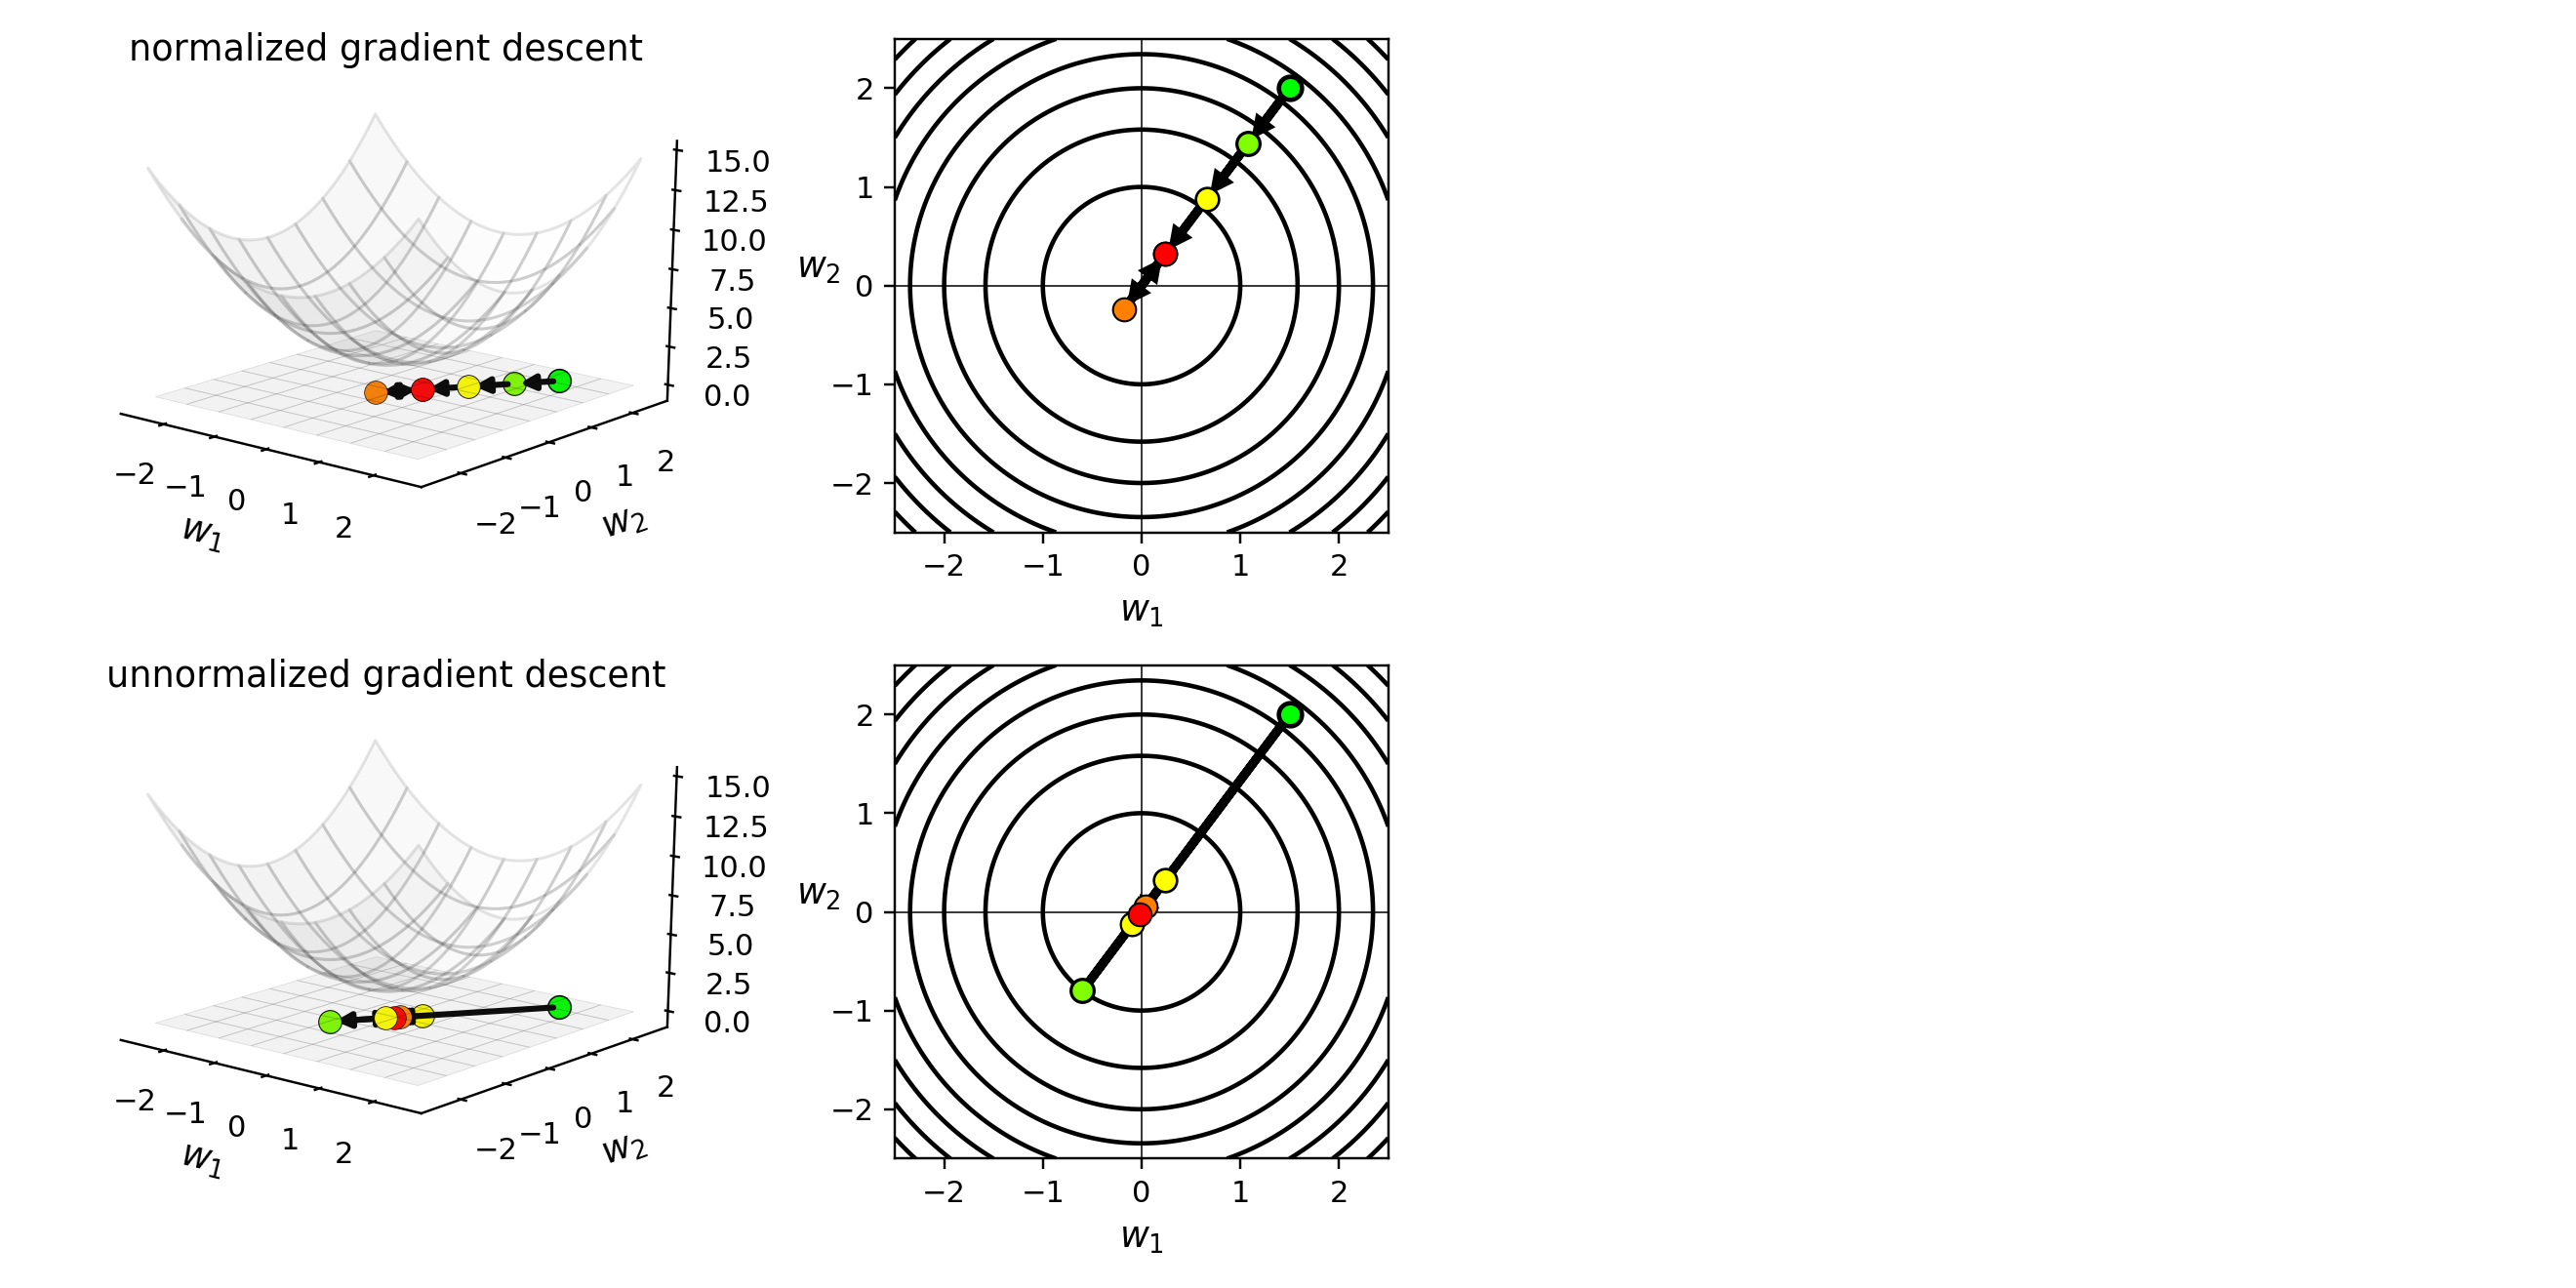

In [4]:
# what function should we play with?  Defined in the next line.
g = lambda w: np.dot(w.T,w) + 2

# run the visualizer for our chosen input function, initial point, and step length alpha
demo = optlib.gradient_descent_demos.visualizer();
w_init = [1.5,2]; max_its = 5; steplength = 0.7;

demo.compare_versions_3d(g,w_init,steplength,max_its,wmax=max(w_init[0],w_init[1]))

Note that it is not always the case with a convex function that the magnitude of the gradient diminishes as we approach global minima.  Take the absolute value function for example

\begin{equation}
g(w) = |w|
\end{equation}

which has a single global minimum at $w = 0$, but whose derivative is always defined (everywhere but at $w = 0$) as

\begin{equation}
\frac{\mathrm{d}}{\mathrm{d}w}g(w) = \begin{cases}
+1 \,\,\,\,\,\text{if} \,\, w > 0 \\
-1 \,\,\,\,\,\text{if} \,\, w < 0.
\end{cases}
\end{equation}

Since the length of each step with unnormalized gradient descent is dependent on the magnitude of this derivative, the fact that it's length here does not change means that we are essentially taking normalized steps.

Hence - for example - if we initialize at $w = 1.7$ with a steplength value $\alpha = 0.5$ and run for $10$ steps we oscilate around the global minimum, as with normalized gradient descent.  We illustrate this in the next cell.

<IPython.core.display.Javascript object>


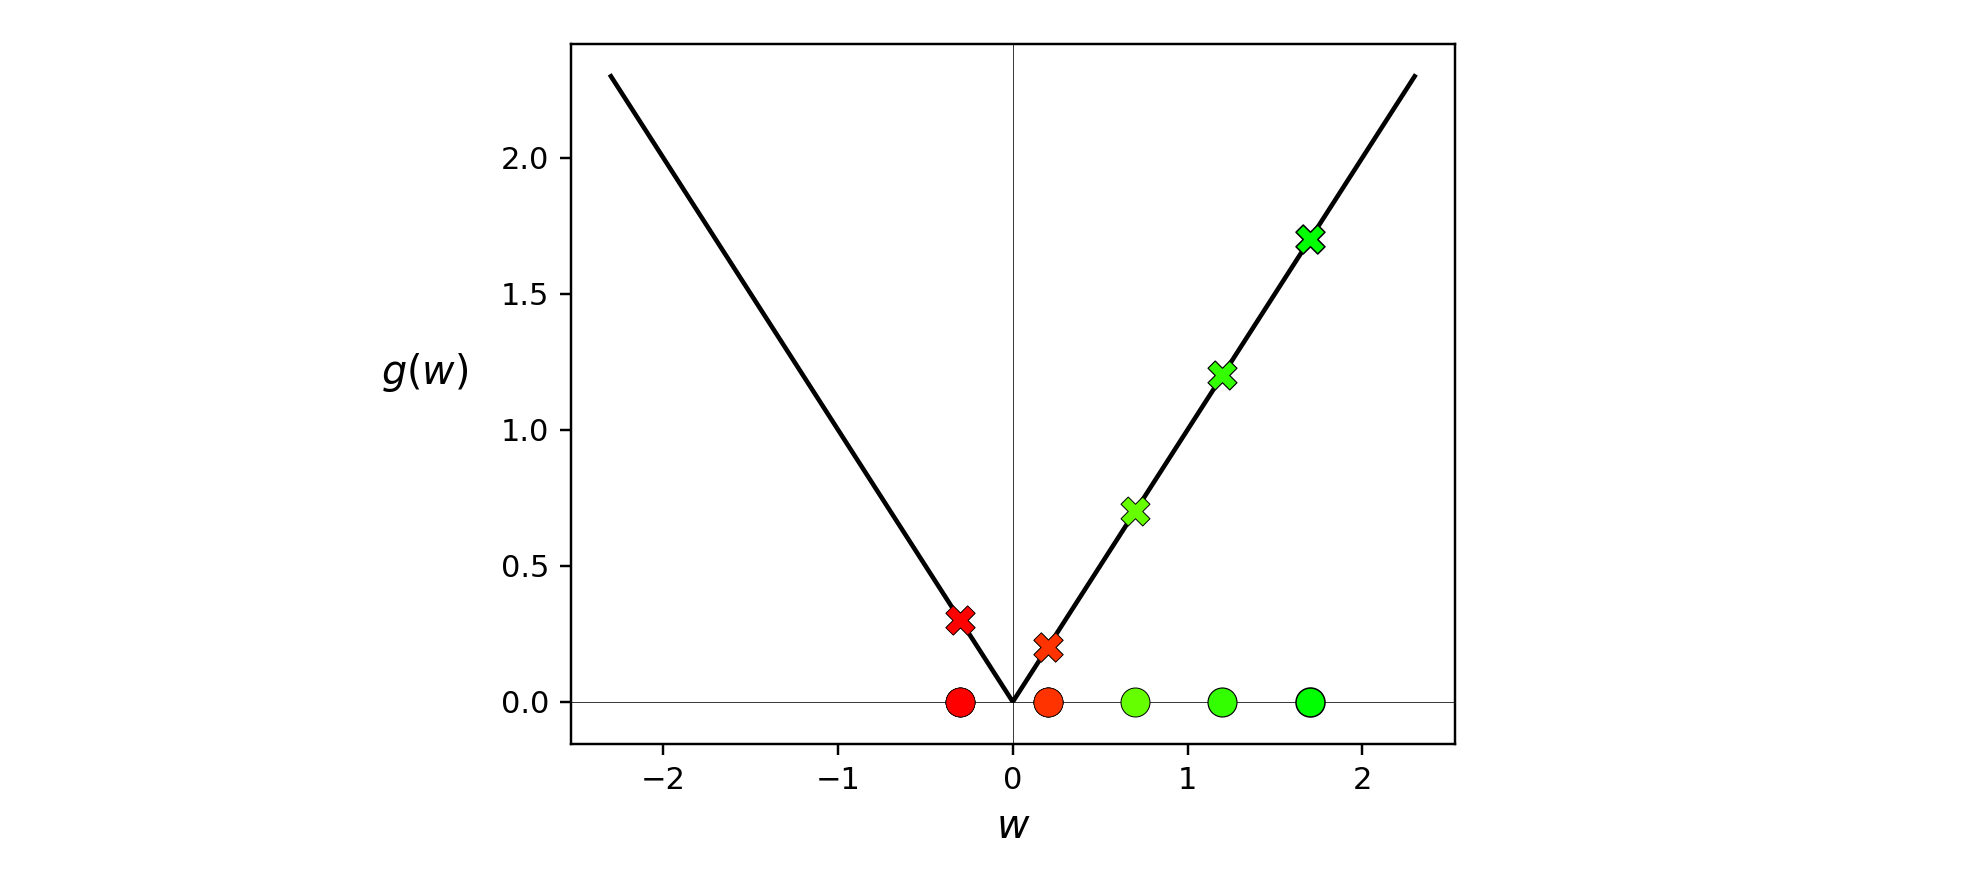

In [25]:
# what function should we play with?  Defined in the next line.
g = lambda w: np.abs(w)

# run the visualizer for our chosen input function, initial point, and step length alpha
demo = optlib.gradient_descent_demos.visualizer();

demo.draw_2d(g=g, w_inits = [1.7] ,steplength = 0.5,max_its = 10,version = 'unnormalized',wmin =-2.3,wmax = 2.3)

Here - as with normalized descent - because the length of each step is not diminishing as we approach the global minima naturally, we must force it too by using a diminishing steplength value $\alpha$ if we wish to reach a point infinitesimally close to the minimum.  We-rerun the example above using a diminishing steplength value $\alpha$ in the Python cell below, and indeed we get much closer to the global minimum.

<IPython.core.display.Javascript object>


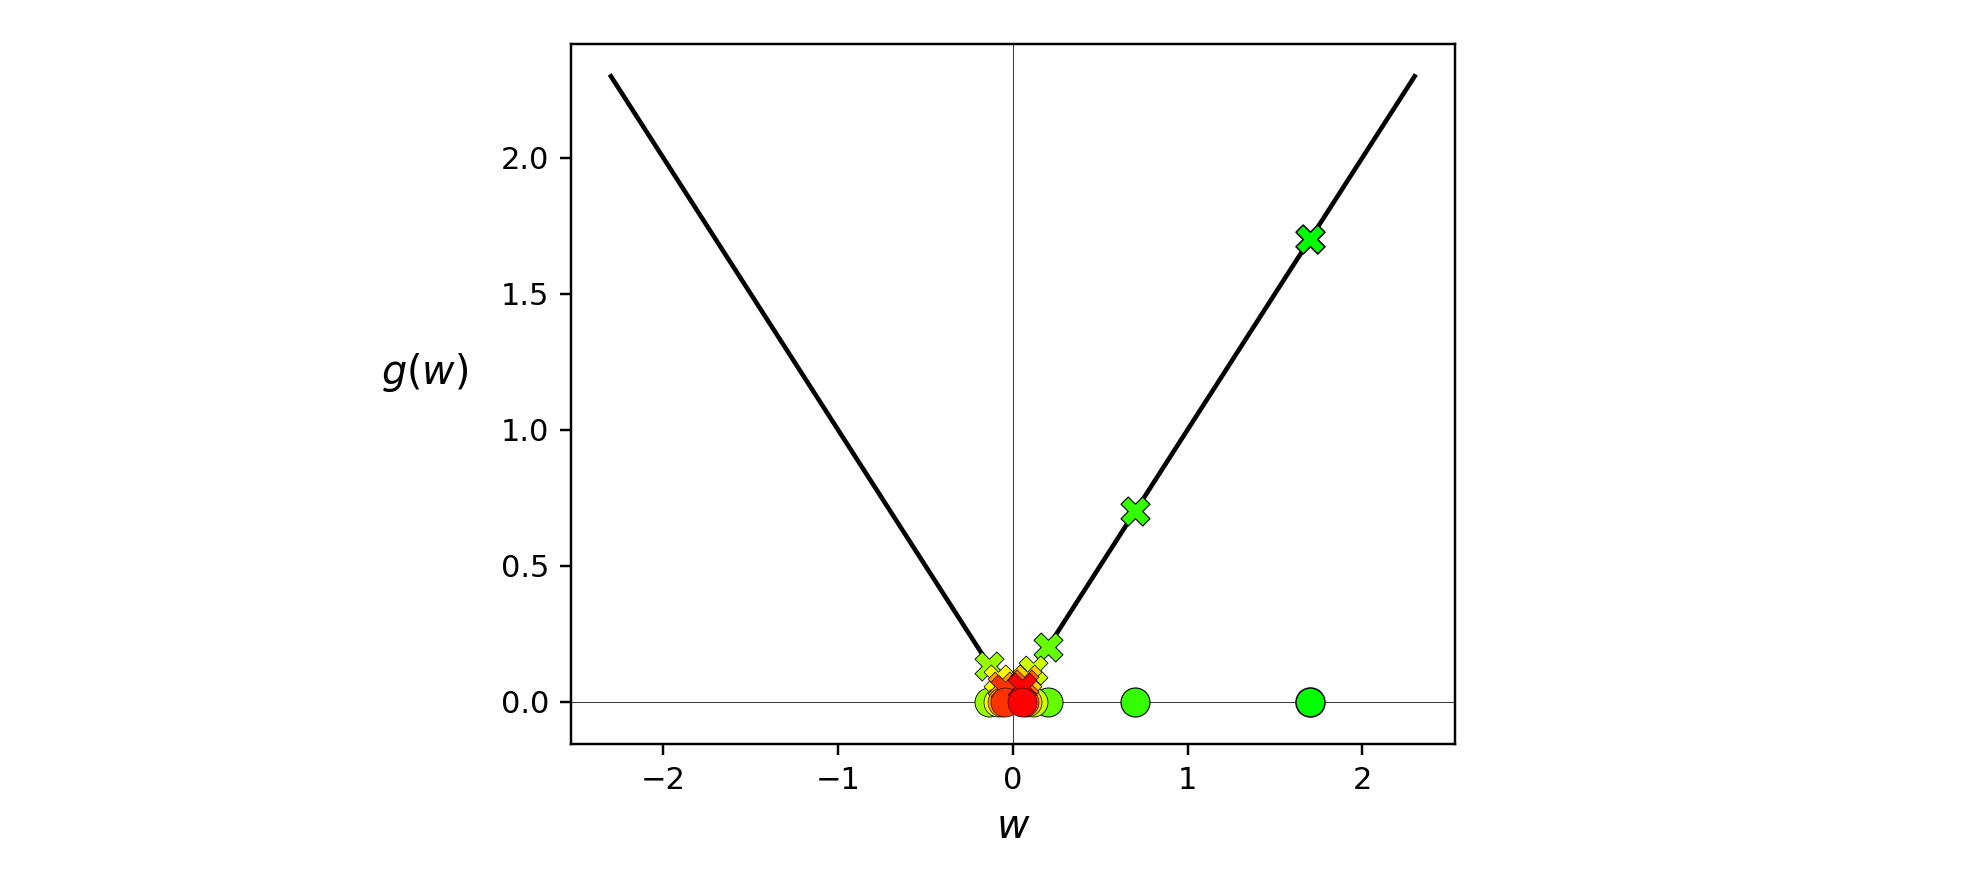

In [26]:
# what function should we play with?  Defined in the next line.
g = lambda w: np.abs(w)

# run the visualizer for our chosen input function, initial point, and step length alpha
demo = optlib.gradient_descent_demos.visualizer();

demo.draw_2d(g=g, w_inits = [1.7] ,steplength = 'diminishing',max_its = 10,version = 'unnormalized',wmin =-2.3,wmax = 2.3)

A close cousin to the absolute value is the sum of relu functions.  For example

\begin{equation}
g(w) = \text{max}(0,w - 0.5) + \text{max}(0,-w - 0.5)
\end{equation}

This is like an absolute value function with a long flat region of global minima at the bottom.  Here we can use a diminishing steplength, or pick the steplength value small enough so that we reach the flat region of global minima (and here we will stay since it is perfectly flat).  We run the same setup of gradient descent using the sum of relu functions above to illustrate using a fixed steplength value $\alpha = 0.5$.  Since there is a large region of global minima we can indeed reach a global minimum using this fixed steplength provided

<IPython.core.display.Javascript object>


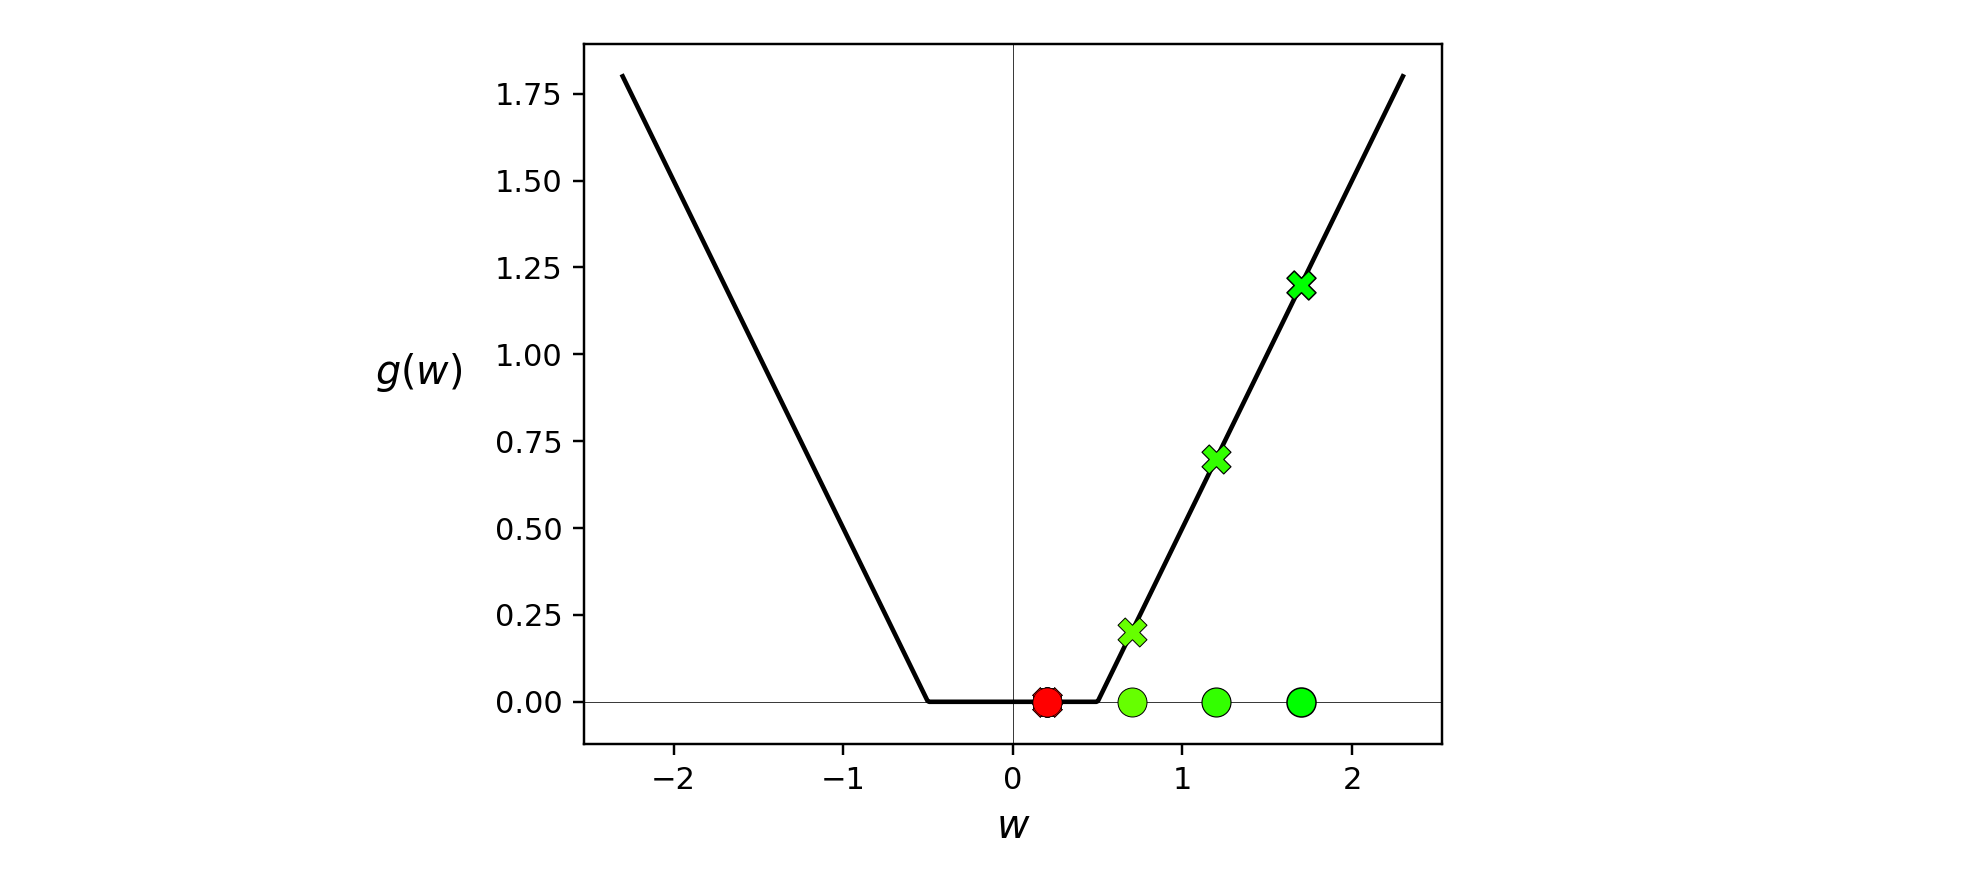

In [31]:
# what function should we play with?  Defined in the next line.
g = lambda w: np.maximum(0,w - 0.5) + np.maximum(0, - w - 0.5) 

# run the visualizer for our chosen input function, initial point, and step length alpha
demo = optlib.gradient_descent_demos.visualizer();

demo.draw_2d(g=g, w_inits = [1.7] ,steplength = 0.5,max_its = 10,version = 'unnormalized',wmin =-2.3,wmax = 2.3)

#### <span style="color:#a50e3e;">Example 6. </span>  (normalized) gradient descent and non-convex functions with saddle points and flat regions 

In this example we illustrate a very useful amenity of the normalized gradient scheme: the avoidance of saddle points that comes by controlling the exact length of each descent step via the steplength parameter.  The first function we use to illustrate this advantageous behavior is the following

$$
g(w) = \text{maximum}(0,(3w - 2.3)^3 + 1)^2 + \text{maximum}(0,(-3w + 0.7)^3 + 1)^2
$$

This function has a minimum at $w= \frac{1}{2}$ and saddle points at $w = \frac{7}{30}$ and $w = \frac{23}{30}$.  

To illustrate how normalized gradient descent can pass over the saddle point of this function we make a run starting at the point $w^0 = 0$, use a fixed steplength of $\alpha = 0.01$, and take $55$ steps.  We then produce an animation like the ones used above in the next Python cell, where one can use a slider mechanism to watch the run progress from its initialization (in green) to its final value (in red).  Notice how smoothly the run passes by the saddle point.  If we keep track of the weight associated with smallest function value here, we will get something very close to the global minimum.

In [ ]:
# what function should we play with?  Defined in the next line.
g = lambda w: np.maximum(0,(3*w - 2.3)**3 + 1)**2 + np.maximum(0, (-3*w + 0.7)**3 + 1)**2

# run the visualizer for our chosen input function, initial point, and step length alpha
demo = optlib.gradient_descent_demos.visualizer();

demo.animate_2d(g=g, w_init = 0,steplength = 0.01,max_its = 55,version = 'normalized',wmin = 0,wmax = 1)

Place the slider all the way to its full right position, so that the final point is colored red and no linear approximation is shown.  Now, lets discuss the convergence behavior of this run by examining the results above experiment and the general form of the $k^{th}$ step in the normalized method

$$
\mathbf{w}^{\,k} = \mathbf{w}^{\,k-1} - \alpha \frac{\nabla g(\mathbf{w}^{\,k-1})}{\left\Vert \nabla g(\mathbf{w}^{\,k-1}) \right\Vert_2 }
$$

which of course involves normalizing the length of the gradient at each step.  This means even if $\left\Vert \nabla g\left(\mathbf{w}^{\,k-1}\right) \right\Vert_2$ is very small in magnitude (but non-zero), as it is near the saddle point of the function here, the descent direction $ \frac{\nabla g(\mathbf{w}^{\,k-1})}{\left\Vert \nabla g(\mathbf{w}^{\,k-1}) \right\Vert_2 }$ has length one.  Thus steps near a stationary point still - as derived above - have length given by the value of the steplength parameter $\alpha$.  So unlike the unnormalized approach here if the length of the gradient gets small, the length of the steps stay the same.  This has the practical advantage allowing the normalized version of gradient descent to naturally *pass over saddle points of non-convex functions* as it did in this example. 

In the next Python cell we compare normalized and unnormalized gradient descent (left and right panels respectively) on the non-convex function used above.  Both algorithms use the same initial point ($w^0 = 0$), steplength parameter ($\alpha = 0.01$), and maximum number of iterations (55 each).  Steps are colored from green to red to indicate the starting and ending points of each run, with circles denoting the actual steps in the input space and 'x''s denoting their respective function evaluations.  Notice how - due to the re-scaling of each step via the derivative length - the unnormalized version halts at the function's saddle point, while the normalized version rushes past it as shown above. 

In [ ]:
# what function should we play with?  Defined in the next line.
g = lambda w: np.maximum(0,(3*w - 2.3)**3 + 1)**2 + np.maximum(0, (-3*w + 0.7)**3 + 1)**2

# run the visualizer for our chosen input function, initial point, and step length alpha
demo = optlib.gradient_descent_demos.visualizer();

demo.compare_versions_2d(g=g, w_init = 0,steplength = 0.01,max_its = 80,version = 'normalized',wmin = 0,wmax = 1)

Building on this example, let us now look at an example of a function with large flat areas


$$
g(w_1,w_2) = -e^{-\left(w_1^2 + w_2^2\right)} + 1
$$

to compare how normalized and unnormalized gradient descent deal with large regions of an input space where the gradient is almost zero.  This function has a single global minimum at the origin and comparing the two - as we do in the next Python cell - we can see that even when beginning on an almost completely flat area of the input space the normalized method can quickly find this minimum, whereas the unnormalized version can barely start moving in the right direction.  More specifically, we initialize both algorithms at the point $\mathbf{w}^0 = \begin{bmatrix} -3 \\ -2 \end{bmatrix}$ use the diminishing steplength parameter $\alpha = \frac{1}{k}$, and take 20 steps with each version.  The top two panels display the function from the side (left panel) and from above (right panel) for the normalized version, and likewise the bottom two panels display the results of the unnormalized version.

In [ ]:
# what function should we play with?  Defined in the next line.
g = lambda w: -np.exp(-3*(w[0]**2 + w[1]**2))  + 1 

# run the visualizer for our chosen input function, initial point, and step length alpha
demo = optlib.gradient_descent_demos.visualizer();
w_init = [-3,-2]; max_its = 20; steplength = 'diminishing';

demo.compare_versions_3d(g,w_init,steplength,max_its,wmax=3)

## 1.5  Convergence behavior and steplength parameter selection

When do we know gradient descent has reached a local minimum?  In other words, how do we know when to stop the algorithm? 

There are an array of mathematically rigorous ways of halting a local search method like gradient descent, wherein steps are taken until the steps are provably close to a stationary point of the function being minimized.  First and foremost among these is the *length (or magnitude) of the gradient* $\left\Vert \nabla g\left(\mathbf{w}^{\,k-1}\right)\right\Vert_2$.  If this value is *small* then the algorithm has by definition reached a stationary point of the function, and so we halt its progress having great confidence in the high quality of our final step.  Of course this can be a mistake if in fact it is a saddle point that is being reached.

Comparatively speaking, just setting a maximum number of iterations and letting the algorithm run until that number has been reached is certainly not nearly as rigorous an approach, and may not lead us to a point as close to a local minimum.  But it is *practical and fast* (comparatively speaking), and this speaks to how - generally speaking - mathematical optimization can be used in machine learning / deep learning.  Well founded mathematically rigorous laws are sometimes ignored, and we play 'fast and loose' with the rules.  Finding points that are infinitesimally close to a minimum is not our goal in and of itself, it is the performance of the associated learning problem that we care about.  So long as the learning problem is solved we will be happy campers.

> Halting the procedure after a pre-set number of maximum iterations is a common stopping condition for gradient descent in the machine learning / deep learning community.

What is good number for a maximum iteration count?  This is typically set manually / heuristically, and is influenced by things like computing resources, knowledge of the particular function being minimized, and - very importantly - the choice of the steplength parameter $\alpha$.  Smaller choices for $\alpha$ - while more easily providing descent at each step - frequently require more for the algorithm to achieve significant progress.  Conversely if $\alpha$ is set too large gradient descent may bounce around erratically forever never localizing in an adequate solution.

While there are a variety of mathematical tools we will detail in the next post that can give guidance as to how to set $\alpha$ in general, often in practice in machine learning / deep learning problems the steplength parameter $\alpha$ is determined by *trial and error*.  This often includes running gradient descent a number of times while trying out different fixed $\alpha$ values, or various diminishing steplength schemes, to determine which provides the lowest function value.

> Often in practice in machine learning / deep learning problems the steplength parameter $\alpha$ is determined by *trial and error*.  This often includes running gradient descent a number of times and trying out several fixed $\alpha$ values for all iterations, or various diminishing steplength schemes.